# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn_ys.config import Config
from mrcnn_ys import utils
import mrcnn_ys.model as modellib
from mrcnn_ys import visualize
from mrcnn_ys.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ubuntu/anaconda3

## Configurations

In [2]:
class ArmsConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "arms"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4

    # Number of classes (including background)
    #NUM_CLASSES = 1 # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 64
    IMAGE_MAX_DIM = 64

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (4, 8, 16, 32, 64)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
    def __init__(self, num_classes):
        self.NUM_CLASSES = num_classes+1
        super().__init__()
    
config = ArmsConfig(1)
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  64
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  64
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [64 64  3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                  

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [4]:
class ArmsDataset(utils.Dataset):

    img_list = []
    count = 0
    
    def load_list(self,train_path,anno_path):
        img_name_list = os.listdir(train_path)
        for name in img_name_list:
            self.img_list.append([train_path+name,anno_path+name])
            self.count += 1
            
        print(str(self.count) + "개의 데이터셋 로드 완료")
        

    def load_first(self,train_path,anno_path, height, width):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.load_list(train_path,anno_path)
        self.add_class("arms", 1, "arm_class")

        # Add images
        # Generate random specifications of images (i.e. color and
        # list of shapes sizes and locations). This is more compact than
        # actual images. Images are generated on the fly in load_image().
        for i in range(self.count):
            self.add_image("arms", image_id=i, path=None,
                           width=width, height=height )
            
         

    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        image_name = self.img_list[image_id][0]
        image = cv2.imread(image_name,cv2.IMREAD_COLOR)
        return image

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        #info = self.image_info[image_id]
        #if info["source"] == "shapes":
        #    return info["shapes"]
        #else:
        #    super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        mask_name = self.img_list[image_id][1]
        mask = cv2.imread(mask_name,cv2.IMREAD_GRAYSCALE)
        mask = np.expand_dims(mask,axis=-1)
        #print(mask.shape)
        #print(mask)

        # Map class names to class IDs.
        class_ids = np.array([1])

        return mask.astype(np.bool), class_ids.astype(np.int32)


In [5]:
# Training dataset
dataset_train = ArmsDataset()
dataset_train.load_first("../../../data/TrainVal_images/train_images/","../../../data/TrainVal_parsing_annotations/train_segmentations/",64,64)
dataset_train.prepare()


# Training dataset
dataset_val = ArmsDataset()
dataset_val.load_first("../../../data/TrainVal_images/val_images/","../../../data/TrainVal_parsing_annotations/val_segmentations/",64,64)
dataset_val.prepare()



38572개의 데이터셋 로드 완료
7273개의 데이터셋 로드 완료


--mask--
[[[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 ...

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]]


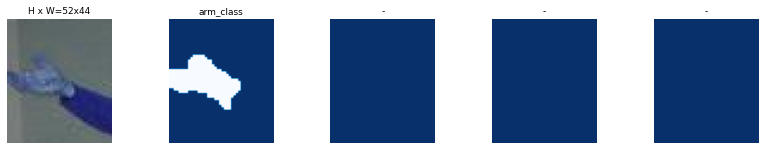

--mask--
[[[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 ...

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]]


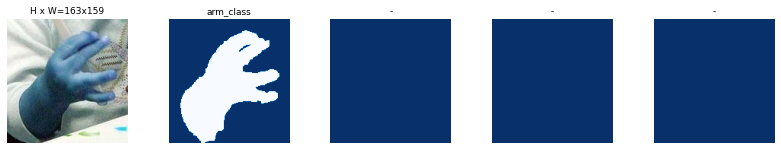

--mask--
[[[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 ...

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]]


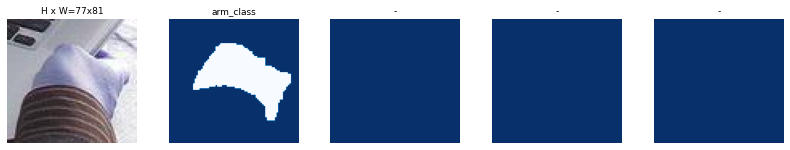

--mask--
[[[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 ...

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]]


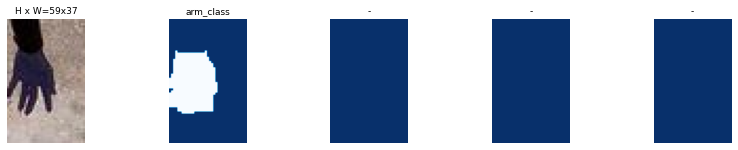

In [6]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)

    print("--mask--")
    print(mask)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [7]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [8]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [9]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=2, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/ubuntu/ys/capston/maskrcnn/Mask_RCNN/logs/arms20201012T2014/mask_rcnn_arms_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistri

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/keras/engine/training.py:1987: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  ord

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

Epoch 1/2


/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  1/100 [..............................] - ETA: 1042s - loss: 6.3031 - rpn_class_loss: 0.0538 - rpn_bbox_loss: 2.2001 - mrcnn_class_loss: 2.2072 - mrcnn_bbox_loss: 0.9454 - mrcnn_mask_loss: 0.8967

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  2/100 [..............................] - ETA: 963s - loss: 5.5770 - rpn_class_loss: 0.0729 - rpn_bbox_loss: 2.0388 - mrcnn_class_loss: 1.7700 - mrcnn_bbox_loss: 0.8071 - mrcnn_mask_loss: 0.8882 

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  3/100 [..............................] - ETA: 922s - loss: 5.2759 - rpn_class_loss: 0.0972 - rpn_bbox_loss: 1.9259 - mrcnn_class_loss: 1.4164 - mrcnn_bbox_loss: 0.9296 - mrcnn_mask_loss: 0.9067

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  4/100 [>.............................] - ETA: 914s - loss: 5.0811 - rpn_class_loss: 0.0989 - rpn_bbox_loss: 1.9375 - mrcnn_class_loss: 1.1685 - mrcnn_bbox_loss: 0.9476 - mrcnn_mask_loss: 0.9286

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  5/100 [>.............................] - ETA: 900s - loss: 4.7109 - rpn_class_loss: 0.1015 - rpn_bbox_loss: 1.7557 - mrcnn_class_loss: 0.9628 - mrcnn_bbox_loss: 0.9881 - mrcnn_mask_loss: 0.9029

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  6/100 [>.............................] - ETA: 882s - loss: 4.5288 - rpn_class_loss: 0.0973 - rpn_bbox_loss: 1.7209 - mrcnn_class_loss: 0.8449 - mrcnn_bbox_loss: 0.9627 - mrcnn_mask_loss: 0.9029

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  7/100 [=>............................] - ETA: 869s - loss: 4.4632 - rpn_class_loss: 0.0923 - rpn_bbox_loss: 1.6712 - mrcnn_class_loss: 0.7895 - mrcnn_bbox_loss: 0.9641 - mrcnn_mask_loss: 0.9460

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  8/100 [=>............................] - ETA: 864s - loss: 4.2652 - rpn_class_loss: 0.0890 - rpn_bbox_loss: 1.6247 - mrcnn_class_loss: 0.6983 - mrcnn_bbox_loss: 0.9051 - mrcnn_mask_loss: 0.9481

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  9/100 [=>............................] - ETA: 850s - loss: 4.1796 - rpn_class_loss: 0.0863 - rpn_bbox_loss: 1.5911 - mrcnn_class_loss: 0.6509 - mrcnn_bbox_loss: 0.9227 - mrcnn_mask_loss: 0.9286

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 10/100 [==>...........................] - ETA: 836s - loss: 4.0398 - rpn_class_loss: 0.0822 - rpn_bbox_loss: 1.4877 - mrcnn_class_loss: 0.6292 - mrcnn_bbox_loss: 0.9281 - mrcnn_mask_loss: 0.9125

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 11/100 [==>...........................] - ETA: 827s - loss: 3.9354 - rpn_class_loss: 0.0777 - rpn_bbox_loss: 1.4483 - mrcnn_class_loss: 0.5909 - mrcnn_bbox_loss: 0.9095 - mrcnn_mask_loss: 0.9089

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 12/100 [==>...........................] - ETA: 815s - loss: 3.8886 - rpn_class_loss: 0.0731 - rpn_bbox_loss: 1.4211 - mrcnn_class_loss: 0.5514 - mrcnn_bbox_loss: 0.9286 - mrcnn_mask_loss: 0.9144

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 13/100 [==>...........................] - ETA: 805s - loss: 3.7991 - rpn_class_loss: 0.0694 - rpn_bbox_loss: 1.4052 - mrcnn_class_loss: 0.5228 - mrcnn_bbox_loss: 0.9032 - mrcnn_mask_loss: 0.8985

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 14/100 [===>..........................] - ETA: 796s - loss: 3.6973 - rpn_class_loss: 0.0674 - rpn_bbox_loss: 1.3541 - mrcnn_class_loss: 0.4953 - mrcnn_bbox_loss: 0.8820 - mrcnn_mask_loss: 0.8986

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 15/100 [===>..........................] - ETA: 787s - loss: 3.6190 - rpn_class_loss: 0.0658 - rpn_bbox_loss: 1.3190 - mrcnn_class_loss: 0.4786 - mrcnn_bbox_loss: 0.8670 - mrcnn_mask_loss: 0.8886

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 16/100 [===>..........................] - ETA: 778s - loss: 3.5463 - rpn_class_loss: 0.0647 - rpn_bbox_loss: 1.2845 - mrcnn_class_loss: 0.4617 - mrcnn_bbox_loss: 0.8538 - mrcnn_mask_loss: 0.8816

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 17/100 [====>.........................] - ETA: 768s - loss: 3.4740 - rpn_class_loss: 0.0636 - rpn_bbox_loss: 1.2510 - mrcnn_class_loss: 0.4424 - mrcnn_bbox_loss: 0.8449 - mrcnn_mask_loss: 0.8721

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 18/100 [====>.........................] - ETA: 761s - loss: 3.4214 - rpn_class_loss: 0.0625 - rpn_bbox_loss: 1.2390 - mrcnn_class_loss: 0.4265 - mrcnn_bbox_loss: 0.8267 - mrcnn_mask_loss: 0.8668

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 19/100 [====>.........................] - ETA: 752s - loss: 3.3640 - rpn_class_loss: 0.0613 - rpn_bbox_loss: 1.2219 - mrcnn_class_loss: 0.4094 - mrcnn_bbox_loss: 0.8138 - mrcnn_mask_loss: 0.8577

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 20/100 [=====>........................] - ETA: 742s - loss: 3.2931 - rpn_class_loss: 0.0599 - rpn_bbox_loss: 1.1931 - mrcnn_class_loss: 0.3944 - mrcnn_bbox_loss: 0.7959 - mrcnn_mask_loss: 0.8498

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 21/100 [=====>........................] - ETA: 731s - loss: 3.2302 - rpn_class_loss: 0.0592 - rpn_bbox_loss: 1.1632 - mrcnn_class_loss: 0.3809 - mrcnn_bbox_loss: 0.7832 - mrcnn_mask_loss: 0.8438

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 22/100 [=====>........................] - ETA: 721s - loss: 3.1668 - rpn_class_loss: 0.0580 - rpn_bbox_loss: 1.1332 - mrcnn_class_loss: 0.3679 - mrcnn_bbox_loss: 0.7698 - mrcnn_mask_loss: 0.8380

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 23/100 [=====>........................] - ETA: 711s - loss: 3.1116 - rpn_class_loss: 0.0569 - rpn_bbox_loss: 1.1067 - mrcnn_class_loss: 0.3539 - mrcnn_bbox_loss: 0.7594 - mrcnn_mask_loss: 0.8347

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 24/100 [======>.......................] - ETA: 703s - loss: 3.0759 - rpn_class_loss: 0.0550 - rpn_bbox_loss: 1.0877 - mrcnn_class_loss: 0.3424 - mrcnn_bbox_loss: 0.7590 - mrcnn_mask_loss: 0.8318

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 25/100 [======>.......................] - ETA: 693s - loss: 3.0622 - rpn_class_loss: 0.0535 - rpn_bbox_loss: 1.0793 - mrcnn_class_loss: 0.3313 - mrcnn_bbox_loss: 0.7630 - mrcnn_mask_loss: 0.8353

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 26/100 [======>.......................] - ETA: 683s - loss: 3.0184 - rpn_class_loss: 0.0519 - rpn_bbox_loss: 1.0527 - mrcnn_class_loss: 0.3214 - mrcnn_bbox_loss: 0.7597 - mrcnn_mask_loss: 0.8327

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 27/100 [=======>......................] - ETA: 674s - loss: 2.9624 - rpn_class_loss: 0.0514 - rpn_bbox_loss: 1.0281 - mrcnn_class_loss: 0.3117 - mrcnn_bbox_loss: 0.7457 - mrcnn_mask_loss: 0.8255

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 28/100 [=======>......................] - ETA: 664s - loss: 2.9091 - rpn_class_loss: 0.0506 - rpn_bbox_loss: 1.0035 - mrcnn_class_loss: 0.3016 - mrcnn_bbox_loss: 0.7338 - mrcnn_mask_loss: 0.8197

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 29/100 [=======>......................] - ETA: 654s - loss: 2.8834 - rpn_class_loss: 0.0495 - rpn_bbox_loss: 0.9957 - mrcnn_class_loss: 0.2967 - mrcnn_bbox_loss: 0.7258 - mrcnn_mask_loss: 0.8156

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 30/100 [========>.....................] - ETA: 645s - loss: 2.8429 - rpn_class_loss: 0.0484 - rpn_bbox_loss: 0.9741 - mrcnn_class_loss: 0.2903 - mrcnn_bbox_loss: 0.7174 - mrcnn_mask_loss: 0.8126

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 31/100 [========>.....................] - ETA: 635s - loss: 2.8323 - rpn_class_loss: 0.0476 - rpn_bbox_loss: 0.9849 - mrcnn_class_loss: 0.2837 - mrcnn_bbox_loss: 0.7080 - mrcnn_mask_loss: 0.8081

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 32/100 [========>.....................] - ETA: 626s - loss: 2.8056 - rpn_class_loss: 0.0471 - rpn_bbox_loss: 0.9753 - mrcnn_class_loss: 0.2758 - mrcnn_bbox_loss: 0.7054 - mrcnn_mask_loss: 0.8020

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 33/100 [========>.....................] - ETA: 617s - loss: 2.7598 - rpn_class_loss: 0.0461 - rpn_bbox_loss: 0.9552 - mrcnn_class_loss: 0.2678 - mrcnn_bbox_loss: 0.6919 - mrcnn_mask_loss: 0.7988

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 34/100 [=========>....................] - ETA: 608s - loss: 2.7255 - rpn_class_loss: 0.0451 - rpn_bbox_loss: 0.9446 - mrcnn_class_loss: 0.2601 - mrcnn_bbox_loss: 0.6806 - mrcnn_mask_loss: 0.7951

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 35/100 [=========>....................] - ETA: 599s - loss: 2.6950 - rpn_class_loss: 0.0446 - rpn_bbox_loss: 0.9305 - mrcnn_class_loss: 0.2536 - mrcnn_bbox_loss: 0.6770 - mrcnn_mask_loss: 0.7893

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 36/100 [=========>....................] - ETA: 589s - loss: 2.6699 - rpn_class_loss: 0.0440 - rpn_bbox_loss: 0.9132 - mrcnn_class_loss: 0.2486 - mrcnn_bbox_loss: 0.6795 - mrcnn_mask_loss: 0.7845

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 37/100 [==========>...................] - ETA: 581s - loss: 2.6717 - rpn_class_loss: 0.0434 - rpn_bbox_loss: 0.9217 - mrcnn_class_loss: 0.2445 - mrcnn_bbox_loss: 0.6819 - mrcnn_mask_loss: 0.7801

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 38/100 [==========>...................] - ETA: 572s - loss: 2.6487 - rpn_class_loss: 0.0428 - rpn_bbox_loss: 0.9157 - mrcnn_class_loss: 0.2385 - mrcnn_bbox_loss: 0.6751 - mrcnn_mask_loss: 0.7765

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 39/100 [==========>...................] - ETA: 563s - loss: 2.6213 - rpn_class_loss: 0.0422 - rpn_bbox_loss: 0.9067 - mrcnn_class_loss: 0.2336 - mrcnn_bbox_loss: 0.6653 - mrcnn_mask_loss: 0.7734

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 40/100 [===========>..................] - ETA: 554s - loss: 2.5972 - rpn_class_loss: 0.0416 - rpn_bbox_loss: 0.8931 - mrcnn_class_loss: 0.2282 - mrcnn_bbox_loss: 0.6645 - mrcnn_mask_loss: 0.7698

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 41/100 [===========>..................] - ETA: 545s - loss: 2.5733 - rpn_class_loss: 0.0410 - rpn_bbox_loss: 0.8880 - mrcnn_class_loss: 0.2234 - mrcnn_bbox_loss: 0.6559 - mrcnn_mask_loss: 0.7650

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 42/100 [===========>..................] - ETA: 536s - loss: 2.5572 - rpn_class_loss: 0.0404 - rpn_bbox_loss: 0.8779 - mrcnn_class_loss: 0.2202 - mrcnn_bbox_loss: 0.6563 - mrcnn_mask_loss: 0.7623

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 43/100 [===========>..................] - ETA: 527s - loss: 2.5332 - rpn_class_loss: 0.0398 - rpn_bbox_loss: 0.8649 - mrcnn_class_loss: 0.2168 - mrcnn_bbox_loss: 0.6527 - mrcnn_mask_loss: 0.7591

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 44/100 [============>.................] - ETA: 517s - loss: 2.5252 - rpn_class_loss: 0.0393 - rpn_bbox_loss: 0.8673 - mrcnn_class_loss: 0.2141 - mrcnn_bbox_loss: 0.6472 - mrcnn_mask_loss: 0.7573

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 45/100 [============>.................] - ETA: 508s - loss: 2.5113 - rpn_class_loss: 0.0387 - rpn_bbox_loss: 0.8650 - mrcnn_class_loss: 0.2100 - mrcnn_bbox_loss: 0.6437 - mrcnn_mask_loss: 0.7539

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 46/100 [============>.................] - ETA: 499s - loss: 2.7641 - rpn_class_loss: 0.0398 - rpn_bbox_loss: 1.1324 - mrcnn_class_loss: 0.2064 - mrcnn_bbox_loss: 0.6361 - mrcnn_mask_loss: 0.7494

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 47/100 [=============>................] - ETA: 490s - loss: 2.7363 - rpn_class_loss: 0.0392 - rpn_bbox_loss: 1.1162 - mrcnn_class_loss: 0.2033 - mrcnn_bbox_loss: 0.6299 - mrcnn_mask_loss: 0.7476

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 48/100 [=============>................] - ETA: 481s - loss: 2.7181 - rpn_class_loss: 0.0388 - rpn_bbox_loss: 1.1058 - mrcnn_class_loss: 0.1998 - mrcnn_bbox_loss: 0.6285 - mrcnn_mask_loss: 0.7452

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 49/100 [=============>................] - ETA: 471s - loss: 2.6980 - rpn_class_loss: 0.0382 - rpn_bbox_loss: 1.0961 - mrcnn_class_loss: 0.1966 - mrcnn_bbox_loss: 0.6227 - mrcnn_mask_loss: 0.7443

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 50/100 [==============>...............] - ETA: 462s - loss: 2.6741 - rpn_class_loss: 0.0377 - rpn_bbox_loss: 1.0818 - mrcnn_class_loss: 0.1955 - mrcnn_bbox_loss: 0.6177 - mrcnn_mask_loss: 0.7414

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 51/100 [==============>...............] - ETA: 454s - loss: 2.6535 - rpn_class_loss: 0.0372 - rpn_bbox_loss: 1.0692 - mrcnn_class_loss: 0.1931 - mrcnn_bbox_loss: 0.6169 - mrcnn_mask_loss: 0.7372

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 52/100 [==============>...............] - ETA: 444s - loss: 2.6255 - rpn_class_loss: 0.0367 - rpn_bbox_loss: 1.0544 - mrcnn_class_loss: 0.1902 - mrcnn_bbox_loss: 0.6096 - mrcnn_mask_loss: 0.7345

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 53/100 [==============>...............] - ETA: 435s - loss: 2.6163 - rpn_class_loss: 0.0363 - rpn_bbox_loss: 1.0508 - mrcnn_class_loss: 0.1881 - mrcnn_bbox_loss: 0.6082 - mrcnn_mask_loss: 0.7331

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 54/100 [===============>..............] - ETA: 426s - loss: 2.5941 - rpn_class_loss: 0.0358 - rpn_bbox_loss: 1.0394 - mrcnn_class_loss: 0.1860 - mrcnn_bbox_loss: 0.6039 - mrcnn_mask_loss: 0.7291

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 55/100 [===============>..............] - ETA: 417s - loss: 2.5788 - rpn_class_loss: 0.0354 - rpn_bbox_loss: 1.0312 - mrcnn_class_loss: 0.1839 - mrcnn_bbox_loss: 0.6023 - mrcnn_mask_loss: 0.7260

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 56/100 [===============>..............] - ETA: 408s - loss: 2.5573 - rpn_class_loss: 0.0350 - rpn_bbox_loss: 1.0205 - mrcnn_class_loss: 0.1820 - mrcnn_bbox_loss: 0.5959 - mrcnn_mask_loss: 0.7239

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 57/100 [================>.............] - ETA: 398s - loss: 2.5348 - rpn_class_loss: 0.0346 - rpn_bbox_loss: 1.0099 - mrcnn_class_loss: 0.1803 - mrcnn_bbox_loss: 0.5907 - mrcnn_mask_loss: 0.7194

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 58/100 [================>.............] - ETA: 389s - loss: 2.5184 - rpn_class_loss: 0.0342 - rpn_bbox_loss: 1.0032 - mrcnn_class_loss: 0.1784 - mrcnn_bbox_loss: 0.5861 - mrcnn_mask_loss: 0.7164

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 59/100 [================>.............] - ETA: 380s - loss: 2.5083 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.9978 - mrcnn_class_loss: 0.1767 - mrcnn_bbox_loss: 0.5863 - mrcnn_mask_loss: 0.7138

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 60/100 [=================>............] - ETA: 371s - loss: 2.4864 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.9869 - mrcnn_class_loss: 0.1746 - mrcnn_bbox_loss: 0.5811 - mrcnn_mask_loss: 0.7103

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 61/100 [=================>............] - ETA: 362s - loss: 2.4696 - rpn_class_loss: 0.0331 - rpn_bbox_loss: 0.9767 - mrcnn_class_loss: 0.1732 - mrcnn_bbox_loss: 0.5790 - mrcnn_mask_loss: 0.7077

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 62/100 [=================>............] - ETA: 352s - loss: 2.4516 - rpn_class_loss: 0.0327 - rpn_bbox_loss: 0.9685 - mrcnn_class_loss: 0.1712 - mrcnn_bbox_loss: 0.5744 - mrcnn_mask_loss: 0.7049

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 63/100 [=================>............] - ETA: 343s - loss: 2.4327 - rpn_class_loss: 0.0323 - rpn_bbox_loss: 0.9583 - mrcnn_class_loss: 0.1691 - mrcnn_bbox_loss: 0.5700 - mrcnn_mask_loss: 0.7030

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 64/100 [==================>...........] - ETA: 334s - loss: 2.4244 - rpn_class_loss: 0.0320 - rpn_bbox_loss: 0.9533 - mrcnn_class_loss: 0.1671 - mrcnn_bbox_loss: 0.5729 - mrcnn_mask_loss: 0.6990

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 65/100 [==================>...........] - ETA: 325s - loss: 2.4100 - rpn_class_loss: 0.0316 - rpn_bbox_loss: 0.9501 - mrcnn_class_loss: 0.1655 - mrcnn_bbox_loss: 0.5668 - mrcnn_mask_loss: 0.6960

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 66/100 [==================>...........] - ETA: 315s - loss: 2.3928 - rpn_class_loss: 0.0313 - rpn_bbox_loss: 0.9400 - mrcnn_class_loss: 0.1637 - mrcnn_bbox_loss: 0.5666 - mrcnn_mask_loss: 0.6912

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 67/100 [===================>..........] - ETA: 306s - loss: 2.3784 - rpn_class_loss: 0.0310 - rpn_bbox_loss: 0.9322 - mrcnn_class_loss: 0.1620 - mrcnn_bbox_loss: 0.5626 - mrcnn_mask_loss: 0.6905

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 68/100 [===================>..........] - ETA: 297s - loss: 2.3631 - rpn_class_loss: 0.0307 - rpn_bbox_loss: 0.9265 - mrcnn_class_loss: 0.1601 - mrcnn_bbox_loss: 0.5585 - mrcnn_mask_loss: 0.6873

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 69/100 [===================>..........] - ETA: 288s - loss: 2.3497 - rpn_class_loss: 0.0304 - rpn_bbox_loss: 0.9208 - mrcnn_class_loss: 0.1582 - mrcnn_bbox_loss: 0.5549 - mrcnn_mask_loss: 0.6854

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 70/100 [====================>.........] - ETA: 278s - loss: 2.3393 - rpn_class_loss: 0.0301 - rpn_bbox_loss: 0.9192 - mrcnn_class_loss: 0.1564 - mrcnn_bbox_loss: 0.5516 - mrcnn_mask_loss: 0.6820

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 71/100 [====================>.........] - ETA: 269s - loss: 2.3260 - rpn_class_loss: 0.0298 - rpn_bbox_loss: 0.9132 - mrcnn_class_loss: 0.1543 - mrcnn_bbox_loss: 0.5490 - mrcnn_mask_loss: 0.6798

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 72/100 [====================>.........] - ETA: 260s - loss: 2.3148 - rpn_class_loss: 0.0295 - rpn_bbox_loss: 0.9082 - mrcnn_class_loss: 0.1525 - mrcnn_bbox_loss: 0.5462 - mrcnn_mask_loss: 0.6784

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 73/100 [====================>.........] - ETA: 250s - loss: 2.3005 - rpn_class_loss: 0.0293 - rpn_bbox_loss: 0.9006 - mrcnn_class_loss: 0.1512 - mrcnn_bbox_loss: 0.5432 - mrcnn_mask_loss: 0.6762

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 74/100 [=====================>........] - ETA: 241s - loss: 2.2859 - rpn_class_loss: 0.0291 - rpn_bbox_loss: 0.8942 - mrcnn_class_loss: 0.1500 - mrcnn_bbox_loss: 0.5393 - mrcnn_mask_loss: 0.6733

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 75/100 [=====================>........] - ETA: 232s - loss: 2.2709 - rpn_class_loss: 0.0288 - rpn_bbox_loss: 0.8890 - mrcnn_class_loss: 0.1483 - mrcnn_bbox_loss: 0.5341 - mrcnn_mask_loss: 0.6707

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 76/100 [=====================>........] - ETA: 223s - loss: 2.2653 - rpn_class_loss: 0.0285 - rpn_bbox_loss: 0.8881 - mrcnn_class_loss: 0.1464 - mrcnn_bbox_loss: 0.5326 - mrcnn_mask_loss: 0.6697

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 77/100 [======================>.......] - ETA: 213s - loss: 2.2582 - rpn_class_loss: 0.0283 - rpn_bbox_loss: 0.8823 - mrcnn_class_loss: 0.1449 - mrcnn_bbox_loss: 0.5347 - mrcnn_mask_loss: 0.6679

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 78/100 [======================>.......] - ETA: 204s - loss: 2.2496 - rpn_class_loss: 0.0281 - rpn_bbox_loss: 0.8781 - mrcnn_class_loss: 0.1433 - mrcnn_bbox_loss: 0.5326 - mrcnn_mask_loss: 0.6675

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 79/100 [======================>.......] - ETA: 195s - loss: 2.2371 - rpn_class_loss: 0.0279 - rpn_bbox_loss: 0.8722 - mrcnn_class_loss: 0.1420 - mrcnn_bbox_loss: 0.5299 - mrcnn_mask_loss: 0.6652

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 80/100 [=======================>......] - ETA: 185s - loss: 2.2328 - rpn_class_loss: 0.0277 - rpn_bbox_loss: 0.8714 - mrcnn_class_loss: 0.1407 - mrcnn_bbox_loss: 0.5300 - mrcnn_mask_loss: 0.6630

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 81/100 [=======================>......] - ETA: 176s - loss: 2.2215 - rpn_class_loss: 0.0275 - rpn_bbox_loss: 0.8645 - mrcnn_class_loss: 0.1395 - mrcnn_bbox_loss: 0.5271 - mrcnn_mask_loss: 0.6629

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 82/100 [=======================>......] - ETA: 167s - loss: 2.2119 - rpn_class_loss: 0.0272 - rpn_bbox_loss: 0.8584 - mrcnn_class_loss: 0.1386 - mrcnn_bbox_loss: 0.5265 - mrcnn_mask_loss: 0.6612

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 83/100 [=======================>......] - ETA: 158s - loss: 2.2069 - rpn_class_loss: 0.0270 - rpn_bbox_loss: 0.8600 - mrcnn_class_loss: 0.1371 - mrcnn_bbox_loss: 0.5230 - mrcnn_mask_loss: 0.6597

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 84/100 [========================>.....] - ETA: 148s - loss: 2.1957 - rpn_class_loss: 0.0268 - rpn_bbox_loss: 0.8528 - mrcnn_class_loss: 0.1358 - mrcnn_bbox_loss: 0.5215 - mrcnn_mask_loss: 0.6588

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 85/100 [========================>.....] - ETA: 139s - loss: 2.1864 - rpn_class_loss: 0.0266 - rpn_bbox_loss: 0.8458 - mrcnn_class_loss: 0.1349 - mrcnn_bbox_loss: 0.5203 - mrcnn_mask_loss: 0.6587

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 86/100 [========================>.....] - ETA: 130s - loss: 2.1812 - rpn_class_loss: 0.0264 - rpn_bbox_loss: 0.8452 - mrcnn_class_loss: 0.1339 - mrcnn_bbox_loss: 0.5186 - mrcnn_mask_loss: 0.6570

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 87/100 [=========================>....] - ETA: 120s - loss: 2.1698 - rpn_class_loss: 0.0262 - rpn_bbox_loss: 0.8399 - mrcnn_class_loss: 0.1328 - mrcnn_bbox_loss: 0.5173 - mrcnn_mask_loss: 0.6537

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 88/100 [=========================>....] - ETA: 111s - loss: 2.1601 - rpn_class_loss: 0.0260 - rpn_bbox_loss: 0.8357 - mrcnn_class_loss: 0.1318 - mrcnn_bbox_loss: 0.5142 - mrcnn_mask_loss: 0.6525

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 89/100 [=========================>....] - ETA: 102s - loss: 2.1498 - rpn_class_loss: 0.0258 - rpn_bbox_loss: 0.8296 - mrcnn_class_loss: 0.1307 - mrcnn_bbox_loss: 0.5126 - mrcnn_mask_loss: 0.6510

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 90/100 [==========================>...] - ETA: 92s - loss: 2.1408 - rpn_class_loss: 0.0256 - rpn_bbox_loss: 0.8247 - mrcnn_class_loss: 0.1307 - mrcnn_bbox_loss: 0.5113 - mrcnn_mask_loss: 0.6485 

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 91/100 [==========================>...] - ETA: 83s - loss: 2.1273 - rpn_class_loss: 0.0254 - rpn_bbox_loss: 0.8175 - mrcnn_class_loss: 0.1297 - mrcnn_bbox_loss: 0.5074 - mrcnn_mask_loss: 0.6473

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 92/100 [==========================>...] - ETA: 74s - loss: 2.1237 - rpn_class_loss: 0.0253 - rpn_bbox_loss: 0.8193 - mrcnn_class_loss: 0.1291 - mrcnn_bbox_loss: 0.5043 - mrcnn_mask_loss: 0.6457

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 93/100 [==========================>...] - ETA: 65s - loss: 2.1146 - rpn_class_loss: 0.0252 - rpn_bbox_loss: 0.8157 - mrcnn_class_loss: 0.1282 - mrcnn_bbox_loss: 0.5021 - mrcnn_mask_loss: 0.6433

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 94/100 [===========================>..] - ETA: 55s - loss: 2.1153 - rpn_class_loss: 0.0250 - rpn_bbox_loss: 0.8161 - mrcnn_class_loss: 0.1275 - mrcnn_bbox_loss: 0.5041 - mrcnn_mask_loss: 0.6426

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 95/100 [===========================>..] - ETA: 46s - loss: 2.1121 - rpn_class_loss: 0.0249 - rpn_bbox_loss: 0.8169 - mrcnn_class_loss: 0.1265 - mrcnn_bbox_loss: 0.5027 - mrcnn_mask_loss: 0.6411

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 96/100 [===========================>..] - ETA: 37s - loss: 2.1038 - rpn_class_loss: 0.0247 - rpn_bbox_loss: 0.8118 - mrcnn_class_loss: 0.1258 - mrcnn_bbox_loss: 0.5006 - mrcnn_mask_loss: 0.6410

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 97/100 [============================>.] - ETA: 27s - loss: 2.0937 - rpn_class_loss: 0.0245 - rpn_bbox_loss: 0.8073 - mrcnn_class_loss: 0.1246 - mrcnn_bbox_loss: 0.4977 - mrcnn_mask_loss: 0.6395

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 98/100 [============================>.] - ETA: 18s - loss: 2.0897 - rpn_class_loss: 0.0243 - rpn_bbox_loss: 0.8056 - mrcnn_class_loss: 0.1239 - mrcnn_bbox_loss: 0.4975 - mrcnn_mask_loss: 0.6383

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 99/100 [============================>.] - ETA: 9s - loss: 2.0807 - rpn_class_loss: 0.0242 - rpn_bbox_loss: 0.8009 - mrcnn_class_loss: 0.1236 - mrcnn_bbox_loss: 0.4944 - mrcnn_mask_loss: 0.6375 

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

100/100 [==============================] - 948s - loss: 2.0753 - rpn_class_loss: 0.0241 - rpn_bbox_loss: 0.7984 - mrcnn_class_loss: 0.1233 - mrcnn_bbox_loss: 0.4938 - mrcnn_mask_loss: 0.6358 - val_loss: 3.8010 - val_rpn_class_loss: 0.0215 - val_rpn_bbox_loss: 2.8657 - val_mrcnn_class_loss: 0.0454 - val_mrcnn_bbox_loss: 0.3494 - val_mrcnn_mask_loss: 0.5190

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w


Epoch 2/2
  1/100 [..............................] - ETA: 887s - loss: 1.7297 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.6463 - mrcnn_class_loss: 0.0924 - mrcnn_bbox_loss: 0.3393 - mrcnn_mask_loss: 0.6434

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  2/100 [..............................] - ETA: 903s - loss: 1.7058 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.6338 - mrcnn_class_loss: 0.0750 - mrcnn_bbox_loss: 0.3508 - mrcnn_mask_loss: 0.6383

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  3/100 [..............................] - ETA: 906s - loss: 1.6846 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.6142 - mrcnn_class_loss: 0.0783 - mrcnn_bbox_loss: 0.3571 - mrcnn_mask_loss: 0.6262

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  4/100 [>.............................] - ETA: 896s - loss: 1.6221 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.5947 - mrcnn_class_loss: 0.0780 - mrcnn_bbox_loss: 0.3453 - mrcnn_mask_loss: 0.5961

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  5/100 [>.............................] - ETA: 887s - loss: 1.7217 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.6559 - mrcnn_class_loss: 0.0836 - mrcnn_bbox_loss: 0.3509 - mrcnn_mask_loss: 0.6224

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  6/100 [>.............................] - ETA: 874s - loss: 1.6421 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.6060 - mrcnn_class_loss: 0.0787 - mrcnn_bbox_loss: 0.3536 - mrcnn_mask_loss: 0.5952

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  7/100 [=>............................] - ETA: 862s - loss: 1.6565 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.6175 - mrcnn_class_loss: 0.0760 - mrcnn_bbox_loss: 0.3732 - mrcnn_mask_loss: 0.5816

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  8/100 [=>............................] - ETA: 854s - loss: 1.7282 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.6814 - mrcnn_class_loss: 0.0708 - mrcnn_bbox_loss: 0.3783 - mrcnn_mask_loss: 0.5889

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  9/100 [=>............................] - ETA: 847s - loss: 1.6998 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.6656 - mrcnn_class_loss: 0.0762 - mrcnn_bbox_loss: 0.3790 - mrcnn_mask_loss: 0.5706

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 10/100 [==>...........................] - ETA: 837s - loss: 1.6762 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.6595 - mrcnn_class_loss: 0.0783 - mrcnn_bbox_loss: 0.3713 - mrcnn_mask_loss: 0.5587

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 11/100 [==>...........................] - ETA: 828s - loss: 1.6451 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.6319 - mrcnn_class_loss: 0.0772 - mrcnn_bbox_loss: 0.3731 - mrcnn_mask_loss: 0.5547

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 12/100 [==>...........................] - ETA: 820s - loss: 1.6101 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.6187 - mrcnn_class_loss: 0.0759 - mrcnn_bbox_loss: 0.3592 - mrcnn_mask_loss: 0.5482

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 13/100 [==>...........................] - ETA: 811s - loss: 1.6129 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.6367 - mrcnn_class_loss: 0.0708 - mrcnn_bbox_loss: 0.3606 - mrcnn_mask_loss: 0.5370

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 14/100 [===>..........................] - ETA: 803s - loss: 1.6255 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.6412 - mrcnn_class_loss: 0.0698 - mrcnn_bbox_loss: 0.3614 - mrcnn_mask_loss: 0.5453

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 15/100 [===>..........................] - ETA: 794s - loss: 1.6501 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.6675 - mrcnn_class_loss: 0.0671 - mrcnn_bbox_loss: 0.3629 - mrcnn_mask_loss: 0.5447

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 16/100 [===>..........................] - ETA: 786s - loss: 1.6516 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.6600 - mrcnn_class_loss: 0.0664 - mrcnn_bbox_loss: 0.3678 - mrcnn_mask_loss: 0.5495

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 17/100 [====>.........................] - ETA: 776s - loss: 1.6461 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.6546 - mrcnn_class_loss: 0.0659 - mrcnn_bbox_loss: 0.3648 - mrcnn_mask_loss: 0.5530

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 18/100 [====>.........................] - ETA: 767s - loss: 1.6245 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.6414 - mrcnn_class_loss: 0.0636 - mrcnn_bbox_loss: 0.3650 - mrcnn_mask_loss: 0.5467

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 19/100 [====>.........................] - ETA: 759s - loss: 1.6012 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.6310 - mrcnn_class_loss: 0.0621 - mrcnn_bbox_loss: 0.3581 - mrcnn_mask_loss: 0.5422

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 20/100 [=====>........................] - ETA: 749s - loss: 1.5870 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.6226 - mrcnn_class_loss: 0.0622 - mrcnn_bbox_loss: 0.3547 - mrcnn_mask_loss: 0.5398

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 21/100 [=====>........................] - ETA: 741s - loss: 1.5828 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.6193 - mrcnn_class_loss: 0.0634 - mrcnn_bbox_loss: 0.3537 - mrcnn_mask_loss: 0.5387

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 22/100 [=====>........................] - ETA: 732s - loss: 1.5871 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.6275 - mrcnn_class_loss: 0.0617 - mrcnn_bbox_loss: 0.3546 - mrcnn_mask_loss: 0.5357

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 23/100 [=====>........................] - ETA: 721s - loss: 1.5657 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.6076 - mrcnn_class_loss: 0.0603 - mrcnn_bbox_loss: 0.3564 - mrcnn_mask_loss: 0.5338

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 24/100 [======>.......................] - ETA: 712s - loss: 1.5495 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.5967 - mrcnn_class_loss: 0.0617 - mrcnn_bbox_loss: 0.3524 - mrcnn_mask_loss: 0.5312

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 25/100 [======>.......................] - ETA: 702s - loss: 1.5232 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.5790 - mrcnn_class_loss: 0.0616 - mrcnn_bbox_loss: 0.3466 - mrcnn_mask_loss: 0.5284

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 26/100 [======>.......................] - ETA: 693s - loss: 1.5378 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.6011 - mrcnn_class_loss: 0.0609 - mrcnn_bbox_loss: 0.3426 - mrcnn_mask_loss: 0.5256

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 27/100 [=======>......................] - ETA: 684s - loss: 1.5256 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.5962 - mrcnn_class_loss: 0.0598 - mrcnn_bbox_loss: 0.3423 - mrcnn_mask_loss: 0.5198

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 28/100 [=======>......................] - ETA: 675s - loss: 1.5316 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.6032 - mrcnn_class_loss: 0.0578 - mrcnn_bbox_loss: 0.3438 - mrcnn_mask_loss: 0.5193

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 29/100 [=======>......................] - ETA: 665s - loss: 1.5160 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.5895 - mrcnn_class_loss: 0.0579 - mrcnn_bbox_loss: 0.3406 - mrcnn_mask_loss: 0.5206

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 30/100 [========>.....................] - ETA: 656s - loss: 1.4999 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.5789 - mrcnn_class_loss: 0.0566 - mrcnn_bbox_loss: 0.3399 - mrcnn_mask_loss: 0.5170

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 31/100 [========>.....................] - ETA: 646s - loss: 1.5323 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.6175 - mrcnn_class_loss: 0.0555 - mrcnn_bbox_loss: 0.3364 - mrcnn_mask_loss: 0.5153

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 32/100 [========>.....................] - ETA: 637s - loss: 1.5147 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.6093 - mrcnn_class_loss: 0.0553 - mrcnn_bbox_loss: 0.3314 - mrcnn_mask_loss: 0.5111

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 33/100 [========>.....................] - ETA: 627s - loss: 1.5214 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.6160 - mrcnn_class_loss: 0.0549 - mrcnn_bbox_loss: 0.3311 - mrcnn_mask_loss: 0.5120

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 34/100 [=========>....................] - ETA: 618s - loss: 1.5134 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.6080 - mrcnn_class_loss: 0.0559 - mrcnn_bbox_loss: 0.3297 - mrcnn_mask_loss: 0.5124

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 35/100 [=========>....................] - ETA: 609s - loss: 1.5174 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.6180 - mrcnn_class_loss: 0.0555 - mrcnn_bbox_loss: 0.3266 - mrcnn_mask_loss: 0.5099

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 36/100 [=========>....................] - ETA: 598s - loss: 1.5302 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.6333 - mrcnn_class_loss: 0.0573 - mrcnn_bbox_loss: 0.3247 - mrcnn_mask_loss: 0.5074

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 37/100 [==========>...................] - ETA: 589s - loss: 1.5263 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.6331 - mrcnn_class_loss: 0.0569 - mrcnn_bbox_loss: 0.3254 - mrcnn_mask_loss: 0.5034

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 38/100 [==========>...................] - ETA: 580s - loss: 1.5384 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.6503 - mrcnn_class_loss: 0.0562 - mrcnn_bbox_loss: 0.3263 - mrcnn_mask_loss: 0.4980

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 39/100 [==========>...................] - ETA: 570s - loss: 1.5272 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.6429 - mrcnn_class_loss: 0.0565 - mrcnn_bbox_loss: 0.3270 - mrcnn_mask_loss: 0.4931

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 40/100 [===========>..................] - ETA: 560s - loss: 1.5138 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.6324 - mrcnn_class_loss: 0.0580 - mrcnn_bbox_loss: 0.3248 - mrcnn_mask_loss: 0.4909

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 41/100 [===========>..................] - ETA: 550s - loss: 1.5269 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.6484 - mrcnn_class_loss: 0.0585 - mrcnn_bbox_loss: 0.3205 - mrcnn_mask_loss: 0.4917

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 42/100 [===========>..................] - ETA: 542s - loss: 1.5140 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.6390 - mrcnn_class_loss: 0.0586 - mrcnn_bbox_loss: 0.3199 - mrcnn_mask_loss: 0.4887

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 43/100 [===========>..................] - ETA: 532s - loss: 1.5258 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.6555 - mrcnn_class_loss: 0.0574 - mrcnn_bbox_loss: 0.3185 - mrcnn_mask_loss: 0.4866

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 44/100 [============>.................] - ETA: 523s - loss: 1.5233 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.6461 - mrcnn_class_loss: 0.0588 - mrcnn_bbox_loss: 0.3180 - mrcnn_mask_loss: 0.4925

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 45/100 [============>.................] - ETA: 513s - loss: 1.5167 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.6390 - mrcnn_class_loss: 0.0586 - mrcnn_bbox_loss: 0.3159 - mrcnn_mask_loss: 0.4953

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 46/100 [============>.................] - ETA: 504s - loss: 1.5095 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.6352 - mrcnn_class_loss: 0.0589 - mrcnn_bbox_loss: 0.3133 - mrcnn_mask_loss: 0.4943

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 47/100 [=============>................] - ETA: 494s - loss: 1.5075 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.6382 - mrcnn_class_loss: 0.0588 - mrcnn_bbox_loss: 0.3100 - mrcnn_mask_loss: 0.4927

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 48/100 [=============>................] - ETA: 485s - loss: 1.5041 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.6376 - mrcnn_class_loss: 0.0577 - mrcnn_bbox_loss: 0.3099 - mrcnn_mask_loss: 0.4911

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 49/100 [=============>................] - ETA: 475s - loss: 1.5004 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.6327 - mrcnn_class_loss: 0.0570 - mrcnn_bbox_loss: 0.3085 - mrcnn_mask_loss: 0.4946

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 50/100 [==============>...............] - ETA: 466s - loss: 1.4898 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.6263 - mrcnn_class_loss: 0.0566 - mrcnn_bbox_loss: 0.3062 - mrcnn_mask_loss: 0.4929

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 51/100 [==============>...............] - ETA: 456s - loss: 1.5013 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.6297 - mrcnn_class_loss: 0.0578 - mrcnn_bbox_loss: 0.3105 - mrcnn_mask_loss: 0.4956

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 52/100 [==============>...............] - ETA: 447s - loss: 1.5010 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.6294 - mrcnn_class_loss: 0.0577 - mrcnn_bbox_loss: 0.3102 - mrcnn_mask_loss: 0.4959

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 53/100 [==============>...............] - ETA: 438s - loss: 1.4967 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.6279 - mrcnn_class_loss: 0.0582 - mrcnn_bbox_loss: 0.3087 - mrcnn_mask_loss: 0.4942

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 54/100 [===============>..............] - ETA: 428s - loss: 1.4891 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.6262 - mrcnn_class_loss: 0.0575 - mrcnn_bbox_loss: 0.3071 - mrcnn_mask_loss: 0.4906

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 55/100 [===============>..............] - ETA: 419s - loss: 1.4786 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.6225 - mrcnn_class_loss: 0.0570 - mrcnn_bbox_loss: 0.3037 - mrcnn_mask_loss: 0.4876

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 56/100 [===============>..............] - ETA: 409s - loss: 1.4706 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.6166 - mrcnn_class_loss: 0.0569 - mrcnn_bbox_loss: 0.3026 - mrcnn_mask_loss: 0.4869

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 57/100 [================>.............] - ETA: 400s - loss: 1.4641 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.6096 - mrcnn_class_loss: 0.0571 - mrcnn_bbox_loss: 0.3040 - mrcnn_mask_loss: 0.4857

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 58/100 [================>.............] - ETA: 391s - loss: 1.4645 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.6075 - mrcnn_class_loss: 0.0567 - mrcnn_bbox_loss: 0.3046 - mrcnn_mask_loss: 0.4880

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 59/100 [================>.............] - ETA: 381s - loss: 1.4731 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.6111 - mrcnn_class_loss: 0.0566 - mrcnn_bbox_loss: 0.3067 - mrcnn_mask_loss: 0.4909

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 60/100 [=================>............] - ETA: 372s - loss: 1.4652 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.6059 - mrcnn_class_loss: 0.0563 - mrcnn_bbox_loss: 0.3040 - mrcnn_mask_loss: 0.4911

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 61/100 [=================>............] - ETA: 363s - loss: 1.4586 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.6013 - mrcnn_class_loss: 0.0560 - mrcnn_bbox_loss: 0.3036 - mrcnn_mask_loss: 0.4898

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 62/100 [=================>............] - ETA: 353s - loss: 1.4505 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.5968 - mrcnn_class_loss: 0.0564 - mrcnn_bbox_loss: 0.3020 - mrcnn_mask_loss: 0.4875

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 63/100 [=================>............] - ETA: 344s - loss: 1.4446 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.5933 - mrcnn_class_loss: 0.0571 - mrcnn_bbox_loss: 0.3008 - mrcnn_mask_loss: 0.4855

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 64/100 [==================>...........] - ETA: 335s - loss: 1.4512 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.6018 - mrcnn_class_loss: 0.0564 - mrcnn_bbox_loss: 0.2991 - mrcnn_mask_loss: 0.4859

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 65/100 [==================>...........] - ETA: 325s - loss: 1.4489 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.5987 - mrcnn_class_loss: 0.0560 - mrcnn_bbox_loss: 0.3006 - mrcnn_mask_loss: 0.4857

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 66/100 [==================>...........] - ETA: 316s - loss: 1.4617 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.6110 - mrcnn_class_loss: 0.0559 - mrcnn_bbox_loss: 0.3012 - mrcnn_mask_loss: 0.4857

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 67/100 [===================>..........] - ETA: 307s - loss: 1.4631 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.6105 - mrcnn_class_loss: 0.0560 - mrcnn_bbox_loss: 0.3034 - mrcnn_mask_loss: 0.4852

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 68/100 [===================>..........] - ETA: 297s - loss: 1.4613 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.6096 - mrcnn_class_loss: 0.0554 - mrcnn_bbox_loss: 0.3033 - mrcnn_mask_loss: 0.4851

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 69/100 [===================>..........] - ETA: 288s - loss: 1.4624 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.6097 - mrcnn_class_loss: 0.0552 - mrcnn_bbox_loss: 0.3023 - mrcnn_mask_loss: 0.4873

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 70/100 [====================>.........] - ETA: 278s - loss: 1.4709 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.6136 - mrcnn_class_loss: 0.0549 - mrcnn_bbox_loss: 0.3035 - mrcnn_mask_loss: 0.4909

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 71/100 [====================>.........] - ETA: 269s - loss: 1.4719 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.6140 - mrcnn_class_loss: 0.0548 - mrcnn_bbox_loss: 0.3053 - mrcnn_mask_loss: 0.4898

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 72/100 [====================>.........] - ETA: 260s - loss: 1.4683 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.6089 - mrcnn_class_loss: 0.0548 - mrcnn_bbox_loss: 0.3042 - mrcnn_mask_loss: 0.4924

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 73/100 [====================>.........] - ETA: 250s - loss: 1.4661 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.6066 - mrcnn_class_loss: 0.0543 - mrcnn_bbox_loss: 0.3052 - mrcnn_mask_loss: 0.4919

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 74/100 [=====================>........] - ETA: 241s - loss: 1.4659 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.6082 - mrcnn_class_loss: 0.0544 - mrcnn_bbox_loss: 0.3038 - mrcnn_mask_loss: 0.4915

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 75/100 [=====================>........] - ETA: 232s - loss: 1.4671 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.6074 - mrcnn_class_loss: 0.0545 - mrcnn_bbox_loss: 0.3060 - mrcnn_mask_loss: 0.4914

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 76/100 [=====================>........] - ETA: 222s - loss: 1.4663 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.6063 - mrcnn_class_loss: 0.0541 - mrcnn_bbox_loss: 0.3066 - mrcnn_mask_loss: 0.4916

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 77/100 [======================>.......] - ETA: 213s - loss: 1.4676 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.6058 - mrcnn_class_loss: 0.0542 - mrcnn_bbox_loss: 0.3090 - mrcnn_mask_loss: 0.4908

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 78/100 [======================>.......] - ETA: 204s - loss: 1.4655 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.6007 - mrcnn_class_loss: 0.0537 - mrcnn_bbox_loss: 0.3101 - mrcnn_mask_loss: 0.4931

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 79/100 [======================>.......] - ETA: 194s - loss: 1.4720 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.6058 - mrcnn_class_loss: 0.0533 - mrcnn_bbox_loss: 0.3121 - mrcnn_mask_loss: 0.4930

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 80/100 [=======================>......] - ETA: 185s - loss: 1.4727 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.6067 - mrcnn_class_loss: 0.0531 - mrcnn_bbox_loss: 0.3122 - mrcnn_mask_loss: 0.4930

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 81/100 [=======================>......] - ETA: 176s - loss: 1.4695 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.6053 - mrcnn_class_loss: 0.0527 - mrcnn_bbox_loss: 0.3115 - mrcnn_mask_loss: 0.4922

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 82/100 [=======================>......] - ETA: 166s - loss: 1.4641 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.6002 - mrcnn_class_loss: 0.0525 - mrcnn_bbox_loss: 0.3105 - mrcnn_mask_loss: 0.4930

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 83/100 [=======================>......] - ETA: 157s - loss: 1.4572 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.5958 - mrcnn_class_loss: 0.0522 - mrcnn_bbox_loss: 0.3096 - mrcnn_mask_loss: 0.4918

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 84/100 [========================>.....] - ETA: 148s - loss: 1.4526 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.5925 - mrcnn_class_loss: 0.0521 - mrcnn_bbox_loss: 0.3082 - mrcnn_mask_loss: 0.4920

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 85/100 [========================>.....] - ETA: 139s - loss: 1.4519 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.5923 - mrcnn_class_loss: 0.0522 - mrcnn_bbox_loss: 0.3085 - mrcnn_mask_loss: 0.4910

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 86/100 [========================>.....] - ETA: 129s - loss: 1.4490 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.5885 - mrcnn_class_loss: 0.0520 - mrcnn_bbox_loss: 0.3095 - mrcnn_mask_loss: 0.4911

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 87/100 [=========================>....] - ETA: 120s - loss: 1.4479 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.5879 - mrcnn_class_loss: 0.0518 - mrcnn_bbox_loss: 0.3086 - mrcnn_mask_loss: 0.4917

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 88/100 [=========================>....] - ETA: 111s - loss: 1.4477 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.5890 - mrcnn_class_loss: 0.0514 - mrcnn_bbox_loss: 0.3093 - mrcnn_mask_loss: 0.4902

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 89/100 [=========================>....] - ETA: 102s - loss: 1.4486 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.5891 - mrcnn_class_loss: 0.0512 - mrcnn_bbox_loss: 0.3095 - mrcnn_mask_loss: 0.4910

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 90/100 [==========================>...] - ETA: 92s - loss: 1.4464 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.5886 - mrcnn_class_loss: 0.0509 - mrcnn_bbox_loss: 0.3084 - mrcnn_mask_loss: 0.4906 

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 91/100 [==========================>...] - ETA: 83s - loss: 1.6667 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.8082 - mrcnn_class_loss: 0.0505 - mrcnn_bbox_loss: 0.3069 - mrcnn_mask_loss: 0.4909

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 92/100 [==========================>...] - ETA: 74s - loss: 1.6631 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.8064 - mrcnn_class_loss: 0.0505 - mrcnn_bbox_loss: 0.3064 - mrcnn_mask_loss: 0.4896

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 93/100 [==========================>...] - ETA: 64s - loss: 1.6624 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.8060 - mrcnn_class_loss: 0.0501 - mrcnn_bbox_loss: 0.3072 - mrcnn_mask_loss: 0.4890

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 94/100 [===========================>..] - ETA: 55s - loss: 1.6599 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.8042 - mrcnn_class_loss: 0.0498 - mrcnn_bbox_loss: 0.3078 - mrcnn_mask_loss: 0.4879

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 95/100 [===========================>..] - ETA: 46s - loss: 1.6597 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.8045 - mrcnn_class_loss: 0.0495 - mrcnn_bbox_loss: 0.3080 - mrcnn_mask_loss: 0.4876

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 96/100 [===========================>..] - ETA: 37s - loss: 1.6597 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.7999 - mrcnn_class_loss: 0.0500 - mrcnn_bbox_loss: 0.3099 - mrcnn_mask_loss: 0.4897

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 97/100 [============================>.] - ETA: 27s - loss: 1.6550 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.7962 - mrcnn_class_loss: 0.0500 - mrcnn_bbox_loss: 0.3094 - mrcnn_mask_loss: 0.4894

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 98/100 [============================>.] - ETA: 18s - loss: 1.6532 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.7947 - mrcnn_class_loss: 0.0501 - mrcnn_bbox_loss: 0.3099 - mrcnn_mask_loss: 0.4886

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 99/100 [============================>.] - ETA: 9s - loss: 1.6446 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.7884 - mrcnn_class_loss: 0.0500 - mrcnn_bbox_loss: 0.3084 - mrcnn_mask_loss: 0.4878 

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

100/100 [==============================] - 935s - loss: 1.6425 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.7859 - mrcnn_class_loss: 0.0500 - mrcnn_bbox_loss: 0.3074 - mrcnn_mask_loss: 0.4891 - val_loss: 1.3081 - val_rpn_class_loss: 0.0071 - val_rpn_bbox_loss: 0.4691 - val_mrcnn_class_loss: 0.0406 - val_mrcnn_bbox_loss: 0.3441 - val_mrcnn_mask_loss: 0.4473


In [10]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
\

model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=100, 
            layers="all")


Starting at epoch 2. LR=0.0001

Checkpoint Path: /home/ubuntu/ys/capston/maskrcnn/Mask_RCNN/logs/arms20201012T2014/mask_rcnn_arms_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

Epoch 3/10


/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  1/100 [..............................] - ETA: 1389s - loss: 10.6099 - rpn_class_loss: 0.0466 - rpn_bbox_loss: 9.9075 - mrcnn_class_loss: 0.0806 - mrcnn_bbox_loss: 0.2325 - mrcnn_mask_loss: 0.3428

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  2/100 [..............................] - ETA: 1165s - loss: 6.0013 - rpn_class_loss: 0.0265 - rpn_bbox_loss: 5.2740 - mrcnn_class_loss: 0.0814 - mrcnn_bbox_loss: 0.2334 - mrcnn_mask_loss: 0.3860 

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  3/100 [..............................] - ETA: 1078s - loss: 4.4164 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 3.7156 - mrcnn_class_loss: 0.0753 - mrcnn_bbox_loss: 0.2157 - mrcnn_mask_loss: 0.3903

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  4/100 [>.............................] - ETA: 1025s - loss: 3.6247 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 2.8968 - mrcnn_class_loss: 0.0624 - mrcnn_bbox_loss: 0.2654 - mrcnn_mask_loss: 0.3842

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  5/100 [>.............................] - ETA: 990s - loss: 4.3396 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 3.5730 - mrcnn_class_loss: 0.0653 - mrcnn_bbox_loss: 0.3010 - mrcnn_mask_loss: 0.3819 

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  6/100 [>.............................] - ETA: 974s - loss: 3.8847 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 3.1096 - mrcnn_class_loss: 0.0625 - mrcnn_bbox_loss: 0.3189 - mrcnn_mask_loss: 0.3775

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  7/100 [=>............................] - ETA: 952s - loss: 3.5154 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 2.7377 - mrcnn_class_loss: 0.0589 - mrcnn_bbox_loss: 0.3231 - mrcnn_mask_loss: 0.3812

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  8/100 [=>............................] - ETA: 934s - loss: 3.1836 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 2.4163 - mrcnn_class_loss: 0.0576 - mrcnn_bbox_loss: 0.3013 - mrcnn_mask_loss: 0.3949

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  9/100 [=>............................] - ETA: 917s - loss: 2.9815 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 2.2107 - mrcnn_class_loss: 0.0638 - mrcnn_bbox_loss: 0.2980 - mrcnn_mask_loss: 0.3962

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 10/100 [==>...........................] - ETA: 907s - loss: 2.8222 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 2.0237 - mrcnn_class_loss: 0.0600 - mrcnn_bbox_loss: 0.3068 - mrcnn_mask_loss: 0.4189

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 11/100 [==>...........................] - ETA: 892s - loss: 2.7343 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 1.9262 - mrcnn_class_loss: 0.0560 - mrcnn_bbox_loss: 0.3169 - mrcnn_mask_loss: 0.4231

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 12/100 [==>...........................] - ETA: 881s - loss: 2.6085 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 1.8001 - mrcnn_class_loss: 0.0537 - mrcnn_bbox_loss: 0.3147 - mrcnn_mask_loss: 0.4281

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 13/100 [==>...........................] - ETA: 868s - loss: 2.5034 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 1.6905 - mrcnn_class_loss: 0.0507 - mrcnn_bbox_loss: 0.3101 - mrcnn_mask_loss: 0.4407

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 14/100 [===>..........................] - ETA: 855s - loss: 2.4072 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 1.5950 - mrcnn_class_loss: 0.0489 - mrcnn_bbox_loss: 0.3057 - mrcnn_mask_loss: 0.4465

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 15/100 [===>..........................] - ETA: 843s - loss: 2.3427 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 1.5187 - mrcnn_class_loss: 0.0480 - mrcnn_bbox_loss: 0.3172 - mrcnn_mask_loss: 0.4477

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 16/100 [===>..........................] - ETA: 829s - loss: 2.2973 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 1.4610 - mrcnn_class_loss: 0.0489 - mrcnn_bbox_loss: 0.3260 - mrcnn_mask_loss: 0.4507

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 17/100 [====>.........................] - ETA: 817s - loss: 2.2536 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 1.4151 - mrcnn_class_loss: 0.0483 - mrcnn_bbox_loss: 0.3234 - mrcnn_mask_loss: 0.4564

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 18/100 [====>.........................] - ETA: 807s - loss: 2.2165 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 1.3804 - mrcnn_class_loss: 0.0474 - mrcnn_bbox_loss: 0.3159 - mrcnn_mask_loss: 0.4626

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 19/100 [====>.........................] - ETA: 796s - loss: 2.1627 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 1.3281 - mrcnn_class_loss: 0.0458 - mrcnn_bbox_loss: 0.3174 - mrcnn_mask_loss: 0.4614

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 20/100 [=====>........................] - ETA: 784s - loss: 2.1107 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 1.2850 - mrcnn_class_loss: 0.0456 - mrcnn_bbox_loss: 0.3154 - mrcnn_mask_loss: 0.4551

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 21/100 [=====>........................] - ETA: 773s - loss: 2.1039 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 1.2670 - mrcnn_class_loss: 0.0474 - mrcnn_bbox_loss: 0.3225 - mrcnn_mask_loss: 0.4572

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 22/100 [=====>........................] - ETA: 761s - loss: 2.0653 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 1.2274 - mrcnn_class_loss: 0.0466 - mrcnn_bbox_loss: 0.3257 - mrcnn_mask_loss: 0.4560

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 23/100 [=====>........................] - ETA: 750s - loss: 2.0345 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 1.2038 - mrcnn_class_loss: 0.0456 - mrcnn_bbox_loss: 0.3214 - mrcnn_mask_loss: 0.4542

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 24/100 [======>.......................] - ETA: 742s - loss: 2.0207 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 1.1855 - mrcnn_class_loss: 0.0440 - mrcnn_bbox_loss: 0.3207 - mrcnn_mask_loss: 0.4609

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 25/100 [======>.......................] - ETA: 732s - loss: 1.9920 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 1.1542 - mrcnn_class_loss: 0.0446 - mrcnn_bbox_loss: 0.3193 - mrcnn_mask_loss: 0.4645

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 26/100 [======>.......................] - ETA: 721s - loss: 1.9735 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 1.1463 - mrcnn_class_loss: 0.0435 - mrcnn_bbox_loss: 0.3151 - mrcnn_mask_loss: 0.4590

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 27/100 [=======>......................] - ETA: 710s - loss: 1.9485 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 1.1225 - mrcnn_class_loss: 0.0434 - mrcnn_bbox_loss: 0.3141 - mrcnn_mask_loss: 0.4590

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 28/100 [=======>......................] - ETA: 700s - loss: 1.9378 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 1.1087 - mrcnn_class_loss: 0.0433 - mrcnn_bbox_loss: 0.3165 - mrcnn_mask_loss: 0.4599

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 29/100 [=======>......................] - ETA: 691s - loss: 1.9252 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 1.0945 - mrcnn_class_loss: 0.0443 - mrcnn_bbox_loss: 0.3174 - mrcnn_mask_loss: 0.4597

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 30/100 [========>.....................] - ETA: 681s - loss: 1.9050 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 1.0757 - mrcnn_class_loss: 0.0455 - mrcnn_bbox_loss: 0.3169 - mrcnn_mask_loss: 0.4577

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 31/100 [========>.....................] - ETA: 672s - loss: 1.8826 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 1.0513 - mrcnn_class_loss: 0.0458 - mrcnn_bbox_loss: 0.3149 - mrcnn_mask_loss: 0.4615

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 32/100 [========>.....................] - ETA: 662s - loss: 1.8621 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 1.0322 - mrcnn_class_loss: 0.0448 - mrcnn_bbox_loss: 0.3119 - mrcnn_mask_loss: 0.4644

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 33/100 [========>.....................] - ETA: 652s - loss: 1.8409 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 1.0107 - mrcnn_class_loss: 0.0448 - mrcnn_bbox_loss: 0.3104 - mrcnn_mask_loss: 0.4660

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 34/100 [=========>....................] - ETA: 641s - loss: 1.8137 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.9918 - mrcnn_class_loss: 0.0445 - mrcnn_bbox_loss: 0.3051 - mrcnn_mask_loss: 0.4635

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 35/100 [=========>....................] - ETA: 631s - loss: 1.7915 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.9725 - mrcnn_class_loss: 0.0453 - mrcnn_bbox_loss: 0.3009 - mrcnn_mask_loss: 0.4639

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 36/100 [=========>....................] - ETA: 621s - loss: 1.7709 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.9537 - mrcnn_class_loss: 0.0446 - mrcnn_bbox_loss: 0.2988 - mrcnn_mask_loss: 0.4649

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 37/100 [==========>...................] - ETA: 611s - loss: 1.7520 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.9400 - mrcnn_class_loss: 0.0445 - mrcnn_bbox_loss: 0.2973 - mrcnn_mask_loss: 0.4613

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 38/100 [==========>...................] - ETA: 602s - loss: 1.7378 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.9284 - mrcnn_class_loss: 0.0438 - mrcnn_bbox_loss: 0.2980 - mrcnn_mask_loss: 0.4589

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 39/100 [==========>...................] - ETA: 592s - loss: 1.7264 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.9176 - mrcnn_class_loss: 0.0441 - mrcnn_bbox_loss: 0.2964 - mrcnn_mask_loss: 0.4597

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 40/100 [===========>..................] - ETA: 582s - loss: 1.7044 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.8979 - mrcnn_class_loss: 0.0436 - mrcnn_bbox_loss: 0.2916 - mrcnn_mask_loss: 0.4626

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 41/100 [===========>..................] - ETA: 572s - loss: 1.7080 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.8962 - mrcnn_class_loss: 0.0459 - mrcnn_bbox_loss: 0.2932 - mrcnn_mask_loss: 0.4640

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 42/100 [===========>..................] - ETA: 563s - loss: 1.7013 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.8874 - mrcnn_class_loss: 0.0465 - mrcnn_bbox_loss: 0.2921 - mrcnn_mask_loss: 0.4666

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 43/100 [===========>..................] - ETA: 553s - loss: 1.6856 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.8757 - mrcnn_class_loss: 0.0465 - mrcnn_bbox_loss: 0.2903 - mrcnn_mask_loss: 0.4646

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 44/100 [============>.................] - ETA: 543s - loss: 1.6693 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.8629 - mrcnn_class_loss: 0.0458 - mrcnn_bbox_loss: 0.2892 - mrcnn_mask_loss: 0.4630

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 45/100 [============>.................] - ETA: 533s - loss: 1.6645 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.8551 - mrcnn_class_loss: 0.0452 - mrcnn_bbox_loss: 0.2910 - mrcnn_mask_loss: 0.4647

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 46/100 [============>.................] - ETA: 523s - loss: 1.6460 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.8421 - mrcnn_class_loss: 0.0447 - mrcnn_bbox_loss: 0.2886 - mrcnn_mask_loss: 0.4622

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 47/100 [=============>................] - ETA: 513s - loss: 1.6347 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.8305 - mrcnn_class_loss: 0.0442 - mrcnn_bbox_loss: 0.2882 - mrcnn_mask_loss: 0.4635

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 48/100 [=============>................] - ETA: 503s - loss: 1.6207 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.8187 - mrcnn_class_loss: 0.0440 - mrcnn_bbox_loss: 0.2871 - mrcnn_mask_loss: 0.4626

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 49/100 [=============>................] - ETA: 493s - loss: 1.6179 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.8172 - mrcnn_class_loss: 0.0447 - mrcnn_bbox_loss: 0.2862 - mrcnn_mask_loss: 0.4614

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 50/100 [==============>...............] - ETA: 483s - loss: 1.6133 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.8137 - mrcnn_class_loss: 0.0445 - mrcnn_bbox_loss: 0.2854 - mrcnn_mask_loss: 0.4614

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 51/100 [==============>...............] - ETA: 474s - loss: 1.6032 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.8050 - mrcnn_class_loss: 0.0447 - mrcnn_bbox_loss: 0.2854 - mrcnn_mask_loss: 0.4598

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 52/100 [==============>...............] - ETA: 464s - loss: 1.5875 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.7909 - mrcnn_class_loss: 0.0447 - mrcnn_bbox_loss: 0.2824 - mrcnn_mask_loss: 0.4611

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 53/100 [==============>...............] - ETA: 455s - loss: 1.5809 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.7862 - mrcnn_class_loss: 0.0446 - mrcnn_bbox_loss: 0.2822 - mrcnn_mask_loss: 0.4597

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 54/100 [===============>..............] - ETA: 445s - loss: 1.5701 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.7798 - mrcnn_class_loss: 0.0445 - mrcnn_bbox_loss: 0.2799 - mrcnn_mask_loss: 0.4575

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 55/100 [===============>..............] - ETA: 435s - loss: 1.5702 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.7798 - mrcnn_class_loss: 0.0446 - mrcnn_bbox_loss: 0.2801 - mrcnn_mask_loss: 0.4573

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 56/100 [===============>..............] - ETA: 426s - loss: 1.5616 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.7735 - mrcnn_class_loss: 0.0444 - mrcnn_bbox_loss: 0.2796 - mrcnn_mask_loss: 0.4557

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 57/100 [================>.............] - ETA: 416s - loss: 1.5627 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.7722 - mrcnn_class_loss: 0.0443 - mrcnn_bbox_loss: 0.2834 - mrcnn_mask_loss: 0.4547

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 58/100 [================>.............] - ETA: 406s - loss: 1.5553 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.7657 - mrcnn_class_loss: 0.0445 - mrcnn_bbox_loss: 0.2839 - mrcnn_mask_loss: 0.4531

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 59/100 [================>.............] - ETA: 397s - loss: 1.5490 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.7592 - mrcnn_class_loss: 0.0446 - mrcnn_bbox_loss: 0.2835 - mrcnn_mask_loss: 0.4536

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 60/100 [=================>............] - ETA: 387s - loss: 1.5477 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.7604 - mrcnn_class_loss: 0.0443 - mrcnn_bbox_loss: 0.2830 - mrcnn_mask_loss: 0.4519

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 61/100 [=================>............] - ETA: 377s - loss: 1.5369 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.7538 - mrcnn_class_loss: 0.0438 - mrcnn_bbox_loss: 0.2811 - mrcnn_mask_loss: 0.4502

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 62/100 [=================>............] - ETA: 368s - loss: 1.5264 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.7476 - mrcnn_class_loss: 0.0441 - mrcnn_bbox_loss: 0.2784 - mrcnn_mask_loss: 0.4483

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 63/100 [=================>............] - ETA: 358s - loss: 1.5207 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.7427 - mrcnn_class_loss: 0.0441 - mrcnn_bbox_loss: 0.2780 - mrcnn_mask_loss: 0.4480

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 64/100 [==================>...........] - ETA: 349s - loss: 1.5184 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.7395 - mrcnn_class_loss: 0.0441 - mrcnn_bbox_loss: 0.2797 - mrcnn_mask_loss: 0.4471

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 65/100 [==================>...........] - ETA: 339s - loss: 1.5139 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.7366 - mrcnn_class_loss: 0.0440 - mrcnn_bbox_loss: 0.2779 - mrcnn_mask_loss: 0.4474

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 66/100 [==================>...........] - ETA: 329s - loss: 1.5077 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.7308 - mrcnn_class_loss: 0.0439 - mrcnn_bbox_loss: 0.2784 - mrcnn_mask_loss: 0.4467

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 67/100 [===================>..........] - ETA: 320s - loss: 1.4989 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.7248 - mrcnn_class_loss: 0.0437 - mrcnn_bbox_loss: 0.2766 - mrcnn_mask_loss: 0.4459

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 68/100 [===================>..........] - ETA: 310s - loss: 1.4934 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.7220 - mrcnn_class_loss: 0.0437 - mrcnn_bbox_loss: 0.2755 - mrcnn_mask_loss: 0.4442

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 69/100 [===================>..........] - ETA: 301s - loss: 1.4922 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.7207 - mrcnn_class_loss: 0.0436 - mrcnn_bbox_loss: 0.2759 - mrcnn_mask_loss: 0.4441

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 70/100 [====================>.........] - ETA: 291s - loss: 1.4876 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.7189 - mrcnn_class_loss: 0.0433 - mrcnn_bbox_loss: 0.2744 - mrcnn_mask_loss: 0.4432

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 71/100 [====================>.........] - ETA: 281s - loss: 1.4833 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.7160 - mrcnn_class_loss: 0.0441 - mrcnn_bbox_loss: 0.2732 - mrcnn_mask_loss: 0.4423

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 72/100 [====================>.........] - ETA: 272s - loss: 1.4755 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.7098 - mrcnn_class_loss: 0.0438 - mrcnn_bbox_loss: 0.2716 - mrcnn_mask_loss: 0.4425

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 73/100 [====================>.........] - ETA: 262s - loss: 1.4795 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.7104 - mrcnn_class_loss: 0.0436 - mrcnn_bbox_loss: 0.2746 - mrcnn_mask_loss: 0.4431

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 74/100 [=====================>........] - ETA: 252s - loss: 1.4742 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.7037 - mrcnn_class_loss: 0.0432 - mrcnn_bbox_loss: 0.2738 - mrcnn_mask_loss: 0.4457

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 75/100 [=====================>........] - ETA: 242s - loss: 1.4736 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.7048 - mrcnn_class_loss: 0.0430 - mrcnn_bbox_loss: 0.2728 - mrcnn_mask_loss: 0.4452

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 76/100 [=====================>........] - ETA: 232s - loss: 1.4710 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.7030 - mrcnn_class_loss: 0.0430 - mrcnn_bbox_loss: 0.2725 - mrcnn_mask_loss: 0.4447

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 77/100 [======================>.......] - ETA: 223s - loss: 1.4758 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.7047 - mrcnn_class_loss: 0.0431 - mrcnn_bbox_loss: 0.2751 - mrcnn_mask_loss: 0.4452

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 78/100 [======================>.......] - ETA: 213s - loss: 1.4708 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.7002 - mrcnn_class_loss: 0.0431 - mrcnn_bbox_loss: 0.2752 - mrcnn_mask_loss: 0.4445

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 79/100 [======================>.......] - ETA: 203s - loss: 1.4700 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.6993 - mrcnn_class_loss: 0.0429 - mrcnn_bbox_loss: 0.2761 - mrcnn_mask_loss: 0.4441

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 80/100 [=======================>......] - ETA: 194s - loss: 1.4674 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.6961 - mrcnn_class_loss: 0.0428 - mrcnn_bbox_loss: 0.2759 - mrcnn_mask_loss: 0.4449

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 81/100 [=======================>......] - ETA: 184s - loss: 1.5304 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.7626 - mrcnn_class_loss: 0.0430 - mrcnn_bbox_loss: 0.2741 - mrcnn_mask_loss: 0.4428

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 82/100 [=======================>......] - ETA: 174s - loss: 1.5259 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.7595 - mrcnn_class_loss: 0.0428 - mrcnn_bbox_loss: 0.2736 - mrcnn_mask_loss: 0.4422

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 83/100 [=======================>......] - ETA: 164s - loss: 1.5203 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.7557 - mrcnn_class_loss: 0.0429 - mrcnn_bbox_loss: 0.2721 - mrcnn_mask_loss: 0.4419

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 84/100 [========================>.....] - ETA: 155s - loss: 1.5190 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.7561 - mrcnn_class_loss: 0.0430 - mrcnn_bbox_loss: 0.2713 - mrcnn_mask_loss: 0.4409

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 85/100 [========================>.....] - ETA: 145s - loss: 1.5155 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.7533 - mrcnn_class_loss: 0.0430 - mrcnn_bbox_loss: 0.2709 - mrcnn_mask_loss: 0.4405

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 86/100 [========================>.....] - ETA: 135s - loss: 1.5186 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.7531 - mrcnn_class_loss: 0.0429 - mrcnn_bbox_loss: 0.2719 - mrcnn_mask_loss: 0.4430

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 87/100 [=========================>....] - ETA: 126s - loss: 1.5190 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.7527 - mrcnn_class_loss: 0.0426 - mrcnn_bbox_loss: 0.2721 - mrcnn_mask_loss: 0.4439

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 88/100 [=========================>....] - ETA: 116s - loss: 1.5173 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.7524 - mrcnn_class_loss: 0.0423 - mrcnn_bbox_loss: 0.2715 - mrcnn_mask_loss: 0.4434

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 89/100 [=========================>....] - ETA: 106s - loss: 1.5133 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.7485 - mrcnn_class_loss: 0.0422 - mrcnn_bbox_loss: 0.2706 - mrcnn_mask_loss: 0.4445

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 90/100 [==========================>...] - ETA: 97s - loss: 1.5147 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.7499 - mrcnn_class_loss: 0.0419 - mrcnn_bbox_loss: 0.2718 - mrcnn_mask_loss: 0.4436 

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 91/100 [==========================>...] - ETA: 87s - loss: 1.5104 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.7478 - mrcnn_class_loss: 0.0416 - mrcnn_bbox_loss: 0.2709 - mrcnn_mask_loss: 0.4425

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 92/100 [==========================>...] - ETA: 77s - loss: 1.5032 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.7433 - mrcnn_class_loss: 0.0413 - mrcnn_bbox_loss: 0.2697 - mrcnn_mask_loss: 0.4415

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 93/100 [==========================>...] - ETA: 68s - loss: 1.5006 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.7401 - mrcnn_class_loss: 0.0412 - mrcnn_bbox_loss: 0.2696 - mrcnn_mask_loss: 0.4421

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 94/100 [===========================>..] - ETA: 58s - loss: 1.4999 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.7389 - mrcnn_class_loss: 0.0410 - mrcnn_bbox_loss: 0.2699 - mrcnn_mask_loss: 0.4427

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 95/100 [===========================>..] - ETA: 48s - loss: 1.4936 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.7346 - mrcnn_class_loss: 0.0407 - mrcnn_bbox_loss: 0.2684 - mrcnn_mask_loss: 0.4424

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 96/100 [===========================>..] - ETA: 38s - loss: 1.4871 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.7295 - mrcnn_class_loss: 0.0404 - mrcnn_bbox_loss: 0.2682 - mrcnn_mask_loss: 0.4416

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 97/100 [============================>.] - ETA: 29s - loss: 1.4839 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.7281 - mrcnn_class_loss: 0.0406 - mrcnn_bbox_loss: 0.2670 - mrcnn_mask_loss: 0.4407

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 98/100 [============================>.] - ETA: 19s - loss: 1.4809 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.7256 - mrcnn_class_loss: 0.0408 - mrcnn_bbox_loss: 0.2675 - mrcnn_mask_loss: 0.4396

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 99/100 [============================>.] - ETA: 9s - loss: 1.4769 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.7221 - mrcnn_class_loss: 0.0407 - mrcnn_bbox_loss: 0.2671 - mrcnn_mask_loss: 0.4395 

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

100/100 [==============================] - 981s - loss: 1.4730 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.7194 - mrcnn_class_loss: 0.0408 - mrcnn_bbox_loss: 0.2665 - mrcnn_mask_loss: 0.4389 - val_loss: 1.0674 - val_rpn_class_loss: 0.0061 - val_rpn_bbox_loss: 0.4346 - val_mrcnn_class_loss: 0.0436 - val_mrcnn_bbox_loss: 0.1926 - val_mrcnn_mask_loss: 0.3905

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w


Epoch 4/10
  1/100 [..............................] - ETA: 958s - loss: 1.0326 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.3596 - mrcnn_class_loss: 0.0342 - mrcnn_bbox_loss: 0.2584 - mrcnn_mask_loss: 0.3753

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  2/100 [..............................] - ETA: 944s - loss: 1.2986 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.4929 - mrcnn_class_loss: 0.0555 - mrcnn_bbox_loss: 0.3615 - mrcnn_mask_loss: 0.3811

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  3/100 [..............................] - ETA: 927s - loss: 1.2087 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.4654 - mrcnn_class_loss: 0.0563 - mrcnn_bbox_loss: 0.2986 - mrcnn_mask_loss: 0.3816

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  4/100 [>.............................] - ETA: 918s - loss: 1.4728 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.5919 - mrcnn_class_loss: 0.0440 - mrcnn_bbox_loss: 0.3263 - mrcnn_mask_loss: 0.5043

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  5/100 [>.............................] - ETA: 917s - loss: 1.3209 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.5361 - mrcnn_class_loss: 0.0380 - mrcnn_bbox_loss: 0.2835 - mrcnn_mask_loss: 0.4575

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  6/100 [>.............................] - ETA: 908s - loss: 1.3059 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.5362 - mrcnn_class_loss: 0.0361 - mrcnn_bbox_loss: 0.2671 - mrcnn_mask_loss: 0.4607

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  7/100 [=>............................] - ETA: 901s - loss: 1.2368 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.4999 - mrcnn_class_loss: 0.0352 - mrcnn_bbox_loss: 0.2485 - mrcnn_mask_loss: 0.4476

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  8/100 [=>............................] - ETA: 892s - loss: 1.2510 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.4889 - mrcnn_class_loss: 0.0339 - mrcnn_bbox_loss: 0.2504 - mrcnn_mask_loss: 0.4722

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  9/100 [=>............................] - ETA: 886s - loss: 1.2318 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.4752 - mrcnn_class_loss: 0.0359 - mrcnn_bbox_loss: 0.2475 - mrcnn_mask_loss: 0.4676

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 10/100 [==>...........................] - ETA: 880s - loss: 1.1937 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.4498 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.2428 - mrcnn_mask_loss: 0.4600

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 11/100 [==>...........................] - ETA: 869s - loss: 1.1963 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.4519 - mrcnn_class_loss: 0.0350 - mrcnn_bbox_loss: 0.2439 - mrcnn_mask_loss: 0.4595

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 12/100 [==>...........................] - ETA: 856s - loss: 1.1877 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.4425 - mrcnn_class_loss: 0.0336 - mrcnn_bbox_loss: 0.2426 - mrcnn_mask_loss: 0.4631

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 13/100 [==>...........................] - ETA: 844s - loss: 1.1744 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.4549 - mrcnn_class_loss: 0.0319 - mrcnn_bbox_loss: 0.2334 - mrcnn_mask_loss: 0.4483

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 14/100 [===>..........................] - ETA: 837s - loss: 1.1578 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.4491 - mrcnn_class_loss: 0.0318 - mrcnn_bbox_loss: 0.2293 - mrcnn_mask_loss: 0.4418

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 15/100 [===>..........................] - ETA: 828s - loss: 1.1863 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.4648 - mrcnn_class_loss: 0.0305 - mrcnn_bbox_loss: 0.2325 - mrcnn_mask_loss: 0.4528

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 16/100 [===>..........................] - ETA: 816s - loss: 1.1986 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.4822 - mrcnn_class_loss: 0.0297 - mrcnn_bbox_loss: 0.2312 - mrcnn_mask_loss: 0.4497

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 17/100 [====>.........................] - ETA: 807s - loss: 1.1832 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.4732 - mrcnn_class_loss: 0.0315 - mrcnn_bbox_loss: 0.2301 - mrcnn_mask_loss: 0.4426

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 18/100 [====>.........................] - ETA: 796s - loss: 1.1853 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.4622 - mrcnn_class_loss: 0.0316 - mrcnn_bbox_loss: 0.2243 - mrcnn_mask_loss: 0.4615

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 19/100 [====>.........................] - ETA: 786s - loss: 1.2142 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.4815 - mrcnn_class_loss: 0.0338 - mrcnn_bbox_loss: 0.2327 - mrcnn_mask_loss: 0.4605

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 20/100 [=====>........................] - ETA: 776s - loss: 1.2189 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.4885 - mrcnn_class_loss: 0.0351 - mrcnn_bbox_loss: 0.2350 - mrcnn_mask_loss: 0.4546

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 21/100 [=====>........................] - ETA: 765s - loss: 1.1975 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.4786 - mrcnn_class_loss: 0.0351 - mrcnn_bbox_loss: 0.2284 - mrcnn_mask_loss: 0.4498

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 22/100 [=====>........................] - ETA: 756s - loss: 1.2066 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.4821 - mrcnn_class_loss: 0.0350 - mrcnn_bbox_loss: 0.2338 - mrcnn_mask_loss: 0.4503

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 23/100 [=====>........................] - ETA: 747s - loss: 1.4542 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.7372 - mrcnn_class_loss: 0.0340 - mrcnn_bbox_loss: 0.2347 - mrcnn_mask_loss: 0.4411

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 24/100 [======>.......................] - ETA: 738s - loss: 1.4351 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.7233 - mrcnn_class_loss: 0.0335 - mrcnn_bbox_loss: 0.2335 - mrcnn_mask_loss: 0.4377

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 25/100 [======>.......................] - ETA: 729s - loss: 1.4319 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.7147 - mrcnn_class_loss: 0.0356 - mrcnn_bbox_loss: 0.2377 - mrcnn_mask_loss: 0.4368

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 26/100 [======>.......................] - ETA: 719s - loss: 1.4252 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.7002 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.2418 - mrcnn_mask_loss: 0.4405

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 27/100 [=======>......................] - ETA: 709s - loss: 1.3999 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.6833 - mrcnn_class_loss: 0.0350 - mrcnn_bbox_loss: 0.2379 - mrcnn_mask_loss: 0.4366

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 28/100 [=======>......................] - ETA: 700s - loss: 1.3911 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.6760 - mrcnn_class_loss: 0.0364 - mrcnn_bbox_loss: 0.2353 - mrcnn_mask_loss: 0.4364

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 29/100 [=======>......................] - ETA: 690s - loss: 1.3834 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.6675 - mrcnn_class_loss: 0.0360 - mrcnn_bbox_loss: 0.2356 - mrcnn_mask_loss: 0.4371

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 30/100 [========>.....................] - ETA: 679s - loss: 1.3778 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.6619 - mrcnn_class_loss: 0.0357 - mrcnn_bbox_loss: 0.2389 - mrcnn_mask_loss: 0.4341

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 31/100 [========>.....................] - ETA: 670s - loss: 1.3713 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.6528 - mrcnn_class_loss: 0.0361 - mrcnn_bbox_loss: 0.2391 - mrcnn_mask_loss: 0.4362

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 32/100 [========>.....................] - ETA: 661s - loss: 1.3721 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.6590 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.2386 - mrcnn_mask_loss: 0.4320

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 33/100 [========>.....................] - ETA: 651s - loss: 1.3678 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.6541 - mrcnn_class_loss: 0.0357 - mrcnn_bbox_loss: 0.2404 - mrcnn_mask_loss: 0.4305

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 34/100 [=========>....................] - ETA: 641s - loss: 1.3577 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.6438 - mrcnn_class_loss: 0.0361 - mrcnn_bbox_loss: 0.2408 - mrcnn_mask_loss: 0.4300

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 35/100 [=========>....................] - ETA: 632s - loss: 1.3509 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.6372 - mrcnn_class_loss: 0.0362 - mrcnn_bbox_loss: 0.2411 - mrcnn_mask_loss: 0.4294

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 36/100 [=========>....................] - ETA: 622s - loss: 1.3298 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.6228 - mrcnn_class_loss: 0.0360 - mrcnn_bbox_loss: 0.2369 - mrcnn_mask_loss: 0.4271

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 37/100 [==========>...................] - ETA: 613s - loss: 1.3232 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.6165 - mrcnn_class_loss: 0.0366 - mrcnn_bbox_loss: 0.2371 - mrcnn_mask_loss: 0.4260

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 38/100 [==========>...................] - ETA: 603s - loss: 1.3236 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.6139 - mrcnn_class_loss: 0.0378 - mrcnn_bbox_loss: 0.2377 - mrcnn_mask_loss: 0.4272

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 39/100 [==========>...................] - ETA: 592s - loss: 1.3246 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.6064 - mrcnn_class_loss: 0.0383 - mrcnn_bbox_loss: 0.2410 - mrcnn_mask_loss: 0.4320

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 40/100 [===========>..................] - ETA: 582s - loss: 1.3246 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.6060 - mrcnn_class_loss: 0.0380 - mrcnn_bbox_loss: 0.2440 - mrcnn_mask_loss: 0.4297

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 41/100 [===========>..................] - ETA: 574s - loss: 1.3256 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.6030 - mrcnn_class_loss: 0.0385 - mrcnn_bbox_loss: 0.2455 - mrcnn_mask_loss: 0.4318

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 42/100 [===========>..................] - ETA: 564s - loss: 1.3153 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.5932 - mrcnn_class_loss: 0.0384 - mrcnn_bbox_loss: 0.2445 - mrcnn_mask_loss: 0.4324

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 43/100 [===========>..................] - ETA: 554s - loss: 1.3094 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.5860 - mrcnn_class_loss: 0.0382 - mrcnn_bbox_loss: 0.2448 - mrcnn_mask_loss: 0.4335

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 44/100 [============>.................] - ETA: 545s - loss: 1.3041 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.5809 - mrcnn_class_loss: 0.0391 - mrcnn_bbox_loss: 0.2459 - mrcnn_mask_loss: 0.4315

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 45/100 [============>.................] - ETA: 535s - loss: 1.3048 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.5749 - mrcnn_class_loss: 0.0394 - mrcnn_bbox_loss: 0.2498 - mrcnn_mask_loss: 0.4339

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 46/100 [============>.................] - ETA: 525s - loss: 1.2934 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.5672 - mrcnn_class_loss: 0.0392 - mrcnn_bbox_loss: 0.2467 - mrcnn_mask_loss: 0.4335

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 47/100 [=============>................] - ETA: 516s - loss: 1.2987 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.5671 - mrcnn_class_loss: 0.0397 - mrcnn_bbox_loss: 0.2516 - mrcnn_mask_loss: 0.4335

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 48/100 [=============>................] - ETA: 506s - loss: 1.2956 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.5653 - mrcnn_class_loss: 0.0395 - mrcnn_bbox_loss: 0.2491 - mrcnn_mask_loss: 0.4349

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 49/100 [=============>................] - ETA: 496s - loss: 1.2941 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.5637 - mrcnn_class_loss: 0.0397 - mrcnn_bbox_loss: 0.2502 - mrcnn_mask_loss: 0.4338

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 50/100 [==============>...............] - ETA: 486s - loss: 1.2959 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.5619 - mrcnn_class_loss: 0.0390 - mrcnn_bbox_loss: 0.2482 - mrcnn_mask_loss: 0.4400

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 51/100 [==============>...............] - ETA: 476s - loss: 1.2947 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.5616 - mrcnn_class_loss: 0.0396 - mrcnn_bbox_loss: 0.2472 - mrcnn_mask_loss: 0.4394

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 52/100 [==============>...............] - ETA: 466s - loss: 1.2817 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.5538 - mrcnn_class_loss: 0.0396 - mrcnn_bbox_loss: 0.2453 - mrcnn_mask_loss: 0.4363

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 53/100 [==============>...............] - ETA: 456s - loss: 1.2803 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.5540 - mrcnn_class_loss: 0.0397 - mrcnn_bbox_loss: 0.2457 - mrcnn_mask_loss: 0.4341

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 54/100 [===============>..............] - ETA: 446s - loss: 1.2773 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.5498 - mrcnn_class_loss: 0.0398 - mrcnn_bbox_loss: 0.2445 - mrcnn_mask_loss: 0.4366

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 55/100 [===============>..............] - ETA: 436s - loss: 1.2675 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.5429 - mrcnn_class_loss: 0.0399 - mrcnn_bbox_loss: 0.2426 - mrcnn_mask_loss: 0.4354

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 56/100 [===============>..............] - ETA: 427s - loss: 1.2666 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.5411 - mrcnn_class_loss: 0.0400 - mrcnn_bbox_loss: 0.2419 - mrcnn_mask_loss: 0.4370

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 57/100 [================>.............] - ETA: 417s - loss: 1.2665 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.5422 - mrcnn_class_loss: 0.0403 - mrcnn_bbox_loss: 0.2411 - mrcnn_mask_loss: 0.4362

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 58/100 [================>.............] - ETA: 407s - loss: 1.3611 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.6318 - mrcnn_class_loss: 0.0406 - mrcnn_bbox_loss: 0.2421 - mrcnn_mask_loss: 0.4398

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 59/100 [================>.............] - ETA: 397s - loss: 1.3575 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.6287 - mrcnn_class_loss: 0.0404 - mrcnn_bbox_loss: 0.2420 - mrcnn_mask_loss: 0.4395

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 60/100 [=================>............] - ETA: 387s - loss: 1.3553 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.6269 - mrcnn_class_loss: 0.0406 - mrcnn_bbox_loss: 0.2432 - mrcnn_mask_loss: 0.4378

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 61/100 [=================>............] - ETA: 377s - loss: 1.3540 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.6260 - mrcnn_class_loss: 0.0419 - mrcnn_bbox_loss: 0.2430 - mrcnn_mask_loss: 0.4362

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 62/100 [=================>............] - ETA: 367s - loss: 1.3526 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.6223 - mrcnn_class_loss: 0.0419 - mrcnn_bbox_loss: 0.2418 - mrcnn_mask_loss: 0.4397

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 63/100 [=================>............] - ETA: 357s - loss: 1.3503 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.6196 - mrcnn_class_loss: 0.0418 - mrcnn_bbox_loss: 0.2419 - mrcnn_mask_loss: 0.4400

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 64/100 [==================>...........] - ETA: 348s - loss: 1.3438 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.6139 - mrcnn_class_loss: 0.0414 - mrcnn_bbox_loss: 0.2415 - mrcnn_mask_loss: 0.4400

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 65/100 [==================>...........] - ETA: 338s - loss: 1.3460 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.6159 - mrcnn_class_loss: 0.0417 - mrcnn_bbox_loss: 0.2412 - mrcnn_mask_loss: 0.4402

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 66/100 [==================>...........] - ETA: 328s - loss: 1.4064 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.6750 - mrcnn_class_loss: 0.0414 - mrcnn_bbox_loss: 0.2431 - mrcnn_mask_loss: 0.4397

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 67/100 [===================>..........] - ETA: 318s - loss: 1.4059 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.6726 - mrcnn_class_loss: 0.0419 - mrcnn_bbox_loss: 0.2439 - mrcnn_mask_loss: 0.4404

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 68/100 [===================>..........] - ETA: 309s - loss: 1.4082 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.6713 - mrcnn_class_loss: 0.0419 - mrcnn_bbox_loss: 0.2439 - mrcnn_mask_loss: 0.4439

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 69/100 [===================>..........] - ETA: 299s - loss: 1.4042 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.6664 - mrcnn_class_loss: 0.0416 - mrcnn_bbox_loss: 0.2442 - mrcnn_mask_loss: 0.4450

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 70/100 [====================>.........] - ETA: 289s - loss: 1.4029 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.6627 - mrcnn_class_loss: 0.0412 - mrcnn_bbox_loss: 0.2450 - mrcnn_mask_loss: 0.4469

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 71/100 [====================>.........] - ETA: 279s - loss: 1.3977 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.6597 - mrcnn_class_loss: 0.0411 - mrcnn_bbox_loss: 0.2446 - mrcnn_mask_loss: 0.4453

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 72/100 [====================>.........] - ETA: 270s - loss: 1.4017 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.6601 - mrcnn_class_loss: 0.0413 - mrcnn_bbox_loss: 0.2464 - mrcnn_mask_loss: 0.4468

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 73/100 [====================>.........] - ETA: 260s - loss: 1.3960 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.6544 - mrcnn_class_loss: 0.0416 - mrcnn_bbox_loss: 0.2473 - mrcnn_mask_loss: 0.4458

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 74/100 [=====================>........] - ETA: 251s - loss: 1.3935 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.6499 - mrcnn_class_loss: 0.0422 - mrcnn_bbox_loss: 0.2479 - mrcnn_mask_loss: 0.4465

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 75/100 [=====================>........] - ETA: 241s - loss: 1.3902 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.6457 - mrcnn_class_loss: 0.0421 - mrcnn_bbox_loss: 0.2478 - mrcnn_mask_loss: 0.4478

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 76/100 [=====================>........] - ETA: 231s - loss: 1.3822 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.6390 - mrcnn_class_loss: 0.0417 - mrcnn_bbox_loss: 0.2467 - mrcnn_mask_loss: 0.4478

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 77/100 [======================>.......] - ETA: 222s - loss: 1.3743 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.6338 - mrcnn_class_loss: 0.0415 - mrcnn_bbox_loss: 0.2457 - mrcnn_mask_loss: 0.4465

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 78/100 [======================>.......] - ETA: 212s - loss: 1.3721 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.6310 - mrcnn_class_loss: 0.0415 - mrcnn_bbox_loss: 0.2470 - mrcnn_mask_loss: 0.4457

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 79/100 [======================>.......] - ETA: 202s - loss: 1.3715 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.6287 - mrcnn_class_loss: 0.0413 - mrcnn_bbox_loss: 0.2465 - mrcnn_mask_loss: 0.4481

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 80/100 [=======================>......] - ETA: 192s - loss: 1.3693 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.6259 - mrcnn_class_loss: 0.0412 - mrcnn_bbox_loss: 0.2465 - mrcnn_mask_loss: 0.4488

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 81/100 [=======================>......] - ETA: 183s - loss: 1.3632 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.6219 - mrcnn_class_loss: 0.0411 - mrcnn_bbox_loss: 0.2451 - mrcnn_mask_loss: 0.4483

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 82/100 [=======================>......] - ETA: 173s - loss: 1.3622 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.6234 - mrcnn_class_loss: 0.0408 - mrcnn_bbox_loss: 0.2448 - mrcnn_mask_loss: 0.4463

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 83/100 [=======================>......] - ETA: 163s - loss: 1.3556 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.6174 - mrcnn_class_loss: 0.0407 - mrcnn_bbox_loss: 0.2435 - mrcnn_mask_loss: 0.4471

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 84/100 [========================>.....] - ETA: 154s - loss: 1.3549 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.6178 - mrcnn_class_loss: 0.0404 - mrcnn_bbox_loss: 0.2435 - mrcnn_mask_loss: 0.4463

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 85/100 [========================>.....] - ETA: 144s - loss: 1.3531 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.6146 - mrcnn_class_loss: 0.0410 - mrcnn_bbox_loss: 0.2430 - mrcnn_mask_loss: 0.4478

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 86/100 [========================>.....] - ETA: 134s - loss: 1.4131 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.6764 - mrcnn_class_loss: 0.0407 - mrcnn_bbox_loss: 0.2428 - mrcnn_mask_loss: 0.4462

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 87/100 [=========================>....] - ETA: 125s - loss: 1.4123 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.6762 - mrcnn_class_loss: 0.0409 - mrcnn_bbox_loss: 0.2426 - mrcnn_mask_loss: 0.4456

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 88/100 [=========================>....] - ETA: 115s - loss: 1.4088 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.6725 - mrcnn_class_loss: 0.0407 - mrcnn_bbox_loss: 0.2438 - mrcnn_mask_loss: 0.4446

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 89/100 [=========================>....] - ETA: 105s - loss: 1.4088 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.6754 - mrcnn_class_loss: 0.0410 - mrcnn_bbox_loss: 0.2424 - mrcnn_mask_loss: 0.4429

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 90/100 [==========================>...] - ETA: 96s - loss: 1.4057 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.6722 - mrcnn_class_loss: 0.0416 - mrcnn_bbox_loss: 0.2428 - mrcnn_mask_loss: 0.4421 

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 91/100 [==========================>...] - ETA: 86s - loss: 1.4002 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.6668 - mrcnn_class_loss: 0.0415 - mrcnn_bbox_loss: 0.2425 - mrcnn_mask_loss: 0.4424

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 92/100 [==========================>...] - ETA: 76s - loss: 1.3953 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.6640 - mrcnn_class_loss: 0.0418 - mrcnn_bbox_loss: 0.2412 - mrcnn_mask_loss: 0.4414

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 93/100 [==========================>...] - ETA: 67s - loss: 1.3920 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.6616 - mrcnn_class_loss: 0.0417 - mrcnn_bbox_loss: 0.2412 - mrcnn_mask_loss: 0.4406

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 94/100 [===========================>..] - ETA: 57s - loss: 1.3875 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.6593 - mrcnn_class_loss: 0.0417 - mrcnn_bbox_loss: 0.2408 - mrcnn_mask_loss: 0.4388

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 95/100 [===========================>..] - ETA: 48s - loss: 1.3817 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.6549 - mrcnn_class_loss: 0.0416 - mrcnn_bbox_loss: 0.2396 - mrcnn_mask_loss: 0.4387

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 96/100 [===========================>..] - ETA: 38s - loss: 1.3841 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.6587 - mrcnn_class_loss: 0.0413 - mrcnn_bbox_loss: 0.2385 - mrcnn_mask_loss: 0.4386

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 97/100 [============================>.] - ETA: 28s - loss: 1.3842 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.6577 - mrcnn_class_loss: 0.0411 - mrcnn_bbox_loss: 0.2405 - mrcnn_mask_loss: 0.4380

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 98/100 [============================>.] - ETA: 19s - loss: 1.3871 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.6578 - mrcnn_class_loss: 0.0414 - mrcnn_bbox_loss: 0.2411 - mrcnn_mask_loss: 0.4400

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 99/100 [============================>.] - ETA: 9s - loss: 1.3890 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.6584 - mrcnn_class_loss: 0.0410 - mrcnn_bbox_loss: 0.2419 - mrcnn_mask_loss: 0.4408 

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

100/100 [==============================] - 968s - loss: 1.3862 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.6544 - mrcnn_class_loss: 0.0410 - mrcnn_bbox_loss: 0.2404 - mrcnn_mask_loss: 0.4436 - val_loss: 1.0574 - val_rpn_class_loss: 0.0086 - val_rpn_bbox_loss: 0.4470 - val_mrcnn_class_loss: 0.0232 - val_mrcnn_bbox_loss: 0.1355 - val_mrcnn_mask_loss: 0.4431

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w


Epoch 5/10
  1/100 [..............................] - ETA: 930s - loss: 1.5230 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.5371 - mrcnn_class_loss: 0.0530 - mrcnn_bbox_loss: 0.4199 - mrcnn_mask_loss: 0.5003

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  2/100 [..............................] - ETA: 942s - loss: 1.7468 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.8617 - mrcnn_class_loss: 0.0724 - mrcnn_bbox_loss: 0.3855 - mrcnn_mask_loss: 0.4165

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  3/100 [..............................] - ETA: 918s - loss: 1.4462 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.6737 - mrcnn_class_loss: 0.0642 - mrcnn_bbox_loss: 0.2876 - mrcnn_mask_loss: 0.4120

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  4/100 [>.............................] - ETA: 909s - loss: 1.3376 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.6135 - mrcnn_class_loss: 0.0568 - mrcnn_bbox_loss: 0.2704 - mrcnn_mask_loss: 0.3892

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  5/100 [>.............................] - ETA: 899s - loss: 1.2752 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.5777 - mrcnn_class_loss: 0.0512 - mrcnn_bbox_loss: 0.2551 - mrcnn_mask_loss: 0.3835

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  6/100 [>.............................] - ETA: 887s - loss: 1.2712 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.5685 - mrcnn_class_loss: 0.0496 - mrcnn_bbox_loss: 0.2693 - mrcnn_mask_loss: 0.3764

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  7/100 [=>............................] - ETA: 877s - loss: 1.3739 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.6214 - mrcnn_class_loss: 0.0472 - mrcnn_bbox_loss: 0.2791 - mrcnn_mask_loss: 0.4171

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  8/100 [=>............................] - ETA: 869s - loss: 1.3579 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.6151 - mrcnn_class_loss: 0.0499 - mrcnn_bbox_loss: 0.2741 - mrcnn_mask_loss: 0.4103

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  9/100 [=>............................] - ETA: 863s - loss: 1.2941 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.5754 - mrcnn_class_loss: 0.0505 - mrcnn_bbox_loss: 0.2587 - mrcnn_mask_loss: 0.4015

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 10/100 [==>...........................] - ETA: 855s - loss: 1.2530 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.5350 - mrcnn_class_loss: 0.0499 - mrcnn_bbox_loss: 0.2559 - mrcnn_mask_loss: 0.4045

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 11/100 [==>...........................] - ETA: 846s - loss: 1.2330 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.5118 - mrcnn_class_loss: 0.0490 - mrcnn_bbox_loss: 0.2491 - mrcnn_mask_loss: 0.4157

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 12/100 [==>...........................] - ETA: 837s - loss: 1.2128 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.5028 - mrcnn_class_loss: 0.0470 - mrcnn_bbox_loss: 0.2405 - mrcnn_mask_loss: 0.4152

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 13/100 [==>...........................] - ETA: 827s - loss: 1.1676 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.4761 - mrcnn_class_loss: 0.0448 - mrcnn_bbox_loss: 0.2350 - mrcnn_mask_loss: 0.4046

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 14/100 [===>..........................] - ETA: 817s - loss: 1.2055 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.4768 - mrcnn_class_loss: 0.0446 - mrcnn_bbox_loss: 0.2465 - mrcnn_mask_loss: 0.4307

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 15/100 [===>..........................] - ETA: 809s - loss: 1.1992 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.4752 - mrcnn_class_loss: 0.0441 - mrcnn_bbox_loss: 0.2453 - mrcnn_mask_loss: 0.4274

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 16/100 [===>..........................] - ETA: 799s - loss: 1.5692 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.8416 - mrcnn_class_loss: 0.0422 - mrcnn_bbox_loss: 0.2468 - mrcnn_mask_loss: 0.4301

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 17/100 [====>.........................] - ETA: 788s - loss: 1.5488 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.8184 - mrcnn_class_loss: 0.0407 - mrcnn_bbox_loss: 0.2453 - mrcnn_mask_loss: 0.4362

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 18/100 [====>.........................] - ETA: 780s - loss: 1.5454 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.7952 - mrcnn_class_loss: 0.0391 - mrcnn_bbox_loss: 0.2516 - mrcnn_mask_loss: 0.4515

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 19/100 [====>.........................] - ETA: 769s - loss: 1.5378 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.7983 - mrcnn_class_loss: 0.0406 - mrcnn_bbox_loss: 0.2493 - mrcnn_mask_loss: 0.4416

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 20/100 [=====>........................] - ETA: 760s - loss: 1.5242 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.7895 - mrcnn_class_loss: 0.0392 - mrcnn_bbox_loss: 0.2523 - mrcnn_mask_loss: 0.4353

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 21/100 [=====>........................] - ETA: 751s - loss: 1.5270 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.7797 - mrcnn_class_loss: 0.0389 - mrcnn_bbox_loss: 0.2578 - mrcnn_mask_loss: 0.4428

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 22/100 [=====>........................] - ETA: 741s - loss: 1.5115 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.7654 - mrcnn_class_loss: 0.0373 - mrcnn_bbox_loss: 0.2568 - mrcnn_mask_loss: 0.4444

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 23/100 [=====>........................] - ETA: 731s - loss: 1.4906 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.7517 - mrcnn_class_loss: 0.0373 - mrcnn_bbox_loss: 0.2545 - mrcnn_mask_loss: 0.4397

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 24/100 [======>.......................] - ETA: 721s - loss: 1.4592 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.7282 - mrcnn_class_loss: 0.0363 - mrcnn_bbox_loss: 0.2535 - mrcnn_mask_loss: 0.4341

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 25/100 [======>.......................] - ETA: 710s - loss: 1.4481 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.7174 - mrcnn_class_loss: 0.0356 - mrcnn_bbox_loss: 0.2535 - mrcnn_mask_loss: 0.4346

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 26/100 [======>.......................] - ETA: 701s - loss: 1.4428 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.7188 - mrcnn_class_loss: 0.0352 - mrcnn_bbox_loss: 0.2494 - mrcnn_mask_loss: 0.4323

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 27/100 [=======>......................] - ETA: 692s - loss: 1.4384 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.7081 - mrcnn_class_loss: 0.0357 - mrcnn_bbox_loss: 0.2536 - mrcnn_mask_loss: 0.4341

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 28/100 [=======>......................] - ETA: 682s - loss: 1.4151 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.6918 - mrcnn_class_loss: 0.0352 - mrcnn_bbox_loss: 0.2486 - mrcnn_mask_loss: 0.4325

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 29/100 [=======>......................] - ETA: 673s - loss: 1.4056 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.6790 - mrcnn_class_loss: 0.0347 - mrcnn_bbox_loss: 0.2466 - mrcnn_mask_loss: 0.4384

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 30/100 [========>.....................] - ETA: 664s - loss: 1.4037 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.6687 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.2520 - mrcnn_mask_loss: 0.4407

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 31/100 [========>.....................] - ETA: 655s - loss: 1.3947 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.6556 - mrcnn_class_loss: 0.0358 - mrcnn_bbox_loss: 0.2514 - mrcnn_mask_loss: 0.4451

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 32/100 [========>.....................] - ETA: 646s - loss: 1.3891 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.6557 - mrcnn_class_loss: 0.0349 - mrcnn_bbox_loss: 0.2509 - mrcnn_mask_loss: 0.4408

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 33/100 [========>.....................] - ETA: 636s - loss: 1.3873 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.6517 - mrcnn_class_loss: 0.0354 - mrcnn_bbox_loss: 0.2517 - mrcnn_mask_loss: 0.4417

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 34/100 [=========>....................] - ETA: 627s - loss: 1.3815 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.6462 - mrcnn_class_loss: 0.0356 - mrcnn_bbox_loss: 0.2491 - mrcnn_mask_loss: 0.4439

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 35/100 [=========>....................] - ETA: 617s - loss: 1.3838 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.6447 - mrcnn_class_loss: 0.0356 - mrcnn_bbox_loss: 0.2494 - mrcnn_mask_loss: 0.4475

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 36/100 [=========>....................] - ETA: 607s - loss: 1.3810 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.6432 - mrcnn_class_loss: 0.0361 - mrcnn_bbox_loss: 0.2485 - mrcnn_mask_loss: 0.4468

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 37/100 [==========>...................] - ETA: 597s - loss: 1.4672 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.7377 - mrcnn_class_loss: 0.0362 - mrcnn_bbox_loss: 0.2443 - mrcnn_mask_loss: 0.4422

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 38/100 [==========>...................] - ETA: 588s - loss: 1.4858 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.7505 - mrcnn_class_loss: 0.0362 - mrcnn_bbox_loss: 0.2454 - mrcnn_mask_loss: 0.4463

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 39/100 [==========>...................] - ETA: 578s - loss: 1.4747 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.7408 - mrcnn_class_loss: 0.0362 - mrcnn_bbox_loss: 0.2437 - mrcnn_mask_loss: 0.4466

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 40/100 [===========>..................] - ETA: 569s - loss: 1.4766 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.7439 - mrcnn_class_loss: 0.0356 - mrcnn_bbox_loss: 0.2426 - mrcnn_mask_loss: 0.4472

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 41/100 [===========>..................] - ETA: 559s - loss: 1.4629 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.7326 - mrcnn_class_loss: 0.0361 - mrcnn_bbox_loss: 0.2411 - mrcnn_mask_loss: 0.4459

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 42/100 [===========>..................] - ETA: 549s - loss: 1.4657 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.7413 - mrcnn_class_loss: 0.0363 - mrcnn_bbox_loss: 0.2385 - mrcnn_mask_loss: 0.4421

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 43/100 [===========>..................] - ETA: 539s - loss: 1.4550 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.7310 - mrcnn_class_loss: 0.0363 - mrcnn_bbox_loss: 0.2376 - mrcnn_mask_loss: 0.4428

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 44/100 [============>.................] - ETA: 530s - loss: 1.4485 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.7270 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.2366 - mrcnn_mask_loss: 0.4409

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 45/100 [============>.................] - ETA: 520s - loss: 1.4406 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.7171 - mrcnn_class_loss: 0.0370 - mrcnn_bbox_loss: 0.2384 - mrcnn_mask_loss: 0.4410

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 46/100 [============>.................] - ETA: 511s - loss: 1.4374 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.7156 - mrcnn_class_loss: 0.0375 - mrcnn_bbox_loss: 0.2358 - mrcnn_mask_loss: 0.4413

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 47/100 [=============>................] - ETA: 501s - loss: 1.4322 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.7131 - mrcnn_class_loss: 0.0372 - mrcnn_bbox_loss: 0.2342 - mrcnn_mask_loss: 0.4404

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 48/100 [=============>................] - ETA: 491s - loss: 1.4287 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.7094 - mrcnn_class_loss: 0.0372 - mrcnn_bbox_loss: 0.2366 - mrcnn_mask_loss: 0.4383

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 49/100 [=============>................] - ETA: 482s - loss: 1.4199 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.7019 - mrcnn_class_loss: 0.0372 - mrcnn_bbox_loss: 0.2363 - mrcnn_mask_loss: 0.4372

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 50/100 [==============>...............] - ETA: 473s - loss: 1.4212 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.7076 - mrcnn_class_loss: 0.0366 - mrcnn_bbox_loss: 0.2356 - mrcnn_mask_loss: 0.4342

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 51/100 [==============>...............] - ETA: 463s - loss: 1.4174 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.7008 - mrcnn_class_loss: 0.0366 - mrcnn_bbox_loss: 0.2352 - mrcnn_mask_loss: 0.4377

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 52/100 [==============>...............] - ETA: 453s - loss: 1.4083 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.6943 - mrcnn_class_loss: 0.0364 - mrcnn_bbox_loss: 0.2357 - mrcnn_mask_loss: 0.4349

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 53/100 [==============>...............] - ETA: 444s - loss: 1.4109 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.6953 - mrcnn_class_loss: 0.0363 - mrcnn_bbox_loss: 0.2349 - mrcnn_mask_loss: 0.4374

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 54/100 [===============>..............] - ETA: 435s - loss: 1.4074 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.6914 - mrcnn_class_loss: 0.0364 - mrcnn_bbox_loss: 0.2348 - mrcnn_mask_loss: 0.4379

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 55/100 [===============>..............] - ETA: 425s - loss: 1.4022 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.6853 - mrcnn_class_loss: 0.0373 - mrcnn_bbox_loss: 0.2362 - mrcnn_mask_loss: 0.4364

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 56/100 [===============>..............] - ETA: 416s - loss: 1.3935 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.6788 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.2352 - mrcnn_mask_loss: 0.4358

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 57/100 [================>.............] - ETA: 406s - loss: 1.4000 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.6790 - mrcnn_class_loss: 0.0380 - mrcnn_bbox_loss: 0.2399 - mrcnn_mask_loss: 0.4361

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 58/100 [================>.............] - ETA: 397s - loss: 1.3945 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.6720 - mrcnn_class_loss: 0.0387 - mrcnn_bbox_loss: 0.2416 - mrcnn_mask_loss: 0.4353

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 59/100 [================>.............] - ETA: 387s - loss: 1.3919 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.6693 - mrcnn_class_loss: 0.0386 - mrcnn_bbox_loss: 0.2427 - mrcnn_mask_loss: 0.4343

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 60/100 [=================>............] - ETA: 378s - loss: 1.3885 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.6665 - mrcnn_class_loss: 0.0385 - mrcnn_bbox_loss: 0.2424 - mrcnn_mask_loss: 0.4341

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 61/100 [=================>............] - ETA: 369s - loss: 1.3809 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.6604 - mrcnn_class_loss: 0.0387 - mrcnn_bbox_loss: 0.2420 - mrcnn_mask_loss: 0.4328

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 62/100 [=================>............] - ETA: 359s - loss: 1.3738 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.6554 - mrcnn_class_loss: 0.0390 - mrcnn_bbox_loss: 0.2412 - mrcnn_mask_loss: 0.4313

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 63/100 [=================>............] - ETA: 349s - loss: 1.3787 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.6585 - mrcnn_class_loss: 0.0386 - mrcnn_bbox_loss: 0.2412 - mrcnn_mask_loss: 0.4335

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 64/100 [==================>...........] - ETA: 340s - loss: 1.3759 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.6556 - mrcnn_class_loss: 0.0381 - mrcnn_bbox_loss: 0.2411 - mrcnn_mask_loss: 0.4342

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 65/100 [==================>...........] - ETA: 331s - loss: 1.3744 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.6516 - mrcnn_class_loss: 0.0378 - mrcnn_bbox_loss: 0.2428 - mrcnn_mask_loss: 0.4354

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 66/100 [==================>...........] - ETA: 321s - loss: 1.3682 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.6466 - mrcnn_class_loss: 0.0376 - mrcnn_bbox_loss: 0.2425 - mrcnn_mask_loss: 0.4348

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 67/100 [===================>..........] - ETA: 312s - loss: 1.3673 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.6461 - mrcnn_class_loss: 0.0379 - mrcnn_bbox_loss: 0.2425 - mrcnn_mask_loss: 0.4340

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 68/100 [===================>..........] - ETA: 302s - loss: 1.3645 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.6446 - mrcnn_class_loss: 0.0376 - mrcnn_bbox_loss: 0.2424 - mrcnn_mask_loss: 0.4332

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 69/100 [===================>..........] - ETA: 293s - loss: 1.3640 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.6410 - mrcnn_class_loss: 0.0374 - mrcnn_bbox_loss: 0.2430 - mrcnn_mask_loss: 0.4360

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 70/100 [====================>.........] - ETA: 283s - loss: 1.3598 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.6395 - mrcnn_class_loss: 0.0380 - mrcnn_bbox_loss: 0.2423 - mrcnn_mask_loss: 0.4333

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 71/100 [====================>.........] - ETA: 274s - loss: 1.3528 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.6349 - mrcnn_class_loss: 0.0382 - mrcnn_bbox_loss: 0.2413 - mrcnn_mask_loss: 0.4318

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 72/100 [====================>.........] - ETA: 265s - loss: 1.3536 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.6354 - mrcnn_class_loss: 0.0381 - mrcnn_bbox_loss: 0.2418 - mrcnn_mask_loss: 0.4317

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 73/100 [====================>.........] - ETA: 255s - loss: 1.3533 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.6337 - mrcnn_class_loss: 0.0386 - mrcnn_bbox_loss: 0.2438 - mrcnn_mask_loss: 0.4306

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 74/100 [=====================>........] - ETA: 246s - loss: 1.3429 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.6275 - mrcnn_class_loss: 0.0387 - mrcnn_bbox_loss: 0.2426 - mrcnn_mask_loss: 0.4275

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 75/100 [=====================>........] - ETA: 236s - loss: 1.3405 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.6246 - mrcnn_class_loss: 0.0398 - mrcnn_bbox_loss: 0.2428 - mrcnn_mask_loss: 0.4266

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 76/100 [=====================>........] - ETA: 227s - loss: 1.3543 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.6310 - mrcnn_class_loss: 0.0393 - mrcnn_bbox_loss: 0.2467 - mrcnn_mask_loss: 0.4305

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 77/100 [======================>.......] - ETA: 218s - loss: 1.3552 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.6294 - mrcnn_class_loss: 0.0394 - mrcnn_bbox_loss: 0.2484 - mrcnn_mask_loss: 0.4312

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 78/100 [======================>.......] - ETA: 208s - loss: 1.3511 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.6258 - mrcnn_class_loss: 0.0396 - mrcnn_bbox_loss: 0.2485 - mrcnn_mask_loss: 0.4305

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 79/100 [======================>.......] - ETA: 199s - loss: 1.3484 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.6229 - mrcnn_class_loss: 0.0394 - mrcnn_bbox_loss: 0.2470 - mrcnn_mask_loss: 0.4324

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 80/100 [=======================>......] - ETA: 190s - loss: 1.3427 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.6183 - mrcnn_class_loss: 0.0395 - mrcnn_bbox_loss: 0.2474 - mrcnn_mask_loss: 0.4308

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 81/100 [=======================>......] - ETA: 180s - loss: 1.3351 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.6139 - mrcnn_class_loss: 0.0395 - mrcnn_bbox_loss: 0.2465 - mrcnn_mask_loss: 0.4286

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 82/100 [=======================>......] - ETA: 171s - loss: 1.3299 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.6102 - mrcnn_class_loss: 0.0393 - mrcnn_bbox_loss: 0.2452 - mrcnn_mask_loss: 0.4284

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 83/100 [=======================>......] - ETA: 161s - loss: 1.3298 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.6081 - mrcnn_class_loss: 0.0396 - mrcnn_bbox_loss: 0.2472 - mrcnn_mask_loss: 0.4284

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 84/100 [========================>.....] - ETA: 152s - loss: 1.3265 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.6056 - mrcnn_class_loss: 0.0395 - mrcnn_bbox_loss: 0.2476 - mrcnn_mask_loss: 0.4273

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 85/100 [========================>.....] - ETA: 142s - loss: 1.3222 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.6044 - mrcnn_class_loss: 0.0394 - mrcnn_bbox_loss: 0.2458 - mrcnn_mask_loss: 0.4259

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 86/100 [========================>.....] - ETA: 133s - loss: 1.3210 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.6025 - mrcnn_class_loss: 0.0399 - mrcnn_bbox_loss: 0.2465 - mrcnn_mask_loss: 0.4255

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 87/100 [=========================>....] - ETA: 123s - loss: 1.3151 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.5998 - mrcnn_class_loss: 0.0399 - mrcnn_bbox_loss: 0.2454 - mrcnn_mask_loss: 0.4235

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 88/100 [=========================>....] - ETA: 114s - loss: 1.3108 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.5954 - mrcnn_class_loss: 0.0399 - mrcnn_bbox_loss: 0.2459 - mrcnn_mask_loss: 0.4230

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 89/100 [=========================>....] - ETA: 104s - loss: 1.3066 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.5929 - mrcnn_class_loss: 0.0402 - mrcnn_bbox_loss: 0.2449 - mrcnn_mask_loss: 0.4221

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 90/100 [==========================>...] - ETA: 95s - loss: 1.3038 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.5903 - mrcnn_class_loss: 0.0402 - mrcnn_bbox_loss: 0.2447 - mrcnn_mask_loss: 0.4221 

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 91/100 [==========================>...] - ETA: 85s - loss: 1.3396 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.6246 - mrcnn_class_loss: 0.0399 - mrcnn_bbox_loss: 0.2456 - mrcnn_mask_loss: 0.4228

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 92/100 [==========================>...] - ETA: 76s - loss: 1.3370 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.6224 - mrcnn_class_loss: 0.0399 - mrcnn_bbox_loss: 0.2453 - mrcnn_mask_loss: 0.4229

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 93/100 [==========================>...] - ETA: 66s - loss: 1.3332 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.6188 - mrcnn_class_loss: 0.0400 - mrcnn_bbox_loss: 0.2445 - mrcnn_mask_loss: 0.4235

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 94/100 [===========================>..] - ETA: 57s - loss: 1.3345 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.6185 - mrcnn_class_loss: 0.0403 - mrcnn_bbox_loss: 0.2456 - mrcnn_mask_loss: 0.4235

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 95/100 [===========================>..] - ETA: 47s - loss: 1.3418 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.6228 - mrcnn_class_loss: 0.0400 - mrcnn_bbox_loss: 0.2475 - mrcnn_mask_loss: 0.4248

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 96/100 [===========================>..] - ETA: 38s - loss: 1.3392 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.6212 - mrcnn_class_loss: 0.0401 - mrcnn_bbox_loss: 0.2471 - mrcnn_mask_loss: 0.4242

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 97/100 [============================>.] - ETA: 28s - loss: 1.3350 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.6189 - mrcnn_class_loss: 0.0400 - mrcnn_bbox_loss: 0.2465 - mrcnn_mask_loss: 0.4230

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 98/100 [============================>.] - ETA: 19s - loss: 1.3306 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.6154 - mrcnn_class_loss: 0.0398 - mrcnn_bbox_loss: 0.2451 - mrcnn_mask_loss: 0.4237

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 99/100 [============================>.] - ETA: 9s - loss: 1.3315 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.6164 - mrcnn_class_loss: 0.0400 - mrcnn_bbox_loss: 0.2444 - mrcnn_mask_loss: 0.4240 

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

100/100 [==============================] - 966s - loss: 1.3259 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.6125 - mrcnn_class_loss: 0.0402 - mrcnn_bbox_loss: 0.2432 - mrcnn_mask_loss: 0.4233 - val_loss: 1.1192 - val_rpn_class_loss: 0.0074 - val_rpn_bbox_loss: 0.4425 - val_mrcnn_class_loss: 0.0332 - val_mrcnn_bbox_loss: 0.1957 - val_mrcnn_mask_loss: 0.4403

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w


Epoch 6/10
  1/100 [..............................] - ETA: 935s - loss: 0.6743 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0924 - mrcnn_class_loss: 0.0378 - mrcnn_bbox_loss: 0.1432 - mrcnn_mask_loss: 0.3964

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  2/100 [..............................] - ETA: 947s - loss: 1.3298 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.6622 - mrcnn_class_loss: 0.0333 - mrcnn_bbox_loss: 0.2278 - mrcnn_mask_loss: 0.4015

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  3/100 [..............................] - ETA: 932s - loss: 1.2087 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.5700 - mrcnn_class_loss: 0.0361 - mrcnn_bbox_loss: 0.2070 - mrcnn_mask_loss: 0.3878

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  4/100 [>.............................] - ETA: 927s - loss: 1.2445 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.5327 - mrcnn_class_loss: 0.0485 - mrcnn_bbox_loss: 0.2595 - mrcnn_mask_loss: 0.3969

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  5/100 [>.............................] - ETA: 921s - loss: 1.1842 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.4877 - mrcnn_class_loss: 0.0528 - mrcnn_bbox_loss: 0.2432 - mrcnn_mask_loss: 0.3937

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  6/100 [>.............................] - ETA: 920s - loss: 1.1496 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.4655 - mrcnn_class_loss: 0.0558 - mrcnn_bbox_loss: 0.2294 - mrcnn_mask_loss: 0.3917

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  7/100 [=>............................] - ETA: 912s - loss: 1.2343 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.5105 - mrcnn_class_loss: 0.0534 - mrcnn_bbox_loss: 0.2606 - mrcnn_mask_loss: 0.4030

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  8/100 [=>............................] - ETA: 904s - loss: 1.1927 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.4983 - mrcnn_class_loss: 0.0516 - mrcnn_bbox_loss: 0.2468 - mrcnn_mask_loss: 0.3895

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  9/100 [=>............................] - ETA: 891s - loss: 1.2011 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.4898 - mrcnn_class_loss: 0.0551 - mrcnn_bbox_loss: 0.2555 - mrcnn_mask_loss: 0.3939

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 10/100 [==>...........................] - ETA: 879s - loss: 1.1840 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.4849 - mrcnn_class_loss: 0.0552 - mrcnn_bbox_loss: 0.2469 - mrcnn_mask_loss: 0.3904

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 11/100 [==>...........................] - ETA: 869s - loss: 1.1619 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.4674 - mrcnn_class_loss: 0.0547 - mrcnn_bbox_loss: 0.2358 - mrcnn_mask_loss: 0.3976

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 12/100 [==>...........................] - ETA: 859s - loss: 1.1588 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.4723 - mrcnn_class_loss: 0.0524 - mrcnn_bbox_loss: 0.2257 - mrcnn_mask_loss: 0.4022

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 13/100 [==>...........................] - ETA: 847s - loss: 1.1322 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.4551 - mrcnn_class_loss: 0.0523 - mrcnn_bbox_loss: 0.2223 - mrcnn_mask_loss: 0.3962

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 14/100 [===>..........................] - ETA: 837s - loss: 1.1263 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.4455 - mrcnn_class_loss: 0.0530 - mrcnn_bbox_loss: 0.2143 - mrcnn_mask_loss: 0.4074

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 15/100 [===>..........................] - ETA: 827s - loss: 1.1462 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.4488 - mrcnn_class_loss: 0.0531 - mrcnn_bbox_loss: 0.2226 - mrcnn_mask_loss: 0.4157

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 16/100 [===>..........................] - ETA: 819s - loss: 1.1176 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.4360 - mrcnn_class_loss: 0.0516 - mrcnn_bbox_loss: 0.2171 - mrcnn_mask_loss: 0.4070

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 17/100 [====>.........................] - ETA: 811s - loss: 1.1029 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.4233 - mrcnn_class_loss: 0.0523 - mrcnn_bbox_loss: 0.2153 - mrcnn_mask_loss: 0.4063

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 18/100 [====>.........................] - ETA: 802s - loss: 1.1124 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.4150 - mrcnn_class_loss: 0.0516 - mrcnn_bbox_loss: 0.2227 - mrcnn_mask_loss: 0.4176

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 19/100 [====>.........................] - ETA: 791s - loss: 1.1640 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.4610 - mrcnn_class_loss: 0.0529 - mrcnn_bbox_loss: 0.2297 - mrcnn_mask_loss: 0.4144

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 20/100 [=====>........................] - ETA: 782s - loss: 1.1676 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.4622 - mrcnn_class_loss: 0.0547 - mrcnn_bbox_loss: 0.2269 - mrcnn_mask_loss: 0.4178

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 21/100 [=====>........................] - ETA: 774s - loss: 1.1529 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.4545 - mrcnn_class_loss: 0.0537 - mrcnn_bbox_loss: 0.2267 - mrcnn_mask_loss: 0.4121

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 22/100 [=====>........................] - ETA: 764s - loss: 1.1593 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.4567 - mrcnn_class_loss: 0.0547 - mrcnn_bbox_loss: 0.2278 - mrcnn_mask_loss: 0.4142

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 23/100 [=====>........................] - ETA: 754s - loss: 1.1529 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.4521 - mrcnn_class_loss: 0.0552 - mrcnn_bbox_loss: 0.2268 - mrcnn_mask_loss: 0.4131

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 24/100 [======>.......................] - ETA: 743s - loss: 1.1550 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.4506 - mrcnn_class_loss: 0.0554 - mrcnn_bbox_loss: 0.2280 - mrcnn_mask_loss: 0.4154

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 25/100 [======>.......................] - ETA: 735s - loss: 1.1411 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.4416 - mrcnn_class_loss: 0.0541 - mrcnn_bbox_loss: 0.2276 - mrcnn_mask_loss: 0.4121

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 26/100 [======>.......................] - ETA: 726s - loss: 1.1471 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.4491 - mrcnn_class_loss: 0.0540 - mrcnn_bbox_loss: 0.2271 - mrcnn_mask_loss: 0.4112

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 27/100 [=======>......................] - ETA: 716s - loss: 1.1336 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.4440 - mrcnn_class_loss: 0.0555 - mrcnn_bbox_loss: 0.2238 - mrcnn_mask_loss: 0.4048

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 28/100 [=======>......................] - ETA: 706s - loss: 1.1441 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.4514 - mrcnn_class_loss: 0.0560 - mrcnn_bbox_loss: 0.2263 - mrcnn_mask_loss: 0.4049

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 29/100 [=======>......................] - ETA: 695s - loss: 1.1437 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.4509 - mrcnn_class_loss: 0.0550 - mrcnn_bbox_loss: 0.2269 - mrcnn_mask_loss: 0.4054

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 30/100 [========>.....................] - ETA: 686s - loss: 1.1399 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.4512 - mrcnn_class_loss: 0.0558 - mrcnn_bbox_loss: 0.2257 - mrcnn_mask_loss: 0.4017

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 31/100 [========>.....................] - ETA: 677s - loss: 1.3207 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.6297 - mrcnn_class_loss: 0.0566 - mrcnn_bbox_loss: 0.2295 - mrcnn_mask_loss: 0.3988

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 32/100 [========>.....................] - ETA: 667s - loss: 1.3039 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.6163 - mrcnn_class_loss: 0.0568 - mrcnn_bbox_loss: 0.2258 - mrcnn_mask_loss: 0.3990

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 33/100 [========>.....................] - ETA: 658s - loss: 1.2834 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.6064 - mrcnn_class_loss: 0.0564 - mrcnn_bbox_loss: 0.2210 - mrcnn_mask_loss: 0.3937

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 34/100 [=========>....................] - ETA: 648s - loss: 1.2810 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.6024 - mrcnn_class_loss: 0.0556 - mrcnn_bbox_loss: 0.2232 - mrcnn_mask_loss: 0.3939

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 35/100 [=========>....................] - ETA: 637s - loss: 1.2724 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.5944 - mrcnn_class_loss: 0.0549 - mrcnn_bbox_loss: 0.2234 - mrcnn_mask_loss: 0.3938

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 36/100 [=========>....................] - ETA: 628s - loss: 1.2831 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.6002 - mrcnn_class_loss: 0.0538 - mrcnn_bbox_loss: 0.2258 - mrcnn_mask_loss: 0.3971

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 37/100 [==========>...................] - ETA: 618s - loss: 1.2930 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.6056 - mrcnn_class_loss: 0.0536 - mrcnn_bbox_loss: 0.2277 - mrcnn_mask_loss: 0.3998

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 38/100 [==========>...................] - ETA: 608s - loss: 1.2930 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.6048 - mrcnn_class_loss: 0.0533 - mrcnn_bbox_loss: 0.2284 - mrcnn_mask_loss: 0.4000

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 39/100 [==========>...................] - ETA: 599s - loss: 1.2844 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.5974 - mrcnn_class_loss: 0.0555 - mrcnn_bbox_loss: 0.2270 - mrcnn_mask_loss: 0.3980

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 40/100 [===========>..................] - ETA: 588s - loss: 1.2809 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.5950 - mrcnn_class_loss: 0.0553 - mrcnn_bbox_loss: 0.2274 - mrcnn_mask_loss: 0.3968

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 41/100 [===========>..................] - ETA: 578s - loss: 1.2635 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.5834 - mrcnn_class_loss: 0.0547 - mrcnn_bbox_loss: 0.2247 - mrcnn_mask_loss: 0.3942

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 42/100 [===========>..................] - ETA: 567s - loss: 1.2641 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.5845 - mrcnn_class_loss: 0.0552 - mrcnn_bbox_loss: 0.2243 - mrcnn_mask_loss: 0.3938

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 43/100 [===========>..................] - ETA: 557s - loss: 1.2586 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.5783 - mrcnn_class_loss: 0.0546 - mrcnn_bbox_loss: 0.2258 - mrcnn_mask_loss: 0.3937

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 44/100 [============>.................] - ETA: 548s - loss: 1.2433 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.5674 - mrcnn_class_loss: 0.0545 - mrcnn_bbox_loss: 0.2238 - mrcnn_mask_loss: 0.3914

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 45/100 [============>.................] - ETA: 538s - loss: 1.3610 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.6734 - mrcnn_class_loss: 0.0557 - mrcnn_bbox_loss: 0.2276 - mrcnn_mask_loss: 0.3974

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 46/100 [============>.................] - ETA: 529s - loss: 1.3539 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.6652 - mrcnn_class_loss: 0.0556 - mrcnn_bbox_loss: 0.2271 - mrcnn_mask_loss: 0.3993

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 47/100 [=============>................] - ETA: 519s - loss: 1.3511 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.6577 - mrcnn_class_loss: 0.0553 - mrcnn_bbox_loss: 0.2261 - mrcnn_mask_loss: 0.4054

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 48/100 [=============>................] - ETA: 509s - loss: 1.3469 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.6568 - mrcnn_class_loss: 0.0554 - mrcnn_bbox_loss: 0.2243 - mrcnn_mask_loss: 0.4036

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 49/100 [=============>................] - ETA: 500s - loss: 1.5062 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.8163 - mrcnn_class_loss: 0.0554 - mrcnn_bbox_loss: 0.2236 - mrcnn_mask_loss: 0.4017

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 50/100 [==============>...............] - ETA: 489s - loss: 1.4984 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.8131 - mrcnn_class_loss: 0.0548 - mrcnn_bbox_loss: 0.2227 - mrcnn_mask_loss: 0.3988

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 51/100 [==============>...............] - ETA: 480s - loss: 1.4928 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.8055 - mrcnn_class_loss: 0.0564 - mrcnn_bbox_loss: 0.2232 - mrcnn_mask_loss: 0.3986

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 52/100 [==============>...............] - ETA: 470s - loss: 1.4770 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.7919 - mrcnn_class_loss: 0.0556 - mrcnn_bbox_loss: 0.2213 - mrcnn_mask_loss: 0.3993

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 53/100 [==============>...............] - ETA: 460s - loss: 1.4663 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.7824 - mrcnn_class_loss: 0.0552 - mrcnn_bbox_loss: 0.2203 - mrcnn_mask_loss: 0.3996

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 54/100 [===============>..............] - ETA: 450s - loss: 1.4561 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.7735 - mrcnn_class_loss: 0.0547 - mrcnn_bbox_loss: 0.2205 - mrcnn_mask_loss: 0.3986

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 55/100 [===============>..............] - ETA: 440s - loss: 1.4500 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.7691 - mrcnn_class_loss: 0.0545 - mrcnn_bbox_loss: 0.2191 - mrcnn_mask_loss: 0.3986

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 56/100 [===============>..............] - ETA: 430s - loss: 1.4477 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.7624 - mrcnn_class_loss: 0.0543 - mrcnn_bbox_loss: 0.2178 - mrcnn_mask_loss: 0.4045

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 57/100 [================>.............] - ETA: 421s - loss: 1.4391 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.7553 - mrcnn_class_loss: 0.0535 - mrcnn_bbox_loss: 0.2174 - mrcnn_mask_loss: 0.4043

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 58/100 [================>.............] - ETA: 411s - loss: 1.4397 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.7496 - mrcnn_class_loss: 0.0536 - mrcnn_bbox_loss: 0.2203 - mrcnn_mask_loss: 0.4075

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 59/100 [================>.............] - ETA: 401s - loss: 1.4347 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.7424 - mrcnn_class_loss: 0.0552 - mrcnn_bbox_loss: 0.2204 - mrcnn_mask_loss: 0.4082

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 60/100 [=================>............] - ETA: 391s - loss: 1.4285 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.7343 - mrcnn_class_loss: 0.0551 - mrcnn_bbox_loss: 0.2204 - mrcnn_mask_loss: 0.4103

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 61/100 [=================>............] - ETA: 381s - loss: 1.4329 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.7366 - mrcnn_class_loss: 0.0548 - mrcnn_bbox_loss: 0.2217 - mrcnn_mask_loss: 0.4115

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 62/100 [=================>............] - ETA: 372s - loss: 1.4216 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.7275 - mrcnn_class_loss: 0.0549 - mrcnn_bbox_loss: 0.2210 - mrcnn_mask_loss: 0.4098

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 63/100 [=================>............] - ETA: 362s - loss: 1.4151 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.7225 - mrcnn_class_loss: 0.0562 - mrcnn_bbox_loss: 0.2201 - mrcnn_mask_loss: 0.4080

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 64/100 [==================>...........] - ETA: 352s - loss: 1.4066 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.7160 - mrcnn_class_loss: 0.0557 - mrcnn_bbox_loss: 0.2185 - mrcnn_mask_loss: 0.4081

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 65/100 [==================>...........] - ETA: 342s - loss: 1.4000 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.7100 - mrcnn_class_loss: 0.0552 - mrcnn_bbox_loss: 0.2171 - mrcnn_mask_loss: 0.4096

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 66/100 [==================>...........] - ETA: 332s - loss: 1.3924 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.7045 - mrcnn_class_loss: 0.0549 - mrcnn_bbox_loss: 0.2160 - mrcnn_mask_loss: 0.4089

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 67/100 [===================>..........] - ETA: 322s - loss: 1.3865 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.6988 - mrcnn_class_loss: 0.0544 - mrcnn_bbox_loss: 0.2166 - mrcnn_mask_loss: 0.4087

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 68/100 [===================>..........] - ETA: 313s - loss: 1.3831 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.6982 - mrcnn_class_loss: 0.0539 - mrcnn_bbox_loss: 0.2161 - mrcnn_mask_loss: 0.4070

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 69/100 [===================>..........] - ETA: 303s - loss: 1.3832 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.6975 - mrcnn_class_loss: 0.0536 - mrcnn_bbox_loss: 0.2165 - mrcnn_mask_loss: 0.4075

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 70/100 [====================>.........] - ETA: 293s - loss: 1.3800 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.6925 - mrcnn_class_loss: 0.0537 - mrcnn_bbox_loss: 0.2184 - mrcnn_mask_loss: 0.4075

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 71/100 [====================>.........] - ETA: 283s - loss: 1.3757 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.6881 - mrcnn_class_loss: 0.0543 - mrcnn_bbox_loss: 0.2189 - mrcnn_mask_loss: 0.4066

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 72/100 [====================>.........] - ETA: 274s - loss: 1.3790 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.6885 - mrcnn_class_loss: 0.0550 - mrcnn_bbox_loss: 0.2205 - mrcnn_mask_loss: 0.4071

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 73/100 [====================>.........] - ETA: 264s - loss: 1.3795 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.6875 - mrcnn_class_loss: 0.0552 - mrcnn_bbox_loss: 0.2217 - mrcnn_mask_loss: 0.4073

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 74/100 [=====================>........] - ETA: 254s - loss: 1.3749 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.6832 - mrcnn_class_loss: 0.0556 - mrcnn_bbox_loss: 0.2228 - mrcnn_mask_loss: 0.4056

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 75/100 [=====================>........] - ETA: 244s - loss: 1.3714 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.6809 - mrcnn_class_loss: 0.0552 - mrcnn_bbox_loss: 0.2227 - mrcnn_mask_loss: 0.4048

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 76/100 [=====================>........] - ETA: 234s - loss: 1.3679 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.6776 - mrcnn_class_loss: 0.0552 - mrcnn_bbox_loss: 0.2221 - mrcnn_mask_loss: 0.4053

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 77/100 [======================>.......] - ETA: 224s - loss: 1.3599 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.6711 - mrcnn_class_loss: 0.0553 - mrcnn_bbox_loss: 0.2212 - mrcnn_mask_loss: 0.4047

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 78/100 [======================>.......] - ETA: 215s - loss: 1.3557 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.6668 - mrcnn_class_loss: 0.0554 - mrcnn_bbox_loss: 0.2207 - mrcnn_mask_loss: 0.4051

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 79/100 [======================>.......] - ETA: 205s - loss: 1.3579 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.6706 - mrcnn_class_loss: 0.0547 - mrcnn_bbox_loss: 0.2212 - mrcnn_mask_loss: 0.4038

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 80/100 [=======================>......] - ETA: 195s - loss: 1.3602 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.6730 - mrcnn_class_loss: 0.0552 - mrcnn_bbox_loss: 0.2221 - mrcnn_mask_loss: 0.4022

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 81/100 [=======================>......] - ETA: 185s - loss: 1.3535 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.6692 - mrcnn_class_loss: 0.0548 - mrcnn_bbox_loss: 0.2214 - mrcnn_mask_loss: 0.4005

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 82/100 [=======================>......] - ETA: 175s - loss: 1.3539 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.6694 - mrcnn_class_loss: 0.0545 - mrcnn_bbox_loss: 0.2216 - mrcnn_mask_loss: 0.4008

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 83/100 [=======================>......] - ETA: 166s - loss: 1.3552 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.6683 - mrcnn_class_loss: 0.0545 - mrcnn_bbox_loss: 0.2238 - mrcnn_mask_loss: 0.4010

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 84/100 [========================>.....] - ETA: 156s - loss: 1.3536 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.6651 - mrcnn_class_loss: 0.0551 - mrcnn_bbox_loss: 0.2244 - mrcnn_mask_loss: 0.4013

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 85/100 [========================>.....] - ETA: 146s - loss: 1.3527 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.6631 - mrcnn_class_loss: 0.0557 - mrcnn_bbox_loss: 0.2257 - mrcnn_mask_loss: 0.4007

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 86/100 [========================>.....] - ETA: 136s - loss: 1.3519 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.6651 - mrcnn_class_loss: 0.0554 - mrcnn_bbox_loss: 0.2246 - mrcnn_mask_loss: 0.3993

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 87/100 [=========================>....] - ETA: 127s - loss: 1.3517 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.6630 - mrcnn_class_loss: 0.0549 - mrcnn_bbox_loss: 0.2264 - mrcnn_mask_loss: 0.4000

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 88/100 [=========================>....] - ETA: 117s - loss: 1.3485 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.6581 - mrcnn_class_loss: 0.0552 - mrcnn_bbox_loss: 0.2262 - mrcnn_mask_loss: 0.4015

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 89/100 [=========================>....] - ETA: 107s - loss: 1.3482 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.6567 - mrcnn_class_loss: 0.0550 - mrcnn_bbox_loss: 0.2276 - mrcnn_mask_loss: 0.4015

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 90/100 [==========================>...] - ETA: 97s - loss: 1.3442 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.6518 - mrcnn_class_loss: 0.0552 - mrcnn_bbox_loss: 0.2272 - mrcnn_mask_loss: 0.4027 

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 91/100 [==========================>...] - ETA: 88s - loss: 1.4073 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.7160 - mrcnn_class_loss: 0.0549 - mrcnn_bbox_loss: 0.2270 - mrcnn_mask_loss: 0.4018

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 92/100 [==========================>...] - ETA: 78s - loss: 1.4033 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.7135 - mrcnn_class_loss: 0.0547 - mrcnn_bbox_loss: 0.2265 - mrcnn_mask_loss: 0.4009

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 93/100 [==========================>...] - ETA: 68s - loss: 1.4028 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.7112 - mrcnn_class_loss: 0.0542 - mrcnn_bbox_loss: 0.2278 - mrcnn_mask_loss: 0.4019

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 94/100 [===========================>..] - ETA: 58s - loss: 1.4010 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.7090 - mrcnn_class_loss: 0.0544 - mrcnn_bbox_loss: 0.2284 - mrcnn_mask_loss: 0.4016

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 95/100 [===========================>..] - ETA: 48s - loss: 1.3973 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.7056 - mrcnn_class_loss: 0.0541 - mrcnn_bbox_loss: 0.2287 - mrcnn_mask_loss: 0.4014

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 96/100 [===========================>..] - ETA: 39s - loss: 1.3970 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.7072 - mrcnn_class_loss: 0.0537 - mrcnn_bbox_loss: 0.2270 - mrcnn_mask_loss: 0.4018

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 97/100 [============================>.] - ETA: 29s - loss: 1.3936 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.7046 - mrcnn_class_loss: 0.0534 - mrcnn_bbox_loss: 0.2264 - mrcnn_mask_loss: 0.4017

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 98/100 [============================>.] - ETA: 19s - loss: 1.3922 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.7029 - mrcnn_class_loss: 0.0534 - mrcnn_bbox_loss: 0.2268 - mrcnn_mask_loss: 0.4016

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 99/100 [============================>.] - ETA: 9s - loss: 1.3846 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.6977 - mrcnn_class_loss: 0.0532 - mrcnn_bbox_loss: 0.2257 - mrcnn_mask_loss: 0.4006 

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

100/100 [==============================] - 986s - loss: 1.3817 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.6947 - mrcnn_class_loss: 0.0528 - mrcnn_bbox_loss: 0.2252 - mrcnn_mask_loss: 0.4015 - val_loss: 1.8702 - val_rpn_class_loss: 0.0106 - val_rpn_bbox_loss: 1.2322 - val_mrcnn_class_loss: 0.0445 - val_mrcnn_bbox_loss: 0.2141 - val_mrcnn_mask_loss: 0.3689

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w


Epoch 7/10
  1/100 [..............................] - ETA: 971s - loss: 1.1421 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.5565 - mrcnn_class_loss: 0.0577 - mrcnn_bbox_loss: 0.1557 - mrcnn_mask_loss: 0.3607

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  2/100 [..............................] - ETA: 946s - loss: 1.2839 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.5922 - mrcnn_class_loss: 0.0484 - mrcnn_bbox_loss: 0.2198 - mrcnn_mask_loss: 0.4127

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  3/100 [..............................] - ETA: 948s - loss: 1.1997 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.5270 - mrcnn_class_loss: 0.0576 - mrcnn_bbox_loss: 0.2293 - mrcnn_mask_loss: 0.3772

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  4/100 [>.............................] - ETA: 944s - loss: 1.2908 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.6045 - mrcnn_class_loss: 0.0491 - mrcnn_bbox_loss: 0.2399 - mrcnn_mask_loss: 0.3883

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  5/100 [>.............................] - ETA: 939s - loss: 1.2413 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.5788 - mrcnn_class_loss: 0.0448 - mrcnn_bbox_loss: 0.2104 - mrcnn_mask_loss: 0.3993

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  6/100 [>.............................] - ETA: 923s - loss: 1.2251 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.5583 - mrcnn_class_loss: 0.0432 - mrcnn_bbox_loss: 0.2140 - mrcnn_mask_loss: 0.4023

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  7/100 [=>............................] - ETA: 914s - loss: 1.2079 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.5045 - mrcnn_class_loss: 0.0424 - mrcnn_bbox_loss: 0.2185 - mrcnn_mask_loss: 0.4357

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  8/100 [=>............................] - ETA: 904s - loss: 1.1861 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.4969 - mrcnn_class_loss: 0.0395 - mrcnn_bbox_loss: 0.2157 - mrcnn_mask_loss: 0.4275

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  9/100 [=>............................] - ETA: 891s - loss: 1.2092 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.5327 - mrcnn_class_loss: 0.0374 - mrcnn_bbox_loss: 0.2227 - mrcnn_mask_loss: 0.4102

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 10/100 [==>...........................] - ETA: 882s - loss: 1.6461 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.9549 - mrcnn_class_loss: 0.0424 - mrcnn_bbox_loss: 0.2206 - mrcnn_mask_loss: 0.4205

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 11/100 [==>...........................] - ETA: 868s - loss: 1.6162 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.9228 - mrcnn_class_loss: 0.0426 - mrcnn_bbox_loss: 0.2207 - mrcnn_mask_loss: 0.4228

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 12/100 [==>...........................] - ETA: 860s - loss: 1.5534 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.8707 - mrcnn_class_loss: 0.0434 - mrcnn_bbox_loss: 0.2178 - mrcnn_mask_loss: 0.4146

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 13/100 [==>...........................] - ETA: 850s - loss: 1.5193 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.8352 - mrcnn_class_loss: 0.0452 - mrcnn_bbox_loss: 0.2159 - mrcnn_mask_loss: 0.4157

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 14/100 [===>..........................] - ETA: 840s - loss: 1.4751 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.8055 - mrcnn_class_loss: 0.0464 - mrcnn_bbox_loss: 0.2107 - mrcnn_mask_loss: 0.4054

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 15/100 [===>..........................] - ETA: 829s - loss: 1.5295 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.8047 - mrcnn_class_loss: 0.0505 - mrcnn_bbox_loss: 0.2213 - mrcnn_mask_loss: 0.4462

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 16/100 [===>..........................] - ETA: 819s - loss: 1.4799 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.7658 - mrcnn_class_loss: 0.0529 - mrcnn_bbox_loss: 0.2160 - mrcnn_mask_loss: 0.4386

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 17/100 [====>.........................] - ETA: 810s - loss: 1.5187 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.8108 - mrcnn_class_loss: 0.0528 - mrcnn_bbox_loss: 0.2184 - mrcnn_mask_loss: 0.4291

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 18/100 [====>.........................] - ETA: 800s - loss: 1.4974 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.7920 - mrcnn_class_loss: 0.0540 - mrcnn_bbox_loss: 0.2167 - mrcnn_mask_loss: 0.4267

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 19/100 [====>.........................] - ETA: 791s - loss: 1.4785 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.7703 - mrcnn_class_loss: 0.0540 - mrcnn_bbox_loss: 0.2205 - mrcnn_mask_loss: 0.4257

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 20/100 [=====>........................] - ETA: 781s - loss: 1.4553 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.7501 - mrcnn_class_loss: 0.0549 - mrcnn_bbox_loss: 0.2161 - mrcnn_mask_loss: 0.4264

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 21/100 [=====>........................] - ETA: 772s - loss: 1.4344 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.7284 - mrcnn_class_loss: 0.0551 - mrcnn_bbox_loss: 0.2173 - mrcnn_mask_loss: 0.4257

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 22/100 [=====>........................] - ETA: 760s - loss: 1.4040 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.7035 - mrcnn_class_loss: 0.0556 - mrcnn_bbox_loss: 0.2149 - mrcnn_mask_loss: 0.4224

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 23/100 [=====>........................] - ETA: 750s - loss: 1.7758 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 1.0732 - mrcnn_class_loss: 0.0541 - mrcnn_bbox_loss: 0.2178 - mrcnn_mask_loss: 0.4218

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 24/100 [======>.......................] - ETA: 739s - loss: 1.7586 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 1.0542 - mrcnn_class_loss: 0.0562 - mrcnn_bbox_loss: 0.2203 - mrcnn_mask_loss: 0.4187

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 25/100 [======>.......................] - ETA: 730s - loss: 1.7573 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 1.0565 - mrcnn_class_loss: 0.0545 - mrcnn_bbox_loss: 0.2187 - mrcnn_mask_loss: 0.4179

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 26/100 [======>.......................] - ETA: 720s - loss: 1.7531 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 1.0494 - mrcnn_class_loss: 0.0551 - mrcnn_bbox_loss: 0.2210 - mrcnn_mask_loss: 0.4180

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 27/100 [=======>......................] - ETA: 712s - loss: 1.7371 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 1.0260 - mrcnn_class_loss: 0.0555 - mrcnn_bbox_loss: 0.2232 - mrcnn_mask_loss: 0.4231

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 28/100 [=======>......................] - ETA: 702s - loss: 1.7043 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.9974 - mrcnn_class_loss: 0.0578 - mrcnn_bbox_loss: 0.2193 - mrcnn_mask_loss: 0.4205

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 29/100 [=======>......................] - ETA: 691s - loss: 1.6684 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.9714 - mrcnn_class_loss: 0.0580 - mrcnn_bbox_loss: 0.2153 - mrcnn_mask_loss: 0.4147

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 30/100 [========>.....................] - ETA: 681s - loss: 1.6639 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.9668 - mrcnn_class_loss: 0.0587 - mrcnn_bbox_loss: 0.2162 - mrcnn_mask_loss: 0.4133

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 31/100 [========>.....................] - ETA: 671s - loss: 1.6378 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.9464 - mrcnn_class_loss: 0.0575 - mrcnn_bbox_loss: 0.2151 - mrcnn_mask_loss: 0.4100

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 32/100 [========>.....................] - ETA: 661s - loss: 1.6181 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.9274 - mrcnn_class_loss: 0.0568 - mrcnn_bbox_loss: 0.2132 - mrcnn_mask_loss: 0.4122

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 33/100 [========>.....................] - ETA: 651s - loss: 1.6015 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.9106 - mrcnn_class_loss: 0.0570 - mrcnn_bbox_loss: 0.2128 - mrcnn_mask_loss: 0.4125

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 34/100 [=========>....................] - ETA: 641s - loss: 1.5806 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.8955 - mrcnn_class_loss: 0.0570 - mrcnn_bbox_loss: 0.2094 - mrcnn_mask_loss: 0.4104

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 35/100 [=========>....................] - ETA: 631s - loss: 1.5651 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.8810 - mrcnn_class_loss: 0.0566 - mrcnn_bbox_loss: 0.2099 - mrcnn_mask_loss: 0.4093

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 36/100 [=========>....................] - ETA: 621s - loss: 1.5602 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.8754 - mrcnn_class_loss: 0.0563 - mrcnn_bbox_loss: 0.2113 - mrcnn_mask_loss: 0.4091

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 37/100 [==========>...................] - ETA: 612s - loss: 1.5615 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.8673 - mrcnn_class_loss: 0.0566 - mrcnn_bbox_loss: 0.2156 - mrcnn_mask_loss: 0.4139

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 38/100 [==========>...................] - ETA: 602s - loss: 1.5638 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.8635 - mrcnn_class_loss: 0.0562 - mrcnn_bbox_loss: 0.2221 - mrcnn_mask_loss: 0.4141

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 39/100 [==========>...................] - ETA: 592s - loss: 1.5661 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.8634 - mrcnn_class_loss: 0.0558 - mrcnn_bbox_loss: 0.2234 - mrcnn_mask_loss: 0.4154

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 40/100 [===========>..................] - ETA: 583s - loss: 1.5476 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.8459 - mrcnn_class_loss: 0.0554 - mrcnn_bbox_loss: 0.2209 - mrcnn_mask_loss: 0.4174

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 41/100 [===========>..................] - ETA: 573s - loss: 1.5472 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.8452 - mrcnn_class_loss: 0.0554 - mrcnn_bbox_loss: 0.2224 - mrcnn_mask_loss: 0.4163

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 42/100 [===========>..................] - ETA: 564s - loss: 1.5367 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.8330 - mrcnn_class_loss: 0.0552 - mrcnn_bbox_loss: 0.2211 - mrcnn_mask_loss: 0.4196

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 43/100 [===========>..................] - ETA: 554s - loss: 1.5248 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.8252 - mrcnn_class_loss: 0.0546 - mrcnn_bbox_loss: 0.2200 - mrcnn_mask_loss: 0.4173

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 44/100 [============>.................] - ETA: 545s - loss: 1.5215 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.8212 - mrcnn_class_loss: 0.0552 - mrcnn_bbox_loss: 0.2211 - mrcnn_mask_loss: 0.4163

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 45/100 [============>.................] - ETA: 536s - loss: 1.5107 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.8137 - mrcnn_class_loss: 0.0553 - mrcnn_bbox_loss: 0.2196 - mrcnn_mask_loss: 0.4145

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 46/100 [============>.................] - ETA: 526s - loss: 1.5025 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.8041 - mrcnn_class_loss: 0.0549 - mrcnn_bbox_loss: 0.2190 - mrcnn_mask_loss: 0.4169

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 47/100 [=============>................] - ETA: 515s - loss: 1.4905 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.7958 - mrcnn_class_loss: 0.0543 - mrcnn_bbox_loss: 0.2189 - mrcnn_mask_loss: 0.4138

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 48/100 [=============>................] - ETA: 506s - loss: 1.6054 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.9142 - mrcnn_class_loss: 0.0536 - mrcnn_bbox_loss: 0.2182 - mrcnn_mask_loss: 0.4113

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 49/100 [=============>................] - ETA: 496s - loss: 1.5931 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.9025 - mrcnn_class_loss: 0.0539 - mrcnn_bbox_loss: 0.2182 - mrcnn_mask_loss: 0.4105

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 50/100 [==============>...............] - ETA: 486s - loss: 1.5772 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.8889 - mrcnn_class_loss: 0.0538 - mrcnn_bbox_loss: 0.2187 - mrcnn_mask_loss: 0.4080

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 51/100 [==============>...............] - ETA: 476s - loss: 1.5640 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.8785 - mrcnn_class_loss: 0.0538 - mrcnn_bbox_loss: 0.2175 - mrcnn_mask_loss: 0.4063

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 52/100 [==============>...............] - ETA: 467s - loss: 1.5567 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.8682 - mrcnn_class_loss: 0.0537 - mrcnn_bbox_loss: 0.2162 - mrcnn_mask_loss: 0.4108

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 53/100 [==============>...............] - ETA: 457s - loss: 1.5482 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.8555 - mrcnn_class_loss: 0.0545 - mrcnn_bbox_loss: 0.2174 - mrcnn_mask_loss: 0.4130

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 54/100 [===============>..............] - ETA: 446s - loss: 1.5456 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.8487 - mrcnn_class_loss: 0.0545 - mrcnn_bbox_loss: 0.2200 - mrcnn_mask_loss: 0.4147

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 55/100 [===============>..............] - ETA: 437s - loss: 1.5382 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.8401 - mrcnn_class_loss: 0.0544 - mrcnn_bbox_loss: 0.2208 - mrcnn_mask_loss: 0.4151

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 56/100 [===============>..............] - ETA: 427s - loss: 1.5397 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.8341 - mrcnn_class_loss: 0.0544 - mrcnn_bbox_loss: 0.2232 - mrcnn_mask_loss: 0.4203

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 57/100 [================>.............] - ETA: 418s - loss: 1.5351 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.8285 - mrcnn_class_loss: 0.0546 - mrcnn_bbox_loss: 0.2239 - mrcnn_mask_loss: 0.4204

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 58/100 [================>.............] - ETA: 408s - loss: 1.5298 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.8228 - mrcnn_class_loss: 0.0548 - mrcnn_bbox_loss: 0.2246 - mrcnn_mask_loss: 0.4200

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 59/100 [================>.............] - ETA: 398s - loss: 1.5329 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.8253 - mrcnn_class_loss: 0.0541 - mrcnn_bbox_loss: 0.2252 - mrcnn_mask_loss: 0.4206

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 60/100 [=================>............] - ETA: 388s - loss: 1.5379 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.8303 - mrcnn_class_loss: 0.0546 - mrcnn_bbox_loss: 0.2255 - mrcnn_mask_loss: 0.4198

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 61/100 [=================>............] - ETA: 378s - loss: 1.5300 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.8231 - mrcnn_class_loss: 0.0545 - mrcnn_bbox_loss: 0.2264 - mrcnn_mask_loss: 0.4184

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 62/100 [=================>............] - ETA: 368s - loss: 1.5252 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.8163 - mrcnn_class_loss: 0.0539 - mrcnn_bbox_loss: 0.2272 - mrcnn_mask_loss: 0.4202

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 63/100 [=================>............] - ETA: 358s - loss: 1.5224 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.8101 - mrcnn_class_loss: 0.0539 - mrcnn_bbox_loss: 0.2273 - mrcnn_mask_loss: 0.4236

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 64/100 [==================>...........] - ETA: 348s - loss: 1.5097 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.8018 - mrcnn_class_loss: 0.0538 - mrcnn_bbox_loss: 0.2253 - mrcnn_mask_loss: 0.4212

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 65/100 [==================>...........] - ETA: 338s - loss: 1.4975 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.7946 - mrcnn_class_loss: 0.0535 - mrcnn_bbox_loss: 0.2236 - mrcnn_mask_loss: 0.4185

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 66/100 [==================>...........] - ETA: 329s - loss: 1.4950 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.7934 - mrcnn_class_loss: 0.0532 - mrcnn_bbox_loss: 0.2243 - mrcnn_mask_loss: 0.4169

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 67/100 [===================>..........] - ETA: 319s - loss: 1.4932 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.7871 - mrcnn_class_loss: 0.0535 - mrcnn_bbox_loss: 0.2268 - mrcnn_mask_loss: 0.4186

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 68/100 [===================>..........] - ETA: 309s - loss: 1.4868 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.7824 - mrcnn_class_loss: 0.0541 - mrcnn_bbox_loss: 0.2268 - mrcnn_mask_loss: 0.4163

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 69/100 [===================>..........] - ETA: 299s - loss: 1.4770 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.7741 - mrcnn_class_loss: 0.0540 - mrcnn_bbox_loss: 0.2255 - mrcnn_mask_loss: 0.4163

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 70/100 [====================>.........] - ETA: 290s - loss: 1.4647 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.7661 - mrcnn_class_loss: 0.0534 - mrcnn_bbox_loss: 0.2236 - mrcnn_mask_loss: 0.4145

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 71/100 [====================>.........] - ETA: 280s - loss: 1.4626 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.7640 - mrcnn_class_loss: 0.0532 - mrcnn_bbox_loss: 0.2235 - mrcnn_mask_loss: 0.4148

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 72/100 [====================>.........] - ETA: 270s - loss: 1.4595 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.7610 - mrcnn_class_loss: 0.0531 - mrcnn_bbox_loss: 0.2239 - mrcnn_mask_loss: 0.4145

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 73/100 [====================>.........] - ETA: 261s - loss: 1.4535 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.7556 - mrcnn_class_loss: 0.0526 - mrcnn_bbox_loss: 0.2234 - mrcnn_mask_loss: 0.4149

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 74/100 [=====================>........] - ETA: 251s - loss: 1.4450 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.7493 - mrcnn_class_loss: 0.0524 - mrcnn_bbox_loss: 0.2230 - mrcnn_mask_loss: 0.4132

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 75/100 [=====================>........] - ETA: 241s - loss: 1.4466 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.7508 - mrcnn_class_loss: 0.0529 - mrcnn_bbox_loss: 0.2238 - mrcnn_mask_loss: 0.4121

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 76/100 [=====================>........] - ETA: 232s - loss: 1.4444 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.7491 - mrcnn_class_loss: 0.0524 - mrcnn_bbox_loss: 0.2246 - mrcnn_mask_loss: 0.4113

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 77/100 [======================>.......] - ETA: 222s - loss: 1.4401 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.7439 - mrcnn_class_loss: 0.0520 - mrcnn_bbox_loss: 0.2246 - mrcnn_mask_loss: 0.4126

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 78/100 [======================>.......] - ETA: 212s - loss: 1.4397 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.7450 - mrcnn_class_loss: 0.0516 - mrcnn_bbox_loss: 0.2233 - mrcnn_mask_loss: 0.4127

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 79/100 [======================>.......] - ETA: 203s - loss: 1.4287 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.7371 - mrcnn_class_loss: 0.0513 - mrcnn_bbox_loss: 0.2219 - mrcnn_mask_loss: 0.4114

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 80/100 [=======================>......] - ETA: 193s - loss: 1.4340 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.7399 - mrcnn_class_loss: 0.0513 - mrcnn_bbox_loss: 0.2225 - mrcnn_mask_loss: 0.4133

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 81/100 [=======================>......] - ETA: 183s - loss: 1.4353 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.7368 - mrcnn_class_loss: 0.0513 - mrcnn_bbox_loss: 0.2244 - mrcnn_mask_loss: 0.4158

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 82/100 [=======================>......] - ETA: 174s - loss: 1.4251 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.7295 - mrcnn_class_loss: 0.0510 - mrcnn_bbox_loss: 0.2224 - mrcnn_mask_loss: 0.4151

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 83/100 [=======================>......] - ETA: 164s - loss: 1.4261 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.7261 - mrcnn_class_loss: 0.0514 - mrcnn_bbox_loss: 0.2229 - mrcnn_mask_loss: 0.4186

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 84/100 [========================>.....] - ETA: 154s - loss: 1.4209 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.7210 - mrcnn_class_loss: 0.0512 - mrcnn_bbox_loss: 0.2243 - mrcnn_mask_loss: 0.4175

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 85/100 [========================>.....] - ETA: 145s - loss: 1.4221 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.7212 - mrcnn_class_loss: 0.0508 - mrcnn_bbox_loss: 0.2255 - mrcnn_mask_loss: 0.4176

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 86/100 [========================>.....] - ETA: 135s - loss: 1.4166 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.7182 - mrcnn_class_loss: 0.0504 - mrcnn_bbox_loss: 0.2252 - mrcnn_mask_loss: 0.4158

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 87/100 [=========================>....] - ETA: 125s - loss: 1.4144 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.7176 - mrcnn_class_loss: 0.0504 - mrcnn_bbox_loss: 0.2253 - mrcnn_mask_loss: 0.4141

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 88/100 [=========================>....] - ETA: 115s - loss: 1.4068 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.7133 - mrcnn_class_loss: 0.0502 - mrcnn_bbox_loss: 0.2241 - mrcnn_mask_loss: 0.4123

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 89/100 [=========================>....] - ETA: 106s - loss: 1.4052 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.7108 - mrcnn_class_loss: 0.0511 - mrcnn_bbox_loss: 0.2244 - mrcnn_mask_loss: 0.4120

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 90/100 [==========================>...] - ETA: 96s - loss: 1.3977 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.7058 - mrcnn_class_loss: 0.0513 - mrcnn_bbox_loss: 0.2231 - mrcnn_mask_loss: 0.4107 

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 91/100 [==========================>...] - ETA: 86s - loss: 1.3941 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.7022 - mrcnn_class_loss: 0.0512 - mrcnn_bbox_loss: 0.2222 - mrcnn_mask_loss: 0.4116

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 92/100 [==========================>...] - ETA: 77s - loss: 1.3919 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.6989 - mrcnn_class_loss: 0.0512 - mrcnn_bbox_loss: 0.2242 - mrcnn_mask_loss: 0.4107

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 93/100 [==========================>...] - ETA: 67s - loss: 1.3827 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.6922 - mrcnn_class_loss: 0.0511 - mrcnn_bbox_loss: 0.2227 - mrcnn_mask_loss: 0.4099

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 94/100 [===========================>..] - ETA: 57s - loss: 1.3796 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.6899 - mrcnn_class_loss: 0.0513 - mrcnn_bbox_loss: 0.2229 - mrcnn_mask_loss: 0.4086

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 95/100 [===========================>..] - ETA: 48s - loss: 1.3776 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.6884 - mrcnn_class_loss: 0.0512 - mrcnn_bbox_loss: 0.2228 - mrcnn_mask_loss: 0.4084

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 96/100 [===========================>..] - ETA: 38s - loss: 1.3793 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.6864 - mrcnn_class_loss: 0.0510 - mrcnn_bbox_loss: 0.2231 - mrcnn_mask_loss: 0.4120

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 97/100 [============================>.] - ETA: 28s - loss: 1.3802 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.6872 - mrcnn_class_loss: 0.0511 - mrcnn_bbox_loss: 0.2227 - mrcnn_mask_loss: 0.4124

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 98/100 [============================>.] - ETA: 19s - loss: 1.3766 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.6838 - mrcnn_class_loss: 0.0510 - mrcnn_bbox_loss: 0.2230 - mrcnn_mask_loss: 0.4119

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 99/100 [============================>.] - ETA: 9s - loss: 1.3788 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.6873 - mrcnn_class_loss: 0.0511 - mrcnn_bbox_loss: 0.2222 - mrcnn_mask_loss: 0.4113 

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

100/100 [==============================] - 972s - loss: 1.3782 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.6888 - mrcnn_class_loss: 0.0508 - mrcnn_bbox_loss: 0.2213 - mrcnn_mask_loss: 0.4103 - val_loss: 1.1274 - val_rpn_class_loss: 0.0085 - val_rpn_bbox_loss: 0.5659 - val_mrcnn_class_loss: 0.0383 - val_mrcnn_bbox_loss: 0.1603 - val_mrcnn_mask_loss: 0.3545

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w


Epoch 8/10
  1/100 [..............................] - ETA: 943s - loss: 1.6907 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.7311 - mrcnn_class_loss: 0.0811 - mrcnn_bbox_loss: 0.2928 - mrcnn_mask_loss: 0.5792

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  2/100 [..............................] - ETA: 938s - loss: 1.4071 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.6187 - mrcnn_class_loss: 0.0757 - mrcnn_bbox_loss: 0.2717 - mrcnn_mask_loss: 0.4351

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  3/100 [..............................] - ETA: 932s - loss: 1.1676 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.4837 - mrcnn_class_loss: 0.0717 - mrcnn_bbox_loss: 0.2133 - mrcnn_mask_loss: 0.3936

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  4/100 [>.............................] - ETA: 926s - loss: 1.1406 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.4627 - mrcnn_class_loss: 0.0693 - mrcnn_bbox_loss: 0.2069 - mrcnn_mask_loss: 0.3971

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  5/100 [>.............................] - ETA: 912s - loss: 1.0941 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.4484 - mrcnn_class_loss: 0.0604 - mrcnn_bbox_loss: 0.1948 - mrcnn_mask_loss: 0.3858

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  6/100 [>.............................] - ETA: 909s - loss: 1.0907 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.4595 - mrcnn_class_loss: 0.0551 - mrcnn_bbox_loss: 0.1986 - mrcnn_mask_loss: 0.3717

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  7/100 [=>............................] - ETA: 899s - loss: 1.0728 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.4569 - mrcnn_class_loss: 0.0508 - mrcnn_bbox_loss: 0.1897 - mrcnn_mask_loss: 0.3698

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  8/100 [=>............................] - ETA: 888s - loss: 1.1257 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.4990 - mrcnn_class_loss: 0.0472 - mrcnn_bbox_loss: 0.1941 - mrcnn_mask_loss: 0.3791

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  9/100 [=>............................] - ETA: 874s - loss: 1.1087 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.4952 - mrcnn_class_loss: 0.0445 - mrcnn_bbox_loss: 0.1962 - mrcnn_mask_loss: 0.3667

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 10/100 [==>...........................] - ETA: 866s - loss: 1.1426 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.4937 - mrcnn_class_loss: 0.0436 - mrcnn_bbox_loss: 0.2197 - mrcnn_mask_loss: 0.3792

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 11/100 [==>...........................] - ETA: 854s - loss: 1.1209 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.4683 - mrcnn_class_loss: 0.0429 - mrcnn_bbox_loss: 0.2257 - mrcnn_mask_loss: 0.3778

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 12/100 [==>...........................] - ETA: 846s - loss: 1.1345 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.4763 - mrcnn_class_loss: 0.0456 - mrcnn_bbox_loss: 0.2303 - mrcnn_mask_loss: 0.3762

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 13/100 [==>...........................] - ETA: 838s - loss: 1.1648 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.4993 - mrcnn_class_loss: 0.0479 - mrcnn_bbox_loss: 0.2293 - mrcnn_mask_loss: 0.3824

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 14/100 [===>..........................] - ETA: 828s - loss: 1.1387 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.4817 - mrcnn_class_loss: 0.0465 - mrcnn_bbox_loss: 0.2255 - mrcnn_mask_loss: 0.3791

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 15/100 [===>..........................] - ETA: 819s - loss: 1.1658 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.4988 - mrcnn_class_loss: 0.0491 - mrcnn_bbox_loss: 0.2364 - mrcnn_mask_loss: 0.3759

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 16/100 [===>..........................] - ETA: 810s - loss: 1.3466 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.6885 - mrcnn_class_loss: 0.0482 - mrcnn_bbox_loss: 0.2311 - mrcnn_mask_loss: 0.3721

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 17/100 [====>.........................] - ETA: 799s - loss: 1.3192 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.6589 - mrcnn_class_loss: 0.0488 - mrcnn_bbox_loss: 0.2260 - mrcnn_mask_loss: 0.3789

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 18/100 [====>.........................] - ETA: 789s - loss: 1.3105 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.6464 - mrcnn_class_loss: 0.0473 - mrcnn_bbox_loss: 0.2257 - mrcnn_mask_loss: 0.3846

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 19/100 [====>.........................] - ETA: 778s - loss: 1.2916 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.6384 - mrcnn_class_loss: 0.0461 - mrcnn_bbox_loss: 0.2199 - mrcnn_mask_loss: 0.3808

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 20/100 [=====>........................] - ETA: 769s - loss: 1.2810 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.6321 - mrcnn_class_loss: 0.0461 - mrcnn_bbox_loss: 0.2176 - mrcnn_mask_loss: 0.3790

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 21/100 [=====>........................] - ETA: 760s - loss: 1.2683 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.6234 - mrcnn_class_loss: 0.0461 - mrcnn_bbox_loss: 0.2158 - mrcnn_mask_loss: 0.3769

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 22/100 [=====>........................] - ETA: 751s - loss: 1.2471 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.6005 - mrcnn_class_loss: 0.0464 - mrcnn_bbox_loss: 0.2118 - mrcnn_mask_loss: 0.3823

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 23/100 [=====>........................] - ETA: 742s - loss: 1.2265 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.5882 - mrcnn_class_loss: 0.0453 - mrcnn_bbox_loss: 0.2063 - mrcnn_mask_loss: 0.3808

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 24/100 [======>.......................] - ETA: 733s - loss: 1.2220 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.5883 - mrcnn_class_loss: 0.0447 - mrcnn_bbox_loss: 0.2046 - mrcnn_mask_loss: 0.3784

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 25/100 [======>.......................] - ETA: 723s - loss: 1.2087 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.5810 - mrcnn_class_loss: 0.0444 - mrcnn_bbox_loss: 0.2005 - mrcnn_mask_loss: 0.3767

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 26/100 [======>.......................] - ETA: 713s - loss: 1.1912 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.5692 - mrcnn_class_loss: 0.0449 - mrcnn_bbox_loss: 0.1960 - mrcnn_mask_loss: 0.3753

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 27/100 [=======>......................] - ETA: 704s - loss: 1.1818 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.5641 - mrcnn_class_loss: 0.0441 - mrcnn_bbox_loss: 0.1965 - mrcnn_mask_loss: 0.3714

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 28/100 [=======>......................] - ETA: 693s - loss: 1.2742 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.6642 - mrcnn_class_loss: 0.0432 - mrcnn_bbox_loss: 0.1954 - mrcnn_mask_loss: 0.3650

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 29/100 [=======>......................] - ETA: 683s - loss: 1.2731 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.6570 - mrcnn_class_loss: 0.0427 - mrcnn_bbox_loss: 0.1959 - mrcnn_mask_loss: 0.3714

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 30/100 [========>.....................] - ETA: 673s - loss: 1.2671 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.6482 - mrcnn_class_loss: 0.0463 - mrcnn_bbox_loss: 0.1951 - mrcnn_mask_loss: 0.3713

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 31/100 [========>.....................] - ETA: 664s - loss: 1.2583 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.6404 - mrcnn_class_loss: 0.0456 - mrcnn_bbox_loss: 0.1948 - mrcnn_mask_loss: 0.3712

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 32/100 [========>.....................] - ETA: 655s - loss: 1.2526 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.6360 - mrcnn_class_loss: 0.0451 - mrcnn_bbox_loss: 0.1944 - mrcnn_mask_loss: 0.3709

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 33/100 [========>.....................] - ETA: 645s - loss: 1.2556 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.6358 - mrcnn_class_loss: 0.0453 - mrcnn_bbox_loss: 0.1960 - mrcnn_mask_loss: 0.3722

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 34/100 [=========>....................] - ETA: 636s - loss: 1.2452 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.6287 - mrcnn_class_loss: 0.0456 - mrcnn_bbox_loss: 0.1958 - mrcnn_mask_loss: 0.3690

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 35/100 [=========>....................] - ETA: 627s - loss: 1.2727 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.6462 - mrcnn_class_loss: 0.0462 - mrcnn_bbox_loss: 0.1989 - mrcnn_mask_loss: 0.3748

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 36/100 [=========>....................] - ETA: 617s - loss: 1.2720 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.6375 - mrcnn_class_loss: 0.0472 - mrcnn_bbox_loss: 0.2021 - mrcnn_mask_loss: 0.3787

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 37/100 [==========>...................] - ETA: 608s - loss: 1.2631 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.6300 - mrcnn_class_loss: 0.0472 - mrcnn_bbox_loss: 0.2016 - mrcnn_mask_loss: 0.3779

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 38/100 [==========>...................] - ETA: 598s - loss: 1.2554 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.6232 - mrcnn_class_loss: 0.0492 - mrcnn_bbox_loss: 0.2017 - mrcnn_mask_loss: 0.3749

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 39/100 [==========>...................] - ETA: 588s - loss: 1.2640 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.6242 - mrcnn_class_loss: 0.0484 - mrcnn_bbox_loss: 0.2013 - mrcnn_mask_loss: 0.3837

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 40/100 [===========>..................] - ETA: 578s - loss: 1.2631 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.6181 - mrcnn_class_loss: 0.0488 - mrcnn_bbox_loss: 0.2060 - mrcnn_mask_loss: 0.3839

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 41/100 [===========>..................] - ETA: 568s - loss: 1.2634 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.6152 - mrcnn_class_loss: 0.0490 - mrcnn_bbox_loss: 0.2091 - mrcnn_mask_loss: 0.3837

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 42/100 [===========>..................] - ETA: 559s - loss: 1.2543 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.6075 - mrcnn_class_loss: 0.0488 - mrcnn_bbox_loss: 0.2099 - mrcnn_mask_loss: 0.3818

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 43/100 [===========>..................] - ETA: 550s - loss: 1.2564 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.6105 - mrcnn_class_loss: 0.0489 - mrcnn_bbox_loss: 0.2101 - mrcnn_mask_loss: 0.3807

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 44/100 [============>.................] - ETA: 540s - loss: 1.2612 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.6153 - mrcnn_class_loss: 0.0486 - mrcnn_bbox_loss: 0.2099 - mrcnn_mask_loss: 0.3810

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 45/100 [============>.................] - ETA: 531s - loss: 1.2543 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.6110 - mrcnn_class_loss: 0.0480 - mrcnn_bbox_loss: 0.2096 - mrcnn_mask_loss: 0.3793

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 46/100 [============>.................] - ETA: 521s - loss: 1.2422 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.6023 - mrcnn_class_loss: 0.0478 - mrcnn_bbox_loss: 0.2086 - mrcnn_mask_loss: 0.3772

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 47/100 [=============>................] - ETA: 512s - loss: 1.2344 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.5957 - mrcnn_class_loss: 0.0481 - mrcnn_bbox_loss: 0.2083 - mrcnn_mask_loss: 0.3761

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 48/100 [=============>................] - ETA: 502s - loss: 1.2343 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.5906 - mrcnn_class_loss: 0.0492 - mrcnn_bbox_loss: 0.2077 - mrcnn_mask_loss: 0.3806

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 49/100 [=============>................] - ETA: 492s - loss: 1.2289 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.5885 - mrcnn_class_loss: 0.0490 - mrcnn_bbox_loss: 0.2059 - mrcnn_mask_loss: 0.3791

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 50/100 [==============>...............] - ETA: 482s - loss: 1.2326 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.5905 - mrcnn_class_loss: 0.0488 - mrcnn_bbox_loss: 0.2061 - mrcnn_mask_loss: 0.3810

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 51/100 [==============>...............] - ETA: 473s - loss: 1.2326 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.5885 - mrcnn_class_loss: 0.0511 - mrcnn_bbox_loss: 0.2073 - mrcnn_mask_loss: 0.3795

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 52/100 [==============>...............] - ETA: 463s - loss: 1.2272 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.5841 - mrcnn_class_loss: 0.0516 - mrcnn_bbox_loss: 0.2071 - mrcnn_mask_loss: 0.3782

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 53/100 [==============>...............] - ETA: 454s - loss: 1.2193 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.5778 - mrcnn_class_loss: 0.0513 - mrcnn_bbox_loss: 0.2067 - mrcnn_mask_loss: 0.3773

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 54/100 [===============>..............] - ETA: 444s - loss: 1.2164 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.5758 - mrcnn_class_loss: 0.0515 - mrcnn_bbox_loss: 0.2060 - mrcnn_mask_loss: 0.3770

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 55/100 [===============>..............] - ETA: 434s - loss: 1.2075 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.5704 - mrcnn_class_loss: 0.0512 - mrcnn_bbox_loss: 0.2041 - mrcnn_mask_loss: 0.3756

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 56/100 [===============>..............] - ETA: 425s - loss: 1.2069 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.5735 - mrcnn_class_loss: 0.0511 - mrcnn_bbox_loss: 0.2024 - mrcnn_mask_loss: 0.3735

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 57/100 [================>.............] - ETA: 415s - loss: 1.2043 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.5695 - mrcnn_class_loss: 0.0508 - mrcnn_bbox_loss: 0.2025 - mrcnn_mask_loss: 0.3753

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 58/100 [================>.............] - ETA: 405s - loss: 1.2067 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.5700 - mrcnn_class_loss: 0.0516 - mrcnn_bbox_loss: 0.2044 - mrcnn_mask_loss: 0.3745

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 59/100 [================>.............] - ETA: 396s - loss: 1.2056 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.5689 - mrcnn_class_loss: 0.0508 - mrcnn_bbox_loss: 0.2035 - mrcnn_mask_loss: 0.3762

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 60/100 [=================>............] - ETA: 386s - loss: 1.2058 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.5656 - mrcnn_class_loss: 0.0513 - mrcnn_bbox_loss: 0.2031 - mrcnn_mask_loss: 0.3797

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 61/100 [=================>............] - ETA: 376s - loss: 1.3115 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.6628 - mrcnn_class_loss: 0.0515 - mrcnn_bbox_loss: 0.2084 - mrcnn_mask_loss: 0.3824

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 62/100 [=================>............] - ETA: 367s - loss: 1.3082 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.6595 - mrcnn_class_loss: 0.0516 - mrcnn_bbox_loss: 0.2070 - mrcnn_mask_loss: 0.3837

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 63/100 [=================>............] - ETA: 357s - loss: 1.3000 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.6514 - mrcnn_class_loss: 0.0512 - mrcnn_bbox_loss: 0.2050 - mrcnn_mask_loss: 0.3861

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 64/100 [==================>...........] - ETA: 348s - loss: 1.2919 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.6454 - mrcnn_class_loss: 0.0505 - mrcnn_bbox_loss: 0.2044 - mrcnn_mask_loss: 0.3852

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 65/100 [==================>...........] - ETA: 338s - loss: 1.2945 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.6474 - mrcnn_class_loss: 0.0505 - mrcnn_bbox_loss: 0.2033 - mrcnn_mask_loss: 0.3870

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 66/100 [==================>...........] - ETA: 328s - loss: 1.2873 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.6416 - mrcnn_class_loss: 0.0507 - mrcnn_bbox_loss: 0.2026 - mrcnn_mask_loss: 0.3862

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 67/100 [===================>..........] - ETA: 318s - loss: 1.2861 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.6398 - mrcnn_class_loss: 0.0506 - mrcnn_bbox_loss: 0.2009 - mrcnn_mask_loss: 0.3885

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 68/100 [===================>..........] - ETA: 309s - loss: 1.2944 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.6419 - mrcnn_class_loss: 0.0501 - mrcnn_bbox_loss: 0.2042 - mrcnn_mask_loss: 0.3919

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 69/100 [===================>..........] - ETA: 299s - loss: 1.2889 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.6380 - mrcnn_class_loss: 0.0505 - mrcnn_bbox_loss: 0.2041 - mrcnn_mask_loss: 0.3901

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 70/100 [====================>.........] - ETA: 290s - loss: 1.2882 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.6420 - mrcnn_class_loss: 0.0500 - mrcnn_bbox_loss: 0.2023 - mrcnn_mask_loss: 0.3876

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 71/100 [====================>.........] - ETA: 280s - loss: 1.2842 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.6383 - mrcnn_class_loss: 0.0509 - mrcnn_bbox_loss: 0.2029 - mrcnn_mask_loss: 0.3858

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 72/100 [====================>.........] - ETA: 270s - loss: 1.2791 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.6318 - mrcnn_class_loss: 0.0505 - mrcnn_bbox_loss: 0.2019 - mrcnn_mask_loss: 0.3888

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 73/100 [====================>.........] - ETA: 260s - loss: 1.2730 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.6274 - mrcnn_class_loss: 0.0507 - mrcnn_bbox_loss: 0.2009 - mrcnn_mask_loss: 0.3878

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 74/100 [=====================>........] - ETA: 251s - loss: 1.2705 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.6252 - mrcnn_class_loss: 0.0504 - mrcnn_bbox_loss: 0.2017 - mrcnn_mask_loss: 0.3870

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 75/100 [=====================>........] - ETA: 241s - loss: 1.2662 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.6210 - mrcnn_class_loss: 0.0500 - mrcnn_bbox_loss: 0.2015 - mrcnn_mask_loss: 0.3876

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 76/100 [=====================>........] - ETA: 231s - loss: 1.2613 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.6178 - mrcnn_class_loss: 0.0499 - mrcnn_bbox_loss: 0.2011 - mrcnn_mask_loss: 0.3863

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 77/100 [======================>.......] - ETA: 222s - loss: 1.2605 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.6152 - mrcnn_class_loss: 0.0505 - mrcnn_bbox_loss: 0.2022 - mrcnn_mask_loss: 0.3864

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 78/100 [======================>.......] - ETA: 212s - loss: 1.3167 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.6683 - mrcnn_class_loss: 0.0504 - mrcnn_bbox_loss: 0.2023 - mrcnn_mask_loss: 0.3893

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 79/100 [======================>.......] - ETA: 203s - loss: 1.3104 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.6632 - mrcnn_class_loss: 0.0506 - mrcnn_bbox_loss: 0.2012 - mrcnn_mask_loss: 0.3892

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 80/100 [=======================>......] - ETA: 193s - loss: 1.3124 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.6651 - mrcnn_class_loss: 0.0503 - mrcnn_bbox_loss: 0.2027 - mrcnn_mask_loss: 0.3880

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 81/100 [=======================>......] - ETA: 183s - loss: 1.3059 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.6604 - mrcnn_class_loss: 0.0505 - mrcnn_bbox_loss: 0.2016 - mrcnn_mask_loss: 0.3871

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 82/100 [=======================>......] - ETA: 173s - loss: 1.3048 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.6595 - mrcnn_class_loss: 0.0507 - mrcnn_bbox_loss: 0.2012 - mrcnn_mask_loss: 0.3872

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 83/100 [=======================>......] - ETA: 164s - loss: 1.3053 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.6564 - mrcnn_class_loss: 0.0519 - mrcnn_bbox_loss: 0.2025 - mrcnn_mask_loss: 0.3882

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 84/100 [========================>.....] - ETA: 154s - loss: 1.3039 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.6557 - mrcnn_class_loss: 0.0520 - mrcnn_bbox_loss: 0.2028 - mrcnn_mask_loss: 0.3872

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 85/100 [========================>.....] - ETA: 144s - loss: 1.3229 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.6702 - mrcnn_class_loss: 0.0519 - mrcnn_bbox_loss: 0.2055 - mrcnn_mask_loss: 0.3889

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 86/100 [========================>.....] - ETA: 135s - loss: 1.3155 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.6657 - mrcnn_class_loss: 0.0516 - mrcnn_bbox_loss: 0.2040 - mrcnn_mask_loss: 0.3879

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 87/100 [=========================>....] - ETA: 125s - loss: 1.3150 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.6654 - mrcnn_class_loss: 0.0513 - mrcnn_bbox_loss: 0.2038 - mrcnn_mask_loss: 0.3882

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 88/100 [=========================>....] - ETA: 115s - loss: 1.3096 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.6623 - mrcnn_class_loss: 0.0512 - mrcnn_bbox_loss: 0.2020 - mrcnn_mask_loss: 0.3878

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 89/100 [=========================>....] - ETA: 106s - loss: 1.3060 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.6602 - mrcnn_class_loss: 0.0509 - mrcnn_bbox_loss: 0.2016 - mrcnn_mask_loss: 0.3870

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 90/100 [==========================>...] - ETA: 96s - loss: 1.3045 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.6594 - mrcnn_class_loss: 0.0509 - mrcnn_bbox_loss: 0.2017 - mrcnn_mask_loss: 0.3862 

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 91/100 [==========================>...] - ETA: 86s - loss: 1.3113 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.6622 - mrcnn_class_loss: 0.0506 - mrcnn_bbox_loss: 0.2035 - mrcnn_mask_loss: 0.3887

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 92/100 [==========================>...] - ETA: 77s - loss: 1.3333 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.6828 - mrcnn_class_loss: 0.0503 - mrcnn_bbox_loss: 0.2063 - mrcnn_mask_loss: 0.3875

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 93/100 [==========================>...] - ETA: 67s - loss: 1.3264 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.6777 - mrcnn_class_loss: 0.0499 - mrcnn_bbox_loss: 0.2061 - mrcnn_mask_loss: 0.3863

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 94/100 [===========================>..] - ETA: 57s - loss: 1.3236 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.6763 - mrcnn_class_loss: 0.0502 - mrcnn_bbox_loss: 0.2055 - mrcnn_mask_loss: 0.3852

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 95/100 [===========================>..] - ETA: 48s - loss: 1.3196 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.6738 - mrcnn_class_loss: 0.0501 - mrcnn_bbox_loss: 0.2053 - mrcnn_mask_loss: 0.3840

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 96/100 [===========================>..] - ETA: 38s - loss: 1.3192 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.6711 - mrcnn_class_loss: 0.0504 - mrcnn_bbox_loss: 0.2061 - mrcnn_mask_loss: 0.3852

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 97/100 [============================>.] - ETA: 28s - loss: 1.3141 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.6669 - mrcnn_class_loss: 0.0506 - mrcnn_bbox_loss: 0.2051 - mrcnn_mask_loss: 0.3852

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 98/100 [============================>.] - ETA: 19s - loss: 1.3108 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.6655 - mrcnn_class_loss: 0.0507 - mrcnn_bbox_loss: 0.2044 - mrcnn_mask_loss: 0.3838

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 99/100 [============================>.] - ETA: 9s - loss: 1.3133 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.6658 - mrcnn_class_loss: 0.0505 - mrcnn_bbox_loss: 0.2069 - mrcnn_mask_loss: 0.3837 

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

100/100 [==============================] - 971s - loss: 1.3194 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.6711 - mrcnn_class_loss: 0.0504 - mrcnn_bbox_loss: 0.2077 - mrcnn_mask_loss: 0.3838 - val_loss: 1.4397 - val_rpn_class_loss: 0.0112 - val_rpn_bbox_loss: 0.6455 - val_mrcnn_class_loss: 0.0745 - val_mrcnn_bbox_loss: 0.2701 - val_mrcnn_mask_loss: 0.4384

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w


Epoch 9/10
  1/100 [..............................] - ETA: 1000s - loss: 1.1287 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.3127 - mrcnn_class_loss: 0.0439 - mrcnn_bbox_loss: 0.3833 - mrcnn_mask_loss: 0.3849

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  2/100 [..............................] - ETA: 980s - loss: 1.1580 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.3816 - mrcnn_class_loss: 0.0603 - mrcnn_bbox_loss: 0.3720 - mrcnn_mask_loss: 0.3403 

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  3/100 [..............................] - ETA: 951s - loss: 2.0318 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 1.2978 - mrcnn_class_loss: 0.0469 - mrcnn_bbox_loss: 0.3101 - mrcnn_mask_loss: 0.3687

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  4/100 [>.............................] - ETA: 928s - loss: 1.8509 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 1.1001 - mrcnn_class_loss: 0.0609 - mrcnn_bbox_loss: 0.3002 - mrcnn_mask_loss: 0.3826

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  5/100 [>.............................] - ETA: 915s - loss: 1.9406 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 1.1584 - mrcnn_class_loss: 0.0764 - mrcnn_bbox_loss: 0.3398 - mrcnn_mask_loss: 0.3595

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  6/100 [>.............................] - ETA: 904s - loss: 1.7522 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.9960 - mrcnn_class_loss: 0.0696 - mrcnn_bbox_loss: 0.3122 - mrcnn_mask_loss: 0.3674

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  7/100 [=>............................] - ETA: 891s - loss: 1.7182 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.9801 - mrcnn_class_loss: 0.0631 - mrcnn_bbox_loss: 0.3027 - mrcnn_mask_loss: 0.3650

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  8/100 [=>............................] - ETA: 879s - loss: 1.5966 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.8806 - mrcnn_class_loss: 0.0610 - mrcnn_bbox_loss: 0.2817 - mrcnn_mask_loss: 0.3666

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  9/100 [=>............................] - ETA: 866s - loss: 1.5616 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.8444 - mrcnn_class_loss: 0.0592 - mrcnn_bbox_loss: 0.2801 - mrcnn_mask_loss: 0.3711

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 10/100 [==>...........................] - ETA: 856s - loss: 1.5419 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.8063 - mrcnn_class_loss: 0.0604 - mrcnn_bbox_loss: 0.2832 - mrcnn_mask_loss: 0.3855

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 11/100 [==>...........................] - ETA: 849s - loss: 1.9446 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 1.2192 - mrcnn_class_loss: 0.0597 - mrcnn_bbox_loss: 0.2775 - mrcnn_mask_loss: 0.3748

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 12/100 [==>...........................] - ETA: 840s - loss: 1.9152 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.1946 - mrcnn_class_loss: 0.0564 - mrcnn_bbox_loss: 0.2761 - mrcnn_mask_loss: 0.3751

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 13/100 [==>...........................] - ETA: 830s - loss: 1.8650 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.1457 - mrcnn_class_loss: 0.0592 - mrcnn_bbox_loss: 0.2783 - mrcnn_mask_loss: 0.3694

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 14/100 [===>..........................] - ETA: 818s - loss: 1.7966 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 1.0976 - mrcnn_class_loss: 0.0573 - mrcnn_bbox_loss: 0.2655 - mrcnn_mask_loss: 0.3642

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 15/100 [===>..........................] - ETA: 809s - loss: 1.7176 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 1.0380 - mrcnn_class_loss: 0.0554 - mrcnn_bbox_loss: 0.2548 - mrcnn_mask_loss: 0.3580

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 16/100 [===>..........................] - ETA: 800s - loss: 1.6637 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.9883 - mrcnn_class_loss: 0.0569 - mrcnn_bbox_loss: 0.2513 - mrcnn_mask_loss: 0.3558

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 17/100 [====>.........................] - ETA: 790s - loss: 1.6272 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.9460 - mrcnn_class_loss: 0.0595 - mrcnn_bbox_loss: 0.2515 - mrcnn_mask_loss: 0.3593

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 18/100 [====>.........................] - ETA: 780s - loss: 1.6067 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.9273 - mrcnn_class_loss: 0.0601 - mrcnn_bbox_loss: 0.2476 - mrcnn_mask_loss: 0.3608

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 19/100 [====>.........................] - ETA: 772s - loss: 1.5690 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.8976 - mrcnn_class_loss: 0.0599 - mrcnn_bbox_loss: 0.2436 - mrcnn_mask_loss: 0.3570

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 20/100 [=====>........................] - ETA: 762s - loss: 1.5504 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.8904 - mrcnn_class_loss: 0.0584 - mrcnn_bbox_loss: 0.2369 - mrcnn_mask_loss: 0.3538

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 21/100 [=====>........................] - ETA: 752s - loss: 1.5127 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.8614 - mrcnn_class_loss: 0.0584 - mrcnn_bbox_loss: 0.2305 - mrcnn_mask_loss: 0.3518

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 22/100 [=====>........................] - ETA: 742s - loss: 1.4921 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.8379 - mrcnn_class_loss: 0.0571 - mrcnn_bbox_loss: 0.2316 - mrcnn_mask_loss: 0.3550

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 23/100 [=====>........................] - ETA: 732s - loss: 1.4623 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.8126 - mrcnn_class_loss: 0.0559 - mrcnn_bbox_loss: 0.2300 - mrcnn_mask_loss: 0.3536

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 24/100 [======>.......................] - ETA: 723s - loss: 1.4877 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.8360 - mrcnn_class_loss: 0.0541 - mrcnn_bbox_loss: 0.2373 - mrcnn_mask_loss: 0.3499

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 25/100 [======>.......................] - ETA: 714s - loss: 1.4627 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.8117 - mrcnn_class_loss: 0.0563 - mrcnn_bbox_loss: 0.2379 - mrcnn_mask_loss: 0.3464

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 26/100 [======>.......................] - ETA: 704s - loss: 1.4330 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.7855 - mrcnn_class_loss: 0.0552 - mrcnn_bbox_loss: 0.2317 - mrcnn_mask_loss: 0.3506

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 27/100 [=======>......................] - ETA: 694s - loss: 1.4103 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.7676 - mrcnn_class_loss: 0.0557 - mrcnn_bbox_loss: 0.2286 - mrcnn_mask_loss: 0.3485

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 28/100 [=======>......................] - ETA: 685s - loss: 1.4391 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.7852 - mrcnn_class_loss: 0.0544 - mrcnn_bbox_loss: 0.2316 - mrcnn_mask_loss: 0.3581

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 29/100 [=======>......................] - ETA: 676s - loss: 1.4142 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.7645 - mrcnn_class_loss: 0.0539 - mrcnn_bbox_loss: 0.2291 - mrcnn_mask_loss: 0.3569

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 30/100 [========>.....................] - ETA: 666s - loss: 1.4027 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.7531 - mrcnn_class_loss: 0.0554 - mrcnn_bbox_loss: 0.2272 - mrcnn_mask_loss: 0.3574

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 31/100 [========>.....................] - ETA: 656s - loss: 1.3971 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.7444 - mrcnn_class_loss: 0.0555 - mrcnn_bbox_loss: 0.2249 - mrcnn_mask_loss: 0.3628

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 32/100 [========>.....................] - ETA: 647s - loss: 1.3868 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.7289 - mrcnn_class_loss: 0.0580 - mrcnn_bbox_loss: 0.2260 - mrcnn_mask_loss: 0.3643

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 33/100 [========>.....................] - ETA: 638s - loss: 1.3684 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.7146 - mrcnn_class_loss: 0.0579 - mrcnn_bbox_loss: 0.2232 - mrcnn_mask_loss: 0.3634

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 34/100 [=========>....................] - ETA: 628s - loss: 1.3589 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.7065 - mrcnn_class_loss: 0.0576 - mrcnn_bbox_loss: 0.2235 - mrcnn_mask_loss: 0.3619

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 35/100 [=========>....................] - ETA: 619s - loss: 1.3699 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.7144 - mrcnn_class_loss: 0.0582 - mrcnn_bbox_loss: 0.2209 - mrcnn_mask_loss: 0.3667

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 36/100 [=========>....................] - ETA: 609s - loss: 1.3783 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.7218 - mrcnn_class_loss: 0.0574 - mrcnn_bbox_loss: 0.2225 - mrcnn_mask_loss: 0.3670

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 37/100 [==========>...................] - ETA: 600s - loss: 1.3631 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.7108 - mrcnn_class_loss: 0.0576 - mrcnn_bbox_loss: 0.2204 - mrcnn_mask_loss: 0.3649

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 38/100 [==========>...................] - ETA: 591s - loss: 1.3604 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.7061 - mrcnn_class_loss: 0.0590 - mrcnn_bbox_loss: 0.2214 - mrcnn_mask_loss: 0.3646

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 39/100 [==========>...................] - ETA: 581s - loss: 1.3446 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.6927 - mrcnn_class_loss: 0.0584 - mrcnn_bbox_loss: 0.2199 - mrcnn_mask_loss: 0.3645

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 40/100 [===========>..................] - ETA: 571s - loss: 1.3473 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.6906 - mrcnn_class_loss: 0.0581 - mrcnn_bbox_loss: 0.2190 - mrcnn_mask_loss: 0.3706

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 41/100 [===========>..................] - ETA: 561s - loss: 1.3348 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.6780 - mrcnn_class_loss: 0.0590 - mrcnn_bbox_loss: 0.2160 - mrcnn_mask_loss: 0.3729

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 42/100 [===========>..................] - ETA: 551s - loss: 1.3213 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.6694 - mrcnn_class_loss: 0.0579 - mrcnn_bbox_loss: 0.2138 - mrcnn_mask_loss: 0.3714

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 43/100 [===========>..................] - ETA: 542s - loss: 1.3308 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.6756 - mrcnn_class_loss: 0.0584 - mrcnn_bbox_loss: 0.2159 - mrcnn_mask_loss: 0.3720

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 44/100 [============>.................] - ETA: 532s - loss: 1.3380 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.6743 - mrcnn_class_loss: 0.0598 - mrcnn_bbox_loss: 0.2178 - mrcnn_mask_loss: 0.3771

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 45/100 [============>.................] - ETA: 522s - loss: 1.3256 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.6663 - mrcnn_class_loss: 0.0600 - mrcnn_bbox_loss: 0.2171 - mrcnn_mask_loss: 0.3735

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 46/100 [============>.................] - ETA: 513s - loss: 1.3412 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.6741 - mrcnn_class_loss: 0.0605 - mrcnn_bbox_loss: 0.2241 - mrcnn_mask_loss: 0.3739

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 47/100 [=============>................] - ETA: 503s - loss: 1.3307 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.6658 - mrcnn_class_loss: 0.0607 - mrcnn_bbox_loss: 0.2232 - mrcnn_mask_loss: 0.3724

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 48/100 [=============>................] - ETA: 494s - loss: 1.3262 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.6619 - mrcnn_class_loss: 0.0602 - mrcnn_bbox_loss: 0.2228 - mrcnn_mask_loss: 0.3729

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 49/100 [=============>................] - ETA: 484s - loss: 1.3236 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.6567 - mrcnn_class_loss: 0.0621 - mrcnn_bbox_loss: 0.2231 - mrcnn_mask_loss: 0.3732

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 50/100 [==============>...............] - ETA: 475s - loss: 1.3120 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.6476 - mrcnn_class_loss: 0.0622 - mrcnn_bbox_loss: 0.2213 - mrcnn_mask_loss: 0.3726

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 51/100 [==============>...............] - ETA: 465s - loss: 1.3078 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.6413 - mrcnn_class_loss: 0.0619 - mrcnn_bbox_loss: 0.2208 - mrcnn_mask_loss: 0.3755

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 52/100 [==============>...............] - ETA: 455s - loss: 1.3193 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.6452 - mrcnn_class_loss: 0.0617 - mrcnn_bbox_loss: 0.2212 - mrcnn_mask_loss: 0.3830

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 53/100 [==============>...............] - ETA: 446s - loss: 1.3111 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.6397 - mrcnn_class_loss: 0.0619 - mrcnn_bbox_loss: 0.2190 - mrcnn_mask_loss: 0.3824

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 54/100 [===============>..............] - ETA: 436s - loss: 1.3018 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.6338 - mrcnn_class_loss: 0.0619 - mrcnn_bbox_loss: 0.2176 - mrcnn_mask_loss: 0.3804

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 55/100 [===============>..............] - ETA: 427s - loss: 1.2955 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.6267 - mrcnn_class_loss: 0.0617 - mrcnn_bbox_loss: 0.2178 - mrcnn_mask_loss: 0.3813

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 56/100 [===============>..............] - ETA: 417s - loss: 1.2965 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.6273 - mrcnn_class_loss: 0.0614 - mrcnn_bbox_loss: 0.2188 - mrcnn_mask_loss: 0.3811

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 57/100 [================>.............] - ETA: 408s - loss: 1.2869 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.6191 - mrcnn_class_loss: 0.0612 - mrcnn_bbox_loss: 0.2169 - mrcnn_mask_loss: 0.3818

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 58/100 [================>.............] - ETA: 398s - loss: 1.2837 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.6148 - mrcnn_class_loss: 0.0611 - mrcnn_bbox_loss: 0.2161 - mrcnn_mask_loss: 0.3839

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 59/100 [================>.............] - ETA: 389s - loss: 1.2823 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.6122 - mrcnn_class_loss: 0.0611 - mrcnn_bbox_loss: 0.2183 - mrcnn_mask_loss: 0.3831

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 60/100 [=================>............] - ETA: 379s - loss: 1.2780 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.6056 - mrcnn_class_loss: 0.0612 - mrcnn_bbox_loss: 0.2179 - mrcnn_mask_loss: 0.3856

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 61/100 [=================>............] - ETA: 370s - loss: 1.2852 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.6082 - mrcnn_class_loss: 0.0608 - mrcnn_bbox_loss: 0.2175 - mrcnn_mask_loss: 0.3911

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 62/100 [=================>............] - ETA: 360s - loss: 1.2815 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.6033 - mrcnn_class_loss: 0.0600 - mrcnn_bbox_loss: 0.2170 - mrcnn_mask_loss: 0.3935

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 63/100 [=================>............] - ETA: 351s - loss: 1.2777 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.6006 - mrcnn_class_loss: 0.0593 - mrcnn_bbox_loss: 0.2167 - mrcnn_mask_loss: 0.3934

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 64/100 [==================>...........] - ETA: 341s - loss: 1.2841 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.6102 - mrcnn_class_loss: 0.0594 - mrcnn_bbox_loss: 0.2150 - mrcnn_mask_loss: 0.3917

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 65/100 [==================>...........] - ETA: 332s - loss: 1.2794 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.6071 - mrcnn_class_loss: 0.0590 - mrcnn_bbox_loss: 0.2147 - mrcnn_mask_loss: 0.3910

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 66/100 [==================>...........] - ETA: 322s - loss: 1.2904 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.6110 - mrcnn_class_loss: 0.0594 - mrcnn_bbox_loss: 0.2177 - mrcnn_mask_loss: 0.3947

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 67/100 [===================>..........] - ETA: 313s - loss: 1.2827 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.6065 - mrcnn_class_loss: 0.0595 - mrcnn_bbox_loss: 0.2171 - mrcnn_mask_loss: 0.3920

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 68/100 [===================>..........] - ETA: 303s - loss: 1.2794 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.6043 - mrcnn_class_loss: 0.0594 - mrcnn_bbox_loss: 0.2162 - mrcnn_mask_loss: 0.3918

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 69/100 [===================>..........] - ETA: 294s - loss: 1.2999 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.6181 - mrcnn_class_loss: 0.0609 - mrcnn_bbox_loss: 0.2201 - mrcnn_mask_loss: 0.3931

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 70/100 [====================>.........] - ETA: 284s - loss: 1.3033 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.6203 - mrcnn_class_loss: 0.0612 - mrcnn_bbox_loss: 0.2214 - mrcnn_mask_loss: 0.3928

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 71/100 [====================>.........] - ETA: 274s - loss: 1.3033 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.6181 - mrcnn_class_loss: 0.0608 - mrcnn_bbox_loss: 0.2228 - mrcnn_mask_loss: 0.3937

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 72/100 [====================>.........] - ETA: 265s - loss: 1.2991 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.6142 - mrcnn_class_loss: 0.0608 - mrcnn_bbox_loss: 0.2222 - mrcnn_mask_loss: 0.3940

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 73/100 [====================>.........] - ETA: 255s - loss: 1.2983 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.6145 - mrcnn_class_loss: 0.0604 - mrcnn_bbox_loss: 0.2222 - mrcnn_mask_loss: 0.3935

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 74/100 [=====================>........] - ETA: 246s - loss: 1.3017 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.6138 - mrcnn_class_loss: 0.0611 - mrcnn_bbox_loss: 0.2242 - mrcnn_mask_loss: 0.3950

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 75/100 [=====================>........] - ETA: 236s - loss: 1.2984 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.6096 - mrcnn_class_loss: 0.0606 - mrcnn_bbox_loss: 0.2245 - mrcnn_mask_loss: 0.3960

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 76/100 [=====================>........] - ETA: 227s - loss: 1.2934 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.6054 - mrcnn_class_loss: 0.0602 - mrcnn_bbox_loss: 0.2237 - mrcnn_mask_loss: 0.3964

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 77/100 [======================>.......] - ETA: 217s - loss: 1.2910 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.6025 - mrcnn_class_loss: 0.0602 - mrcnn_bbox_loss: 0.2236 - mrcnn_mask_loss: 0.3972

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 78/100 [======================>.......] - ETA: 208s - loss: 1.2905 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.6010 - mrcnn_class_loss: 0.0598 - mrcnn_bbox_loss: 0.2239 - mrcnn_mask_loss: 0.3981

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 79/100 [======================>.......] - ETA: 198s - loss: 1.3010 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.6118 - mrcnn_class_loss: 0.0593 - mrcnn_bbox_loss: 0.2253 - mrcnn_mask_loss: 0.3967

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 80/100 [=======================>......] - ETA: 189s - loss: 1.2962 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.6071 - mrcnn_class_loss: 0.0591 - mrcnn_bbox_loss: 0.2259 - mrcnn_mask_loss: 0.3963

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 81/100 [=======================>......] - ETA: 179s - loss: 1.2948 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.6064 - mrcnn_class_loss: 0.0590 - mrcnn_bbox_loss: 0.2255 - mrcnn_mask_loss: 0.3962

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 82/100 [=======================>......] - ETA: 170s - loss: 1.2934 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.6027 - mrcnn_class_loss: 0.0593 - mrcnn_bbox_loss: 0.2264 - mrcnn_mask_loss: 0.3973

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 83/100 [=======================>......] - ETA: 160s - loss: 1.2900 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.6011 - mrcnn_class_loss: 0.0589 - mrcnn_bbox_loss: 0.2255 - mrcnn_mask_loss: 0.3968

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 84/100 [========================>.....] - ETA: 151s - loss: 1.2881 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.5987 - mrcnn_class_loss: 0.0588 - mrcnn_bbox_loss: 0.2269 - mrcnn_mask_loss: 0.3960

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 85/100 [========================>.....] - ETA: 141s - loss: 1.2859 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.5977 - mrcnn_class_loss: 0.0588 - mrcnn_bbox_loss: 0.2262 - mrcnn_mask_loss: 0.3955

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 86/100 [========================>.....] - ETA: 132s - loss: 1.2898 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.5984 - mrcnn_class_loss: 0.0591 - mrcnn_bbox_loss: 0.2274 - mrcnn_mask_loss: 0.3972

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 87/100 [=========================>....] - ETA: 122s - loss: 1.2841 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.5954 - mrcnn_class_loss: 0.0591 - mrcnn_bbox_loss: 0.2267 - mrcnn_mask_loss: 0.3953

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 88/100 [=========================>....] - ETA: 113s - loss: 1.2807 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.5939 - mrcnn_class_loss: 0.0589 - mrcnn_bbox_loss: 0.2262 - mrcnn_mask_loss: 0.3941

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 89/100 [=========================>....] - ETA: 104s - loss: 1.2845 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.5982 - mrcnn_class_loss: 0.0583 - mrcnn_bbox_loss: 0.2262 - mrcnn_mask_loss: 0.3942

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 90/100 [==========================>...] - ETA: 94s - loss: 1.2822 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.5967 - mrcnn_class_loss: 0.0581 - mrcnn_bbox_loss: 0.2257 - mrcnn_mask_loss: 0.3942 

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 91/100 [==========================>...] - ETA: 85s - loss: 1.2787 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.5939 - mrcnn_class_loss: 0.0581 - mrcnn_bbox_loss: 0.2252 - mrcnn_mask_loss: 0.3940

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 92/100 [==========================>...] - ETA: 75s - loss: 1.2781 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.5940 - mrcnn_class_loss: 0.0583 - mrcnn_bbox_loss: 0.2245 - mrcnn_mask_loss: 0.3936

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 93/100 [==========================>...] - ETA: 66s - loss: 1.2724 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.5898 - mrcnn_class_loss: 0.0585 - mrcnn_bbox_loss: 0.2237 - mrcnn_mask_loss: 0.3926

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 94/100 [===========================>..] - ETA: 56s - loss: 1.2761 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.5916 - mrcnn_class_loss: 0.0584 - mrcnn_bbox_loss: 0.2254 - mrcnn_mask_loss: 0.3932

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 95/100 [===========================>..] - ETA: 47s - loss: 1.2715 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.5891 - mrcnn_class_loss: 0.0581 - mrcnn_bbox_loss: 0.2244 - mrcnn_mask_loss: 0.3922

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 96/100 [===========================>..] - ETA: 37s - loss: 1.2740 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.5895 - mrcnn_class_loss: 0.0578 - mrcnn_bbox_loss: 0.2259 - mrcnn_mask_loss: 0.3932

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 97/100 [============================>.] - ETA: 28s - loss: 1.2710 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.5853 - mrcnn_class_loss: 0.0577 - mrcnn_bbox_loss: 0.2258 - mrcnn_mask_loss: 0.3948

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 98/100 [============================>.] - ETA: 18s - loss: 1.2709 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.5836 - mrcnn_class_loss: 0.0576 - mrcnn_bbox_loss: 0.2263 - mrcnn_mask_loss: 0.3958

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 99/100 [============================>.] - ETA: 9s - loss: 1.2680 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.5812 - mrcnn_class_loss: 0.0574 - mrcnn_bbox_loss: 0.2269 - mrcnn_mask_loss: 0.3951 

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

100/100 [==============================] - 953s - loss: 1.2650 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.5794 - mrcnn_class_loss: 0.0574 - mrcnn_bbox_loss: 0.2265 - mrcnn_mask_loss: 0.3943 - val_loss: 1.4597 - val_rpn_class_loss: 0.0076 - val_rpn_bbox_loss: 0.8146 - val_mrcnn_class_loss: 0.0488 - val_mrcnn_bbox_loss: 0.2126 - val_mrcnn_mask_loss: 0.3761

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w


Epoch 10/10
  1/100 [..............................] - ETA: 958s - loss: 1.5030 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.3809 - mrcnn_class_loss: 0.0514 - mrcnn_bbox_loss: 0.3630 - mrcnn_mask_loss: 0.7034

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  2/100 [..............................] - ETA: 945s - loss: 1.3974 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.4499 - mrcnn_class_loss: 0.0511 - mrcnn_bbox_loss: 0.3371 - mrcnn_mask_loss: 0.5520

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  3/100 [..............................] - ETA: 928s - loss: 1.3866 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.5255 - mrcnn_class_loss: 0.0429 - mrcnn_bbox_loss: 0.2892 - mrcnn_mask_loss: 0.5225

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  4/100 [>.............................] - ETA: 908s - loss: 1.2325 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.4643 - mrcnn_class_loss: 0.0418 - mrcnn_bbox_loss: 0.2561 - mrcnn_mask_loss: 0.4644

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  5/100 [>.............................] - ETA: 895s - loss: 1.2422 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.4922 - mrcnn_class_loss: 0.0450 - mrcnn_bbox_loss: 0.2586 - mrcnn_mask_loss: 0.4392

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  6/100 [>.............................] - ETA: 881s - loss: 1.2233 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4996 - mrcnn_class_loss: 0.0463 - mrcnn_bbox_loss: 0.2526 - mrcnn_mask_loss: 0.4170

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  7/100 [=>............................] - ETA: 868s - loss: 1.1997 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.4961 - mrcnn_class_loss: 0.0426 - mrcnn_bbox_loss: 0.2325 - mrcnn_mask_loss: 0.4211

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  8/100 [=>............................] - ETA: 863s - loss: 1.2084 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.5135 - mrcnn_class_loss: 0.0435 - mrcnn_bbox_loss: 0.2238 - mrcnn_mask_loss: 0.4201

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

  9/100 [=>............................] - ETA: 851s - loss: 1.2210 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.5105 - mrcnn_class_loss: 0.0515 - mrcnn_bbox_loss: 0.2283 - mrcnn_mask_loss: 0.4223

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 10/100 [==>...........................] - ETA: 841s - loss: 1.1659 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.4781 - mrcnn_class_loss: 0.0522 - mrcnn_bbox_loss: 0.2235 - mrcnn_mask_loss: 0.4041

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 11/100 [==>...........................] - ETA: 832s - loss: 1.1833 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.5027 - mrcnn_class_loss: 0.0489 - mrcnn_bbox_loss: 0.2198 - mrcnn_mask_loss: 0.4043

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 12/100 [==>...........................] - ETA: 821s - loss: 1.1777 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.5015 - mrcnn_class_loss: 0.0510 - mrcnn_bbox_loss: 0.2171 - mrcnn_mask_loss: 0.4009

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 13/100 [==>...........................] - ETA: 813s - loss: 1.1669 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.4877 - mrcnn_class_loss: 0.0532 - mrcnn_bbox_loss: 0.2235 - mrcnn_mask_loss: 0.3952

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 14/100 [===>..........................] - ETA: 803s - loss: 1.1426 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.4711 - mrcnn_class_loss: 0.0512 - mrcnn_bbox_loss: 0.2225 - mrcnn_mask_loss: 0.3907

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 15/100 [===>..........................] - ETA: 793s - loss: 1.1248 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.4574 - mrcnn_class_loss: 0.0507 - mrcnn_bbox_loss: 0.2186 - mrcnn_mask_loss: 0.3912

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 16/100 [===>..........................] - ETA: 783s - loss: 1.1303 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.4656 - mrcnn_class_loss: 0.0517 - mrcnn_bbox_loss: 0.2185 - mrcnn_mask_loss: 0.3877

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 17/100 [====>.........................] - ETA: 773s - loss: 1.1530 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.4662 - mrcnn_class_loss: 0.0510 - mrcnn_bbox_loss: 0.2260 - mrcnn_mask_loss: 0.4030

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 18/100 [====>.........................] - ETA: 765s - loss: 1.1360 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.4612 - mrcnn_class_loss: 0.0498 - mrcnn_bbox_loss: 0.2215 - mrcnn_mask_loss: 0.3969

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 19/100 [====>.........................] - ETA: 756s - loss: 1.1602 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.4713 - mrcnn_class_loss: 0.0483 - mrcnn_bbox_loss: 0.2275 - mrcnn_mask_loss: 0.4062

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 20/100 [=====>........................] - ETA: 745s - loss: 1.1721 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.4821 - mrcnn_class_loss: 0.0495 - mrcnn_bbox_loss: 0.2286 - mrcnn_mask_loss: 0.4045

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 21/100 [=====>........................] - ETA: 736s - loss: 1.1632 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.4731 - mrcnn_class_loss: 0.0491 - mrcnn_bbox_loss: 0.2296 - mrcnn_mask_loss: 0.4040

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 22/100 [=====>........................] - ETA: 728s - loss: 1.1639 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.4774 - mrcnn_class_loss: 0.0483 - mrcnn_bbox_loss: 0.2292 - mrcnn_mask_loss: 0.4015

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 23/100 [=====>........................] - ETA: 719s - loss: 1.1699 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4790 - mrcnn_class_loss: 0.0480 - mrcnn_bbox_loss: 0.2280 - mrcnn_mask_loss: 0.4072

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 24/100 [======>.......................] - ETA: 709s - loss: 1.1556 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.4789 - mrcnn_class_loss: 0.0477 - mrcnn_bbox_loss: 0.2227 - mrcnn_mask_loss: 0.3988

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 25/100 [======>.......................] - ETA: 699s - loss: 1.1651 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4963 - mrcnn_class_loss: 0.0475 - mrcnn_bbox_loss: 0.2190 - mrcnn_mask_loss: 0.3946

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 26/100 [======>.......................] - ETA: 691s - loss: 1.1624 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.4906 - mrcnn_class_loss: 0.0486 - mrcnn_bbox_loss: 0.2195 - mrcnn_mask_loss: 0.3961

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 27/100 [=======>......................] - ETA: 681s - loss: 1.1553 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.4850 - mrcnn_class_loss: 0.0480 - mrcnn_bbox_loss: 0.2179 - mrcnn_mask_loss: 0.3970

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 28/100 [=======>......................] - ETA: 671s - loss: 1.1427 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.4790 - mrcnn_class_loss: 0.0487 - mrcnn_bbox_loss: 0.2136 - mrcnn_mask_loss: 0.3940

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 29/100 [=======>......................] - ETA: 662s - loss: 1.1272 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.4693 - mrcnn_class_loss: 0.0488 - mrcnn_bbox_loss: 0.2091 - mrcnn_mask_loss: 0.3927

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 30/100 [========>.....................] - ETA: 654s - loss: 1.1305 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.4727 - mrcnn_class_loss: 0.0485 - mrcnn_bbox_loss: 0.2096 - mrcnn_mask_loss: 0.3927

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 31/100 [========>.....................] - ETA: 645s - loss: 1.1298 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.4720 - mrcnn_class_loss: 0.0476 - mrcnn_bbox_loss: 0.2076 - mrcnn_mask_loss: 0.3955

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 32/100 [========>.....................] - ETA: 636s - loss: 1.1316 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.4710 - mrcnn_class_loss: 0.0491 - mrcnn_bbox_loss: 0.2095 - mrcnn_mask_loss: 0.3949

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 33/100 [========>.....................] - ETA: 626s - loss: 1.1228 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.4651 - mrcnn_class_loss: 0.0489 - mrcnn_bbox_loss: 0.2088 - mrcnn_mask_loss: 0.3929

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 34/100 [=========>....................] - ETA: 616s - loss: 1.1343 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.4797 - mrcnn_class_loss: 0.0481 - mrcnn_bbox_loss: 0.2070 - mrcnn_mask_loss: 0.3925

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 35/100 [=========>....................] - ETA: 607s - loss: 1.2097 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.5570 - mrcnn_class_loss: 0.0471 - mrcnn_bbox_loss: 0.2042 - mrcnn_mask_loss: 0.3940

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 36/100 [=========>....................] - ETA: 598s - loss: 1.2061 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.5527 - mrcnn_class_loss: 0.0479 - mrcnn_bbox_loss: 0.2063 - mrcnn_mask_loss: 0.3917

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 37/100 [==========>...................] - ETA: 589s - loss: 1.1932 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.5429 - mrcnn_class_loss: 0.0482 - mrcnn_bbox_loss: 0.2052 - mrcnn_mask_loss: 0.3895

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 38/100 [==========>...................] - ETA: 580s - loss: 1.1883 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.5373 - mrcnn_class_loss: 0.0492 - mrcnn_bbox_loss: 0.2064 - mrcnn_mask_loss: 0.3881

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 39/100 [==========>...................] - ETA: 571s - loss: 1.2043 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.5466 - mrcnn_class_loss: 0.0494 - mrcnn_bbox_loss: 0.2062 - mrcnn_mask_loss: 0.3945

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 40/100 [===========>..................] - ETA: 563s - loss: 1.2025 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.5474 - mrcnn_class_loss: 0.0485 - mrcnn_bbox_loss: 0.2038 - mrcnn_mask_loss: 0.3951

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 41/100 [===========>..................] - ETA: 553s - loss: 1.1987 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.5427 - mrcnn_class_loss: 0.0481 - mrcnn_bbox_loss: 0.2049 - mrcnn_mask_loss: 0.3955

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 42/100 [===========>..................] - ETA: 544s - loss: 1.1950 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.5417 - mrcnn_class_loss: 0.0473 - mrcnn_bbox_loss: 0.2037 - mrcnn_mask_loss: 0.3948

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 43/100 [===========>..................] - ETA: 534s - loss: 1.2039 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.5446 - mrcnn_class_loss: 0.0469 - mrcnn_bbox_loss: 0.2076 - mrcnn_mask_loss: 0.3974

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 44/100 [============>.................] - ETA: 525s - loss: 1.1946 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.5379 - mrcnn_class_loss: 0.0471 - mrcnn_bbox_loss: 0.2068 - mrcnn_mask_loss: 0.3954

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 45/100 [============>.................] - ETA: 516s - loss: 1.1922 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.5334 - mrcnn_class_loss: 0.0477 - mrcnn_bbox_loss: 0.2058 - mrcnn_mask_loss: 0.3980

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 46/100 [============>.................] - ETA: 506s - loss: 1.1846 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.5278 - mrcnn_class_loss: 0.0474 - mrcnn_bbox_loss: 0.2037 - mrcnn_mask_loss: 0.3984

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 47/100 [=============>................] - ETA: 497s - loss: 1.1873 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.5290 - mrcnn_class_loss: 0.0473 - mrcnn_bbox_loss: 0.2043 - mrcnn_mask_loss: 0.3993

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 48/100 [=============>................] - ETA: 487s - loss: 1.1834 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.5267 - mrcnn_class_loss: 0.0476 - mrcnn_bbox_loss: 0.2047 - mrcnn_mask_loss: 0.3973

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 49/100 [=============>................] - ETA: 478s - loss: 1.1790 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.5222 - mrcnn_class_loss: 0.0472 - mrcnn_bbox_loss: 0.2037 - mrcnn_mask_loss: 0.3988

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 50/100 [==============>...............] - ETA: 468s - loss: 1.1972 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.5352 - mrcnn_class_loss: 0.0468 - mrcnn_bbox_loss: 0.2096 - mrcnn_mask_loss: 0.3985

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 51/100 [==============>...............] - ETA: 459s - loss: 1.2057 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.5409 - mrcnn_class_loss: 0.0465 - mrcnn_bbox_loss: 0.2102 - mrcnn_mask_loss: 0.4011

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 52/100 [==============>...............] - ETA: 450s - loss: 1.2021 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.5393 - mrcnn_class_loss: 0.0466 - mrcnn_bbox_loss: 0.2085 - mrcnn_mask_loss: 0.4007

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 53/100 [==============>...............] - ETA: 440s - loss: 1.2057 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.5382 - mrcnn_class_loss: 0.0472 - mrcnn_bbox_loss: 0.2110 - mrcnn_mask_loss: 0.4023

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 54/100 [===============>..............] - ETA: 431s - loss: 1.2073 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.5355 - mrcnn_class_loss: 0.0478 - mrcnn_bbox_loss: 0.2111 - mrcnn_mask_loss: 0.4061

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 55/100 [===============>..............] - ETA: 422s - loss: 1.2047 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.5330 - mrcnn_class_loss: 0.0473 - mrcnn_bbox_loss: 0.2126 - mrcnn_mask_loss: 0.4050

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 56/100 [===============>..............] - ETA: 413s - loss: 1.2051 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.5341 - mrcnn_class_loss: 0.0473 - mrcnn_bbox_loss: 0.2133 - mrcnn_mask_loss: 0.4037

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 57/100 [================>.............] - ETA: 404s - loss: 1.1993 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.5290 - mrcnn_class_loss: 0.0474 - mrcnn_bbox_loss: 0.2119 - mrcnn_mask_loss: 0.4043

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 58/100 [================>.............] - ETA: 395s - loss: 1.1923 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.5260 - mrcnn_class_loss: 0.0473 - mrcnn_bbox_loss: 0.2098 - mrcnn_mask_loss: 0.4025

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 59/100 [================>.............] - ETA: 385s - loss: 1.1945 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.5247 - mrcnn_class_loss: 0.0473 - mrcnn_bbox_loss: 0.2118 - mrcnn_mask_loss: 0.4042

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 60/100 [=================>............] - ETA: 376s - loss: 1.1999 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.5284 - mrcnn_class_loss: 0.0478 - mrcnn_bbox_loss: 0.2136 - mrcnn_mask_loss: 0.4035

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 61/100 [=================>............] - ETA: 367s - loss: 1.1980 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.5269 - mrcnn_class_loss: 0.0480 - mrcnn_bbox_loss: 0.2140 - mrcnn_mask_loss: 0.4025

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 62/100 [=================>............] - ETA: 357s - loss: 1.1933 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.5225 - mrcnn_class_loss: 0.0482 - mrcnn_bbox_loss: 0.2140 - mrcnn_mask_loss: 0.4020

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 63/100 [=================>............] - ETA: 348s - loss: 1.1892 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.5191 - mrcnn_class_loss: 0.0482 - mrcnn_bbox_loss: 0.2139 - mrcnn_mask_loss: 0.4015

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 64/100 [==================>...........] - ETA: 339s - loss: 1.1900 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.5201 - mrcnn_class_loss: 0.0475 - mrcnn_bbox_loss: 0.2124 - mrcnn_mask_loss: 0.4036

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 65/100 [==================>...........] - ETA: 329s - loss: 1.1845 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.5163 - mrcnn_class_loss: 0.0473 - mrcnn_bbox_loss: 0.2118 - mrcnn_mask_loss: 0.4026

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 66/100 [==================>...........] - ETA: 320s - loss: 1.1845 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.5160 - mrcnn_class_loss: 0.0483 - mrcnn_bbox_loss: 0.2100 - mrcnn_mask_loss: 0.4038

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 67/100 [===================>..........] - ETA: 310s - loss: 1.1808 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.5137 - mrcnn_class_loss: 0.0481 - mrcnn_bbox_loss: 0.2092 - mrcnn_mask_loss: 0.4034

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 68/100 [===================>..........] - ETA: 301s - loss: 1.1824 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.5146 - mrcnn_class_loss: 0.0485 - mrcnn_bbox_loss: 0.2093 - mrcnn_mask_loss: 0.4036

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 69/100 [===================>..........] - ETA: 292s - loss: 1.1820 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.5129 - mrcnn_class_loss: 0.0497 - mrcnn_bbox_loss: 0.2099 - mrcnn_mask_loss: 0.4029

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 70/100 [====================>.........] - ETA: 282s - loss: 1.1794 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.5098 - mrcnn_class_loss: 0.0496 - mrcnn_bbox_loss: 0.2096 - mrcnn_mask_loss: 0.4039

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 71/100 [====================>.........] - ETA: 273s - loss: 1.1720 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.5053 - mrcnn_class_loss: 0.0498 - mrcnn_bbox_loss: 0.2082 - mrcnn_mask_loss: 0.4023

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 72/100 [====================>.........] - ETA: 264s - loss: 1.1746 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.5045 - mrcnn_class_loss: 0.0507 - mrcnn_bbox_loss: 0.2105 - mrcnn_mask_loss: 0.4024

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 73/100 [====================>.........] - ETA: 254s - loss: 1.1811 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.5038 - mrcnn_class_loss: 0.0513 - mrcnn_bbox_loss: 0.2111 - mrcnn_mask_loss: 0.4085

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 74/100 [=====================>........] - ETA: 245s - loss: 1.1857 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.5040 - mrcnn_class_loss: 0.0514 - mrcnn_bbox_loss: 0.2117 - mrcnn_mask_loss: 0.4121

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 75/100 [=====================>........] - ETA: 235s - loss: 1.1864 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.5023 - mrcnn_class_loss: 0.0514 - mrcnn_bbox_loss: 0.2125 - mrcnn_mask_loss: 0.4137

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 76/100 [=====================>........] - ETA: 226s - loss: 1.1855 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.5026 - mrcnn_class_loss: 0.0511 - mrcnn_bbox_loss: 0.2127 - mrcnn_mask_loss: 0.4126

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 77/100 [======================>.......] - ETA: 217s - loss: 1.1822 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.5000 - mrcnn_class_loss: 0.0518 - mrcnn_bbox_loss: 0.2124 - mrcnn_mask_loss: 0.4116

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 78/100 [======================>.......] - ETA: 207s - loss: 1.1842 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.5005 - mrcnn_class_loss: 0.0527 - mrcnn_bbox_loss: 0.2126 - mrcnn_mask_loss: 0.4120

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 79/100 [======================>.......] - ETA: 198s - loss: 1.1910 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.5041 - mrcnn_class_loss: 0.0528 - mrcnn_bbox_loss: 0.2150 - mrcnn_mask_loss: 0.4128

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 80/100 [=======================>......] - ETA: 188s - loss: 1.1865 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.5022 - mrcnn_class_loss: 0.0523 - mrcnn_bbox_loss: 0.2138 - mrcnn_mask_loss: 0.4117

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 81/100 [=======================>......] - ETA: 179s - loss: 1.1844 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.5007 - mrcnn_class_loss: 0.0527 - mrcnn_bbox_loss: 0.2132 - mrcnn_mask_loss: 0.4114

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 82/100 [=======================>......] - ETA: 169s - loss: 1.1796 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.4965 - mrcnn_class_loss: 0.0528 - mrcnn_bbox_loss: 0.2132 - mrcnn_mask_loss: 0.4108

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 83/100 [=======================>......] - ETA: 160s - loss: 1.1750 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.4935 - mrcnn_class_loss: 0.0529 - mrcnn_bbox_loss: 0.2137 - mrcnn_mask_loss: 0.4084

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 84/100 [========================>.....] - ETA: 151s - loss: 1.1780 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.4954 - mrcnn_class_loss: 0.0528 - mrcnn_bbox_loss: 0.2164 - mrcnn_mask_loss: 0.4072

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 85/100 [========================>.....] - ETA: 141s - loss: 1.1744 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.4918 - mrcnn_class_loss: 0.0532 - mrcnn_bbox_loss: 0.2165 - mrcnn_mask_loss: 0.4066

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 86/100 [========================>.....] - ETA: 132s - loss: 1.1719 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.4883 - mrcnn_class_loss: 0.0532 - mrcnn_bbox_loss: 0.2157 - mrcnn_mask_loss: 0.4085

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 87/100 [=========================>....] - ETA: 122s - loss: 1.1723 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.4875 - mrcnn_class_loss: 0.0536 - mrcnn_bbox_loss: 0.2156 - mrcnn_mask_loss: 0.4094

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 88/100 [=========================>....] - ETA: 113s - loss: 1.1747 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.4869 - mrcnn_class_loss: 0.0536 - mrcnn_bbox_loss: 0.2154 - mrcnn_mask_loss: 0.4126

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 89/100 [=========================>....] - ETA: 103s - loss: 1.1751 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.4873 - mrcnn_class_loss: 0.0541 - mrcnn_bbox_loss: 0.2150 - mrcnn_mask_loss: 0.4126

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 90/100 [==========================>...] - ETA: 94s - loss: 1.1958 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.5053 - mrcnn_class_loss: 0.0538 - mrcnn_bbox_loss: 0.2161 - mrcnn_mask_loss: 0.4141 

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 91/100 [==========================>...] - ETA: 85s - loss: 1.1991 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.5063 - mrcnn_class_loss: 0.0537 - mrcnn_bbox_loss: 0.2176 - mrcnn_mask_loss: 0.4150

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 92/100 [==========================>...] - ETA: 75s - loss: 1.1967 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.5042 - mrcnn_class_loss: 0.0535 - mrcnn_bbox_loss: 0.2169 - mrcnn_mask_loss: 0.4158

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 93/100 [==========================>...] - ETA: 66s - loss: 1.2037 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.5075 - mrcnn_class_loss: 0.0532 - mrcnn_bbox_loss: 0.2187 - mrcnn_mask_loss: 0.4178

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 94/100 [===========================>..] - ETA: 56s - loss: 1.1986 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.5050 - mrcnn_class_loss: 0.0535 - mrcnn_bbox_loss: 0.2175 - mrcnn_mask_loss: 0.4161

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 95/100 [===========================>..] - ETA: 47s - loss: 1.1969 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.5044 - mrcnn_class_loss: 0.0535 - mrcnn_bbox_loss: 0.2178 - mrcnn_mask_loss: 0.4147

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 96/100 [===========================>..] - ETA: 37s - loss: 1.2042 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.5101 - mrcnn_class_loss: 0.0536 - mrcnn_bbox_loss: 0.2199 - mrcnn_mask_loss: 0.4141

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 97/100 [============================>.] - ETA: 28s - loss: 1.2002 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.5066 - mrcnn_class_loss: 0.0538 - mrcnn_bbox_loss: 0.2184 - mrcnn_mask_loss: 0.4149

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 98/100 [============================>.] - ETA: 18s - loss: 1.1992 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.5052 - mrcnn_class_loss: 0.0536 - mrcnn_bbox_loss: 0.2178 - mrcnn_mask_loss: 0.4162

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

 99/100 [============================>.] - ETA: 9s - loss: 1.1963 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.5041 - mrcnn_class_loss: 0.0537 - mrcnn_bbox_loss: 0.2175 - mrcnn_mask_loss: 0.4147 

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ubuntu/anaconda3/envs/mask_rcnn_py34/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined w

100/100 [==============================] - 953s - loss: 1.1906 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.5007 - mrcnn_class_loss: 0.0539 - mrcnn_bbox_loss: 0.2162 - mrcnn_mask_loss: 0.4133 - val_loss: 1.1875 - val_rpn_class_loss: 0.0041 - val_rpn_bbox_loss: 0.4840 - val_mrcnn_class_loss: 0.0693 - val_mrcnn_bbox_loss: 0.2553 - val_mrcnn_mask_loss: 0.3748


In [12]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [15]:
class InferenceConfig(ArmsConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig(1)

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/ubuntu/ys/capston/maskrcnn/Mask_RCNN/logs/arms20201012T2014/mask_rcnn_arms_0009.h5
Re-starting from epoch 9


original_image           shape: (64, 64, 3)           min:    0.00000  max:  252.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 1955.00000  float64
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:    7.00000  max:   61.00000  int32
gt_mask                  shape: (64, 64, 1)           min:    0.00000  max:    1.00000  bool


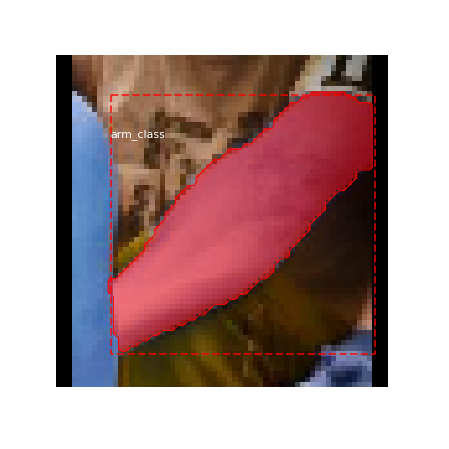

In [24]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (64, 64, 3)           min:    0.00000  max:  250.00000  uint8
molded_images            shape: (1, 64, 64, 3)        min: -123.70000  max:  146.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:   64.00000  int64
anchors                  shape: (1, 1023, 4)          min:   -0.71833  max:    0.98140  float32


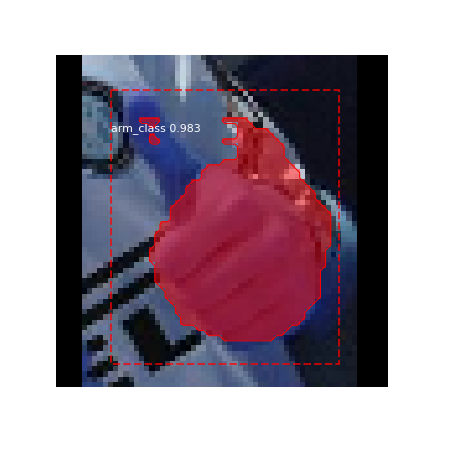

In [23]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [25]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.4
